In [1]:
#!pip install pydataxm==0.3.4
#!pip install pypsa
#!pip install cartopy==0.23.0
#!pip install geopy
#!pip install seaborn
#!pip install openpyxl

In [2]:
#Import the libraries
import datetime as dt           # Permite trabajar con fechas
from datetime import date
import time
import math
import pandas as pd             # Manipulacion de datos
import numpy as np              # Manipulacion de datos
import matplotlib.pyplot as plt # Construcción de gráficas
import seaborn as sns
import json
from pathlib import Path
from pyproj import Transformer
from geopy.geocoders import Nominatim
import cartopy.crs as ccrs
#API de XM
from pydataxm import *          # Importa la libreria que fue instalada con pip install pydataxm o tambien desde GitHub
#PyPsa
import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
# Colab
#from google.colab import files
#from google.colab import data_table
#data_table.enable_dataframe_formatter()

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Cargar la red desde un archivo .nc
network = pypsa.Network()
network.import_from_netcdf("RED_STN_COLOMBIA.nc")

INFO:pypsa.io:Imported network RED_STN_COLOMBIA.nc has buses, lines


In [4]:
network.lines.s_max_pu

Line
Line_0      1.300000
Line_2      1.000000
Line_3      1.300000
Line_4      1.725962
Line_5      1.728846
              ...   
Line_262    1.000000
Line_263    1.199695
Line_265    1.003812
Line_267    1.059524
Line_268    1.428750
Name: s_max_pu, Length: 193, dtype: float64

In [5]:
demanda_mpode = pd.read_excel('MPODE-PYPSA.xlsx')
demanda_mpode = demanda_mpode.drop('Unnamed: 0',axis=1)
demanda_mpode

BCod  ..Bus.Name..  LCod  dd/mm/yyyy  Llev  ..Load.. Values_Bus
0        9  Aguablnca115     1  01/01/2023     1     43.31  JUANCHITO
1        9  Aguablnca115     1  01/01/2023     2     36.38  JUANCHITO
2        9  Aguablnca115     1  01/01/2023     3     33.53  JUANCHITO
3        9  Aguablnca115     1  01/01/2023     4     34.07  JUANCHITO
4        9  Aguablnca115     1  01/01/2023     5     27.83  JUANCHITO
...    ...           ...   ...         ...   ...       ...        ...
1805     5    Renacer115     1  30/04/2025     1     16.54    RENACER
1806     5    Renacer115     1  30/04/2025     2     14.03    RENACER
1807     5    Renacer115     1  30/04/2025     3     12.82    RENACER
1808     5    Renacer115     1  30/04/2025     4     12.85    RENACER
1809     5    Renacer115     1  30/04/2025     5     11.07    RENACER

[1810 rows x 7 columns]

In [6]:
#Una vez asignados todos los nodos de MPODE a los buses de PYPSA, se pueden sumar los LOADS por cada bus y 
#conocer la proporción de demanda en cada punto respecto al país. Ya con eso y con la demanda horaria de XM,
#se tendrían los snapshots necesarios para PYPSA y hacer el Power Flow.
demanda_Bus = demanda_mpode.groupby(['Values_Bus']).sum()
demanda_Bus = demanda_Bus.drop(['BCod','..Bus.Name..','LCod','dd/mm/yyyy','Llev'], axis=1)
demanda_Bus

..Load..
Values_Bus               
ALFEREZ (EEB)      495.20
ALTAMIRA           387.98
ANCON SUR (EPM)    586.43
ANTIOQUIA          102.10
ARMENIA           1705.33
...                   ...
TUNAL              740.04
URABA              342.57
URRA               324.72
VALLEDUPAR         698.81
YUMBO             1889.29

[74 rows x 1 columns]

In [7]:
#Se calcula la proporción correspondiente de cada Bus sobre la demanda nacional
PROPORTION = demanda_Bus["..Load.."]/demanda_Bus["..Load.."].sum()
PROPORTION = pd.DataFrame(PROPORTION)
PROPORTION.reset_index(inplace=True)
PROPORTION

Values_Bus  ..Load..
0     ALFEREZ (EEB)  0.010565
1          ALTAMIRA  0.008278
2   ANCON SUR (EPM)  0.012512
3         ANTIOQUIA  0.002178
4           ARMENIA  0.036384
..              ...       ...
69            TUNAL  0.015789
70            URABA  0.007309
71             URRA  0.006928
72       VALLEDUPAR  0.014909
73            YUMBO  0.040309

[74 rows x 2 columns]

# Recolección de información de la API de XM

In [8]:
# creando el objeto de fecha desde que comienza el analisis
start_date = date(2024, 7, 1)
start_date

datetime.date(2024, 7, 1)

In [9]:
# creando el objeto de fecha de la fecha de hoy
#end_date = date.today()
end_date = date(2024, 7, 31)
end_date

datetime.date(2024, 7, 31)

In [10]:
objetoAPI = pydataxm.ReadDB()  # Se asigna un objeto que pueda realizar el consumo de la data en la API

## Perfil de demanda hisotrico acoplado a la demanda al SIN proyectada (Está esta mensual)

In [11]:
DEMANDA_XM = objetoAPI.request_data('DemaReal','Sistema', dt.date(start_date.year, start_date.month, start_date.day),dt.date(end_date.year, end_date.month, end_date.day))#dt.date(end_date.year, end_date.month-1, 1),dt.date(end_date.year, end_date.month-1, 20))
# Supongamos que df es tu DataFrame y 'fecha' es la columna con las fechas
DEMANDA_XM['Date'] = pd.to_datetime(DEMANDA_XM['Date'])  # Asegúrate de que la columna es de tipo datetime
DEMANDA_XM = DEMANDA_XM.sort_values(by='Date')  # Ordena el DataFrame por la columna 'fecha'

# Si deseas que el DataFrame quede ordenado permanentemente
DEMANDA_XM = DEMANDA_XM.reset_index(drop=True)
FECHAS_XM = DEMANDA_XM["Date"]

# Un vistazo de la demanda real del sistema completo
DEMANDA_XM 
#Porcentaje = DEMANDA_XM.drop(['Id','Values_code','Date'], axis=1)/1000 #Se convierte a MWh
#Porcentaje = Porcentaje.div(Porcentaje.sum(axis=1), axis=0)
#Porcentaje


c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead



Id Values_code  Values_Hour01  Values_Hour02  Values_Hour03  \
0   Sistema     Sistema     7811693.64     7549416.04     7307052.49   
1   Sistema     Sistema     8028616.49     7758372.27     7592755.29   
2   Sistema     Sistema     8224175.48     7913081.57     7709701.28   
3   Sistema     Sistema     8275756.84     8021135.68     7793885.26   
4   Sistema     Sistema     8307443.94     8025476.82     7812822.82   
5   Sistema     Sistema     7906086.91     7610746.84     7408520.52   
6   Sistema     Sistema     7978832.28     7722735.03     7482942.30   
7   Sistema     Sistema     7950940.40     7699880.34     7490234.56   
8   Sistema     Sistema     8419337.31     8149915.12     7951179.14   
9   Sistema     Sistema     8447489.57     8090489.79     7892172.10   
10  Sistema     Sistema     8611486.08     8323117.12     8086308.49   
11  Sistema     Sistema     8457116.78     8191035.57     7969264.81   
12  Sistema     Sistema     8532778.78     8228476.23     8008226.86   
13  Sistema     Sistema     8227305.01     7930153.51     7699926.85   
14  Sistema     Sistema     8124366.13     7812557.87     7594695.71   
15  Sistema     Sistema     8439546.55     8170097.05     7927401.88   
16  Sistema     Sistema     8644026.13     8333317.52     8114807.72   
17  Sistema     Sistema     8390903.67     8125215.44     7925436.69   
18  Sistema     Sistema     8376850.65     8093190.54     7915773.04   
19  Sistema     Sistema     8228592.42     7963318.30     7700972.07   
20  Sistema     Sistema     8110192.74     7809885.08     7554697.58   
21  Sistema     Sistema     8113731.76     7813662.09     7677562.25   
22  Sistema     Sistema     8490796.52     8201890.83     7990922.42   
23  Sistema     Sistema     8420218.54     8136923.39     7971864.07   
24  Sistema     Sistema     8566176.48     8352754.42     8156717.74   
25  Sistema     Sistema     8528226.23     8272914.03     8046891.74   
26  Sistema     Sistema     8587916.40     8307136.22     8076982.20   
27  Sistema     Sistema     8238928.01     7971086.30     7739670.49   
28  Sistema     Sistema     8212416.73     7942142.93     7734445.98   
29  Sistema     Sistema     9015249.60     8785547.47     8550020.01   
30  Sistema     Sistema     8845693.14     8596566.47     8376288.54   

    Values_Hour04  Values_Hour05  Values_Hour06  Values_Hour07  Values_Hour08  \
0      7149225.69     7116187.14     7078313.92     6973105.45     7280605.82   
1      7517588.53     7620631.93     7858063.01     8093097.99     8753809.40   
2      7611192.38     7725382.59     7958343.23     8241829.98     8803364.64   
3      7716629.39     7809367.40     8053301.64     8325684.81     8889096.35   
4      7701079.41     7793161.31     8020795.02     8278805.67     8824413.15   
5      7338957.03     7392485.34     7469781.85     7672414.94     8230193.88   
6      7314987.53     7211778.25     7054932.08     6990009.58     7232048.48   
7      7421800.43     7582286.83     7863240.51     8105670.12     8722905.99   
8      7855944.24     8013587.84     8303983.13     8446496.92     8957911.35   
9      7790408.36     7958580.51     8280935.90     8481986.07     8957441.70   
10     7972737.42     8119386.29     8409962.53     8542749.42     9059923.83   
11     7882929.36     8049077.71     8319518.14     8438629.59     8945638.69   
12     7829588.72     7782224.37     7853574.23     8010541.28     8551726.10   
13     7529701.55     7417247.30     7314080.10     7192142.05     7494894.88   
14     7494223.68     7595434.43     7763788.40     8008972.85     8650152.53   
15     7809437.03     7964143.86     8268780.64     8356555.89     8865215.43   
16     8030395.43     8180754.04     8501933.72     8657145.55     9091836.76   
17     7814457.19     8005902.44     8384434.36     8520394.49     8996096.48   
18     7815624.34     7949971.70     8308717.13     8484372.48     8970037.20   
19     7570985.44     7526740.10     7413057.16     7384212.21     7747338.31   
20 

### Se cargan los intervalos de confianza de la proyeccion de la demanda al SIN

In [12]:

# Cargar desde la fila 2 y columna 36 sin encabezado
DEMANDA_SIN = pd.read_excel(
    'DemandaSIN.xlsx',
    skiprows=1,  # Omitir la primera fila
    usecols="AJ:AO",  # Omitir las primeras 35 columnas
    header=None  # No usar encabezados
)
DEMANDA_SIN.columns = DEMANDA_SIN.iloc[0]  # Asignar la primera fila como encabezado
DEMANDA_SIN = DEMANDA_SIN[1:].reset_index(drop=True) 
DEMANDA_SIN['Fecha'] = pd.to_datetime(DEMANDA_SIN['Fecha'])
DEMANDA_SIN["Fecha"] = DEMANDA_SIN["Fecha"].dt.to_period("M")
# Mostrar los primeros datos
DEMANDA_SIN

0      Fecha   Esc. Medio IC Superior 95% IC Inferior 95% IC Superior 68%  \
0    2024-04  5957.764675     6079.840591     5833.123657     6019.528977   
1    2024-05  6144.401462     6272.240088     6014.171493     6209.058041   
2    2024-06  5955.376421     6077.911285     5830.343656     6017.907746   
3    2024-07  6119.900011     6305.552634     5932.083863     6213.105461   
4    2024-08  6169.543297      6355.54159      5981.19414     6262.361517   
..       ...          ...             ...             ...             ...   
172  2038-08  8425.842146     9933.492305     6954.799485      9252.59227   
173  2038-09  8443.258288     9951.867435     6970.572079     9269.707861   
174  2038-10  8711.917809    10284.780669     7176.426237     9572.792169   
175  2038-11   8415.54397     9937.281719     6930.743441     9249.349663   
176  2038-12  8581.746532    10132.937472     7068.003277      9431.46068   

0   IC Inferior 68%  
0       5893.647574  
1       6077.532997  
2       5890.549059  
3       6024.601142  
4       6074.477348  
..              ...  
172      7616.70105  
173     7633.974751  
174     7868.940487  
175     7599.549674  
176     7750.054876  

[177 rows x 6 columns]

In [13]:
import pandas as pd

DEMANDA_XM["mes"] = DEMANDA_XM["Date"].dt.to_period("M")

# Crear una Serie vacía para almacenar los resultados concatenados
resultados_totales = pd.Series(dtype=float)

for mes in DEMANDA_XM['mes'].unique():
    año_arriba = mes + 12 * 6 + 3#2030
    print(año_arriba)
    
    emes = DEMANDA_XM[DEMANDA_XM['mes'] == mes]
    #print(emes)
    columnas_a_eliminar = ['mes', 'Id', 'Values_code', 'Date']
    
    # Eliminar las columnas no deseadas
    grupo_sin_extra = emes.drop(columns=columnas_a_eliminar)
    
    # Calcular la suma total del mes
    suma_mes = grupo_sin_extra.values.sum()
    #print(suma_mes/1e6)
    # Obtener la demanda del mes desplazado en DEMANDA_SIN
    demanda_mes = DEMANDA_SIN[DEMANDA_SIN['Fecha'] == año_arriba]['Esc. Medio'] * 1000  # MWh
    
    # Calcular el resultado ajustado
    total = grupo_sin_extra / suma_mes * demanda_mes.values[0]
    print(total)
    # Apilar los resultados y concatenarlos a la Serie acumuladora
    resultados_totales = pd.concat([resultados_totales, total.stack()], ignore_index=True)

# Mostrar el resultado concatenado
DEM_SIN_series = resultados_totales
DEM_SIN_series.mean()

2030-10
    Values_Hour01  Values_Hour02  Values_Hour03  Values_Hour04  Values_Hour05  \
0     8326.321609    8046.765376    7788.435114    7620.210814    7584.995712   
1     8557.535159    8269.487471    8092.959780    8012.841096    8122.672911   
2     8765.977415    8434.388893    8217.610076    8112.611491    8234.324458   
3     8820.956912    8549.561519    8307.340028    8224.994605    8323.842119   
4     8854.731532    8554.188650    8327.525179    8208.420205    8306.568385   
5     8426.933431    8112.136599    7896.587775    7822.441499    7879.496210   
6     8504.471206    8231.502479    7975.912401    7796.892908    7686.884286   
7     8474.741832    8207.142141    7983.685069    7910.742555    8081.801667   
8     8973.996346    8686.824843    8474.996300    8373.487403    8541.516434   
9     9004.003254    8623.484621    8412.101924    8303.634073    8482.885266   
10    9178.803719    8871.437249    8619.027860    8497.974821    8654.284799   
11    9014.264696   

9882.090423209116

In [14]:
# Fechas que se están modelando
horas = pd.date_range(start=FECHAS_XM.min(), periods=len(DEM_SIN_series), freq="h")

# Asegurarse de que network.snapshots coincide con las horas modeladas
network.snapshots = horas #pd.date_range(start='2030-10-01', periods=len(DEM_SIN_series), freq="h")

# Se agregan las demandas (loads) a la red de Pypsa
for _, row in PROPORTION.iterrows():
    network.add("Load",
                name=row['Values_Bus'],
                bus=row['Values_Bus'],
                p_set=row['..Load..']*pd.Series(DEM_SIN_series.values, index=horas),
                )

In [15]:
df_generacion = pd.read_excel('Generacion_1.xlsx')
df_generacion = df_generacion.drop('Unnamed: 0',axis=1)
df_generacion

Values_Code          Values_Name Values_Type Values_RecType  \
0         2QEK             SALTO II  HIDRAULICA   FILO DE AGUA   
1         3DDT  LATAM SOLAR LA LOMA       SOLAR         NORMAL   
2         3ENA             TESORITO     TERMICA         NORMAL   
3         3HF5            FUNDACION       SOLAR         NORMAL   
4         3IRX       PORTON DEL SOL       SOLAR         NORMAL   
..         ...                  ...         ...            ...   
72        URA1                 URRA  HIDRAULICA         NORMAL   
73        ZPA2            ZIPAEMG 2     TERMICA         NORMAL   
74        ZPA3            ZIPAEMG 3     TERMICA         NORMAL   
75        ZPA4            ZIPAEMG 4     TERMICA         NORMAL   
76        ZPA5            ZIPAEMG 5     TERMICA         NORMAL   

   Values_CompanyCode Values_EnerSource Values_OperStartdate  \
0                ENDG              AGUA           2014-06-25   
1                ENDG         RAD SOLAR           2024-06-24   
2                EPSG               GAS           2022-09-13   
3                ENDG         RAD SOLAR           2023-02-28   
4                PDSG         RAD SOLAR           2024-03-08   
..                ...               ...                  ...   
72               EMUG              AGUA           2000-02-14   
73               ENDG            CARBON           1964-01-01   
74               ENDG            CARBON           1976-01-01   
75               ENDG            CARBON           1981-04-01   
76               ENDG            CARBON           1985-12-14   

    Values_Capacidad (MW)       Values_Bus  Values_OperStartyear  
0                      35  NUEVA ESPERANZA                  2014  
1                     150          LA LOMA                  2024  
2                     200         TESORITO                  2022  
3                      90        FUNDACION                  2023  
4                     102   PORTON DEL SOL                  2024  
..                    ...              ...                   ...  
72                    338             URRA                  2000  
73                     36           BACATA                  1964  
74                     63           BACATA                  1976  
75                     64           BACATA                  1981  
76                     63           BACATA                  1985  

[77 rows x 10 columns]

In [17]:
df_generacion[df_generacion['Values_Type'] == 'TERMICA']#.nunique()

Values_Code         Values_Name Values_Type   Values_RecType  \
2         3ENA            TESORITO     TERMICA           NORMAL   
11        CTG1         CARTAGENA 1     TERMICA           NORMAL   
12        CTG2         CARTAGENA 2     TERMICA           NORMAL   
13        CTG3         CARTAGENA 3     TERMICA           NORMAL   
18        GE32          GECELCA 32     TERMICA           NORMAL   
19        GEC3           GECELCA 3     TERMICA           NORMAL   
29        MRL1      MERILECTRICA 1     TERMICA           NORMAL   
33        PPA1             PAIPA 1     TERMICA           NORMAL   
34        PPA2             PAIPA 2     TERMICA           NORMAL   
35        PPA3             PAIPA 3     TERMICA           NORMAL   
36        PPA4             PAIPA 4     TERMICA           NORMAL   
40        PRG1      PROELECTRICA 1     TERMICA           NORMAL   
41        PRG2      PROELECTRICA 2     TERMICA           NORMAL   
49        TBQ3      BARRANQUILLA 3     TERMICA           NORMAL   
50        TBQ4      BARRANQUILLA 4     TERMICA           NORMAL   
51        TBST           TEBSAB CC     TERMICA  CICLO COMBINADO   
52        TCBE   TERMOCARIBE III 1     TERMICA           NORMAL   
53        TCDT  TERMOCANDELARIA CC     TERMICA  CICLO COMBINADO   
54        TDR1       TERMODORADA 1     TERMICA           NORMAL   
55        TEC1      TERMOEMCALI CC     TERMICA  CICLO COMBINADO   
56        TFL1         FLORES I CC     TERMICA  CICLO COMBINADO   
57        TFL4         FLORES 4 CC     TERMICA  CICLO COMBINADO   
58        TGJ1           GUAJIRA 1     TERMICA           NORMAL   
59        TGJ2           GUAJIRA 2     TERMICA           NORMAL   
61        TRM1      TERMOCENTRO CC     TERMICA  CICLO COMBINADO   
62        TRN1          TERMONORTE     TERMICA           NORMAL   
63        TSJ1          TASAJERO 1     TERMICA           NORMAL   
64        TSJ2          TASAJERO 2     TERMICA           NORMAL   
65        TSR1      TERMOSIERRA CC     TERMICA  CICLO COMBINADO   
66        TVL1       TERMOVALLE CC     TERMICA  CICLO COMBINADO   
67        TYP1        TERMOYOPAL 1     TERMICA           NORMAL   
68        TYP2        TERMOYOPAL 2     TERMICA           NORMAL   
69        TYP3       TERMOYOPAL G3     TERMICA           NORMAL   
70        TYP4       TERMOYOPAL G4     TERMICA           NORMAL   
71        TYP5       TERMOYOPAL G5     TERMICA           NORMAL   
73        ZPA2           ZIPAEMG 2     TERMICA           NORMAL   
74        ZPA3           ZIPAEMG 3     TERMICA           NORMAL   
75        ZPA4           ZIPAEMG 4     TERMICA           NORMAL   
76        ZPA5           ZIPAEMG 5     TERMICA           NORMAL   

   Values_CompanyCode Values_EnerSource Values_OperStartdate  \
2                EPSG               GAS           2022-09-13   
11               NTCG       COMBUSTOLEO           1995-07-20   
12               NTCG       COMBUSTOLEO           1980-01-01   
13               NTCG       COMBUSTOLEO           1980-01-01   
18               GECG            CARBON           2018-09-28   
19               GECG            CARBON           2015-09-17   
29               EPSG               GAS           1998-02-05   
33               HIMG            CARBON           1963-01-01   
34               HIMG            CARBON           1975-01-01   
35               HIMG            CARBON           1982-05-06   
36               SOCG            CARBON           1999-01-08   
40               PRIG               GAS           1993-07-01   
41               PRIG               GAS           1993-07-01   
49               TBSG               GAS           1980-01-01   
50               TBSG               GAS           1980-01-01   
51               TBSG               GAS           1989-10-21   
52               TCBG               GLP           2024-03-21   
53               TCIG               GAS           2023-10-27   
54               EPMG            JET-A1           1997-08-11   
55               TEMG              ACPM   

In [18]:
#Se establece el límite de producción en la plantas solares para que no produzcan en la noche
from itertools import chain
lim_solar = list(chain.from_iterable([[0]*5+[1]*14+[0]*5]*int(len(horas)/24)))
lim_solar = pd.Series(lim_solar, index=horas)
normal = pd.Series([1]*len(horas), index=horas)

In [19]:
GENE_XM = objetoAPI.request_data('DispoDeclarada','Recurso',dt.date(start_date.year, start_date.month, start_date.day),dt.date(end_date.year, end_date.month, end_date.day))#dt.date(end_date.year, end_date.month-1, 1),dt.date(end_date.year, end_date.month-1, 20))
GENE_XM

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead



Id Values_code  Values_Hour01  Values_Hour02  Values_Hour03  \
0     Recurso        2QBW          14000          16000          16000   
1     Recurso        2QEK          35000          35000          35000   
2     Recurso        2QRL            650            650            650   
3     Recurso        2QV2           8000           8000           8000   
4     Recurso        2R22              0              0              0   
...       ...         ...            ...            ...            ...   
9625  Recurso        VNTB              0              0              0   
9626  Recurso        ZPA2              0              0              0   
9627  Recurso        ZPA3              0              0              0   
9628  Recurso        ZPA4          50000          50000          50000   
9629  Recurso        ZPA5              0              0              0   

      Values_Hour04  Values_Hour05  Values_Hour06  Values_Hour07  \
0             18000          18000          18000          18000   
1             35000          35000          35000          35000   
2               650            650            650            650   
3              8000           8000           8000           8000   
4                 0              0              0              0   
...             ...            ...            ...            ...   
9625              0              0              0              0   
9626              0              0              0              0   
9627              0              0              0              0   
9628          50000          50000          50000          50000   
9629              0              0              0              0   

      Values_Hour08  ...  Values_Hour16  Values_Hour17  Values_Hour18  \
0             18000  ...          16000          16000          16000   
1             35000  ...          35000          35000          35000   
2               650  ...            650            650            650   
3              8000  ...           6000           6000           6000   
4                 0  ...              0              0              0   
...             ...  ...            ...            ...            ...   
9625              0  ...              0              0              0   
9626              0  ...              0              0              0   
9627              0  ...              0              0              0   
9628          50000  ...          50000          50000          50000   
9629              0  ...              0              0              0   

      Values_Hour19  Values_Hour20  Values_Hour21  Values_Hour22  \
0             16000          14000          14000          14000   
1             35000          35000          35000          35000   
2               650            650            650            650   
3              6000           6000           6000           6000   
4                 0              0              0              0   
...             ...            ...            ...            ...   
9625              0              0              0              0   
9626              0              0              0              0   
9627              0              0              0              0   
9628          50000          50000          50000          50000   
9629              0              0              0              0   

      Values_Hour23  Values_Hour24       Date  
0             14000          14000 2024-07-31  
1             35000          35000 2024-07-31  
2               650            650 2024-07-31  
3              6000           6000 2024-07-31  
4                 0              0 2024-07-31  
...             ...            ...        ...  
9625              0              0 2024-07-30  
9626              0              0 2024-07-30  
9627              0              0 2024-07-30  
9628          50000          50000 2024-07-30  
9629              0              0 2024-07-30  

[9953 rows x 27 columns]

In [20]:
precio = objetoAPI.request_data('PrecOferDesp','Recurso', dt.date(start_date.year, start_date.month, start_date.day),dt.date(end_date.year, end_date.month, end_date.day))
precio

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead



Id Values_code  Values_Hour01  Values_Hour02  Values_Hour03  \
0     Recurso        2QEK       97.27400       97.27400       97.27400   
1     Recurso        3DDT       90.00002       90.00002       90.00002   
2     Recurso        3ENA      903.69000      903.69000      903.69000   
3     Recurso        3HF5       90.00001       90.00001       90.00001   
4     Recurso        3IRX      150.00000      150.00000      150.00000   
...       ...         ...            ...            ...            ...   
2305  Recurso        URA1       89.87000       89.87000       89.87000   
2306  Recurso        ZPA2      394.00000      394.00000      394.00000   
2307  Recurso        ZPA3      376.00000      376.00000      376.00000   
2308  Recurso        ZPA4      362.00000      362.00000      362.00000   
2309  Recurso        ZPA5      353.00000      353.00000      353.00000   

      Values_Hour04  Values_Hour05  Values_Hour06  Values_Hour07  \
0          97.27400       97.27400       97.27400       97.27400   
1          90.00002       90.00002       90.00002       90.00002   
2         903.69000      903.69000      903.69000      903.69000   
3          90.00001       90.00001       90.00001       90.00001   
4         150.00000      150.00000      150.00000      150.00000   
...             ...            ...            ...            ...   
2305       89.87000       89.87000       89.87000       89.87000   
2306      394.00000      394.00000      394.00000      394.00000   
2307      376.00000      376.00000      376.00000      376.00000   
2308      362.00000      362.00000      362.00000      362.00000   
2309      353.00000      353.00000      353.00000      353.00000   

      Values_Hour08  ...  Values_Hour16  Values_Hour17  Values_Hour18  \
0          97.27400  ...       97.27400       97.27400       97.27400   
1          90.00002  ...       90.00002       90.00002       90.00002   
2         903.69000  ...      903.69000      903.69000      903.69000   
3          90.00001  ...       90.00001       90.00001       90.00001   
4         150.00000  ...      150.00000      150.00000      150.00000   
...             ...  ...            ...            ...            ...   
2305       89.87000  ...       89.87000       89.87000       89.87000   
2306      394.00000  ...      394.00000      394.00000      394.00000   
2307      376.00000  ...      376.00000      376.00000      376.00000   
2308      362.00000  ...      362.00000      362.00000      362.00000   
2309      353.00000  ...      353.00000      353.00000      353.00000   

      Values_Hour19  Values_Hour20  Values_Hour21  Values_Hour22  \
0          97.27400       97.27400       97.27400       97.27400   
1          90.00002       90.00002       90.00002       90.00002   
2         903.69000      903.69000      903.69000      903.69000   
3          90.00001       90.00001       90.00001       90.00001   
4         150.00000      150.00000      150.00000      150.00000   
...             ...            ...            ...            ...   
2305       89.87000       89.87000       89.87000       89.87000   
2306      394.00000      394.00000      394.00000      394.00000   
2307      376.00000      376.00000      376.00000      376.00000   
2308      362.00000      362.00000      362.00000      362.00000   
2309      353.00000      353.00000      353.00000      353.00000   

      Values_Hour23  Values_Hour24       Date  
0          97.27400       97.27400 2024-07-31  
1          90.00002       90.00002 2024-07-31  
2         903.69000      903.69000 2024-07-31  
3          90.00001       90.00001 2024-07-31  
4         150.00000      150.00000 2024-07-31  
...             ...            ...        ...  
2305       89.87000       89.87000 2024-07-30  
2306      394.00000      394.00000 2024-07-30  
2307      376.00000      376.00000 2024-07-30  
2308      362.00000      362.00000 2024-07-30  
2309      353.00000      353.00000 2024-07-30  

[2387 rows x 27 columns]

In [21]:
df_generacion[~df_generacion['Values_Code'].isin(precio['Values_code'])]
#Sin precio

Empty DataFrame
Columns: [Values_Code, Values_Name, Values_Type, Values_RecType, Values_CompanyCode, Values_EnerSource, Values_OperStartdate, Values_Capacidad (MW), Values_Bus, Values_OperStartyear]
Index: []

In [22]:
solares = df_generacion[df_generacion['Values_Type'] == 'SOLAR']
solares

Values_Code            Values_Name Values_Type Values_RecType  \
1         3DDT    LATAM SOLAR LA LOMA       SOLAR         NORMAL   
3         3HF5              FUNDACION       SOLAR         NORMAL   
4         3IRX         PORTON DEL SOL       SOLAR         NORMAL   
5         3IZ6  PARQUE SOLAR LA UNION       SOLAR         NORMAL   
16        EPFV                EL PASO       SOLAR         NORMAL   
27        MATA                LA MATA       SOLAR         NORMAL   
60        TPUY     PARQUE SOLAR TEPUY       SOLAR         NORMAL   

   Values_CompanyCode Values_EnerSource Values_OperStartdate  \
1                ENDG         RAD SOLAR           2024-06-24   
3                ENDG         RAD SOLAR           2023-02-28   
4                PDSG         RAD SOLAR           2024-03-08   
5                SLUG         RAD SOLAR           2024-06-19   
16               ENDG         RAD SOLAR           2024-03-23   
27               SLMG         RAD SOLAR           2024-06-27   
60               EPMG         RAD SOLAR           2024-06-12   

    Values_Capacidad (MW)      Values_Bus  Values_OperStartyear  
1                     150         LA LOMA                  2024  
3                      90       FUNDACION                  2023  
4                     102  PORTON DEL SOL                  2024  
5                     100  MONTERIA (ISA)                  2024  
16                     68         LA LOMA                  2024  
27                     80           OCAÑA                  2024  
60                     83          PURNIO                  2024

In [23]:
carbon = df_generacion[df_generacion['Values_EnerSource'] == 'CARBON']
carbon

Values_Code Values_Name Values_Type Values_RecType Values_CompanyCode  \
18        GE32  GECELCA 32     TERMICA         NORMAL               GECG   
19        GEC3   GECELCA 3     TERMICA         NORMAL               GECG   
33        PPA1     PAIPA 1     TERMICA         NORMAL               HIMG   
34        PPA2     PAIPA 2     TERMICA         NORMAL               HIMG   
35        PPA3     PAIPA 3     TERMICA         NORMAL               HIMG   
36        PPA4     PAIPA 4     TERMICA         NORMAL               SOCG   
58        TGJ1   GUAJIRA 1     TERMICA         NORMAL               GECG   
59        TGJ2   GUAJIRA 2     TERMICA         NORMAL               GECG   
63        TSJ1  TASAJERO 1     TERMICA         NORMAL               TRMG   
64        TSJ2  TASAJERO 2     TERMICA         NORMAL               TERG   
73        ZPA2   ZIPAEMG 2     TERMICA         NORMAL               ENDG   
74        ZPA3   ZIPAEMG 3     TERMICA         NORMAL               ENDG   
75        ZPA4   ZIPAEMG 4     TERMICA         NORMAL               ENDG   
76        ZPA5   ZIPAEMG 5     TERMICA         NORMAL               ENDG   

   Values_EnerSource Values_OperStartdate  Values_Capacidad (MW)   Values_Bus  \
18            CARBON           2018-09-28                    270  CERROMATOSO   
19            CARBON           2015-09-17                    164  CERROMATOSO   
33            CARBON           1963-01-01                     36        PAIPA   
34            CARBON           1975-01-01                     72        PAIPA   
35            CARBON           1982-05-06                     70        PAIPA   
36            CARBON           1999-01-08                    165        PAIPA   
58            CARBON           1983-08-08                    145      GUAJIRA   
59            CARBON           1987-11-23                    130      GUAJIRA   
63            CARBON           1985-02-20                    165     TASAJERO   
64            CARBON           2015-11-30                    170     TASAJERO   
73            CARBON           1964-01-01                     36       BACATA   
74            CARBON           1976-01-01                     63       BACATA   
75            CARBON           1981-04-01                     64       BACATA   
76            CARBON           1985-12-14                     63       BACATA   

    Values_OperStartyear  
18                  2018  
19                  2015  
33                  1963  
34                  1975  
35                  1982  
36                  1999  
58                  1983  
59                  1987  
63                  1985  
64                  2015  
73                  1964  
74                  1976  
75                  1981  
76                  1985

In [24]:
car = precio[precio['Values_code'].isin(carbon['Values_Code'])]
#car = car.drop(columns=['Id', 'Date', 'Values_code'])
#car.mean()

In [25]:
precio[precio['Values_code'].isin(solares['Values_Code'])]


Id Values_code  Values_Hour01  Values_Hour02  Values_Hour03  \
1     Recurso        3DDT       90.00002       90.00002       90.00002   
3     Recurso        3HF5       90.00001       90.00001       90.00001   
4     Recurso        3IRX      150.00000      150.00000      150.00000   
5     Recurso        3IZ6      124.00000      124.00000      124.00000   
16    Recurso        EPFV       90.00000       90.00000       90.00000   
...       ...         ...            ...            ...            ...   
2237  Recurso        3IRX      220.00000      220.00000      220.00000   
2238  Recurso        3IZ6       85.00001       85.00001       85.00001   
2249  Recurso        EPFV       90.00001       90.00001       90.00001   
2260  Recurso        MATA       85.00000       85.00000       85.00000   
2293  Recurso        TPUY       85.96800       85.96800       85.96800   

      Values_Hour04  Values_Hour05  Values_Hour06  Values_Hour07  \
1          90.00002       90.00002       90.00002       90.00002   
3          90.00001       90.00001       90.00001       90.00001   
4         150.00000      150.00000      150.00000      150.00000   
5         124.00000      124.00000      124.00000      124.00000   
16         90.00000       90.00000       90.00000       90.00000   
...             ...            ...            ...            ...   
2237      220.00000      220.00000      220.00000      220.00000   
2238       85.00001       85.00001       85.00001       85.00001   
2249       90.00001       90.00001       90.00001       90.00001   
2260       85.00000       85.00000       85.00000       85.00000   
2293       85.96800       85.96800       85.96800       85.96800   

      Values_Hour08  ...  Values_Hour16  Values_Hour17  Values_Hour18  \
1          90.00002  ...       90.00002       90.00002       90.00002   
3          90.00001  ...       90.00001       90.00001       90.00001   
4         150.00000  ...      150.00000      150.00000      150.00000   
5         124.00000  ...      124.00000      124.00000      124.00000   
16         90.00000  ...       90.00000       90.00000       90.00000   
...             ...  ...            ...            ...            ...   
2237      220.00000  ...      220.00000      220.00000      220.00000   
2238       85.00001  ...       85.00001       85.00001       85.00001   
2249       90.00001  ...       90.00001       90.00001       90.00001   
2260       85.00000  ...       85.00000       85.00000       85.00000   
2293       85.96800  ...       85.96800       85.96800       85.96800   

      Values_Hour19  Values_Hour20  Values_Hour21  Values_Hour22  \
1          90.00002       90.00002       90.00002       90.00002   
3          90.00001       90.00001       90.00001       90.00001   
4         150.00000      150.00000      150.00000      150.00000   
5         124.00000      124.00000      124.00000      124.00000   
16         90.00000       90.00000       90.00000       90.00000   
...             ...            ...            ...            ...   
2237      220.00000      220.00000      220.00000      220.00000   
2238       85.00001       85.00001       85.00001       85.00001   
2249       90.00001       90.00001       90.00001       90.00001   
2260       85.00000       85.00000       85.00000       85.00000   
2293       85.96800       85.96800       85.96800       85.96800   

      Values_Hour23  Values_Hour24       Date  
1          90.00002       90.00002 2024-07-31  
3          90.00001       90.00001 2024-07-31  
4         150.00000      150.00000 2024-07-31  
5         124.00000      124.00000 2024-07-31  
16         90.00000       90.00000 2024-07-31  
...             ...            ...        ...  
2237      220.00000      220.00000 2024-07-30  
2238       85.00001       85.00001 2024-07-30  
2249       90.00001       90.00001 2024-07-30  
2260       85.00000       85.00000 2024-07-30  
2293       85.96800       85.96800 2024-07-30  

[217 rows x 27 columns]

In [26]:
df_costos = precio[precio['Values_code'].isin(df_generacion['Values_Code'])]
df_costos

Id Values_code  Values_Hour01  Values_Hour02  Values_Hour03  \
0     Recurso        2QEK       97.27400       97.27400       97.27400   
1     Recurso        3DDT       90.00002       90.00002       90.00002   
2     Recurso        3ENA      903.69000      903.69000      903.69000   
3     Recurso        3HF5       90.00001       90.00001       90.00001   
4     Recurso        3IRX      150.00000      150.00000      150.00000   
...       ...         ...            ...            ...            ...   
2305  Recurso        URA1       89.87000       89.87000       89.87000   
2306  Recurso        ZPA2      394.00000      394.00000      394.00000   
2307  Recurso        ZPA3      376.00000      376.00000      376.00000   
2308  Recurso        ZPA4      362.00000      362.00000      362.00000   
2309  Recurso        ZPA5      353.00000      353.00000      353.00000   

      Values_Hour04  Values_Hour05  Values_Hour06  Values_Hour07  \
0          97.27400       97.27400       97.27400       97.27400   
1          90.00002       90.00002       90.00002       90.00002   
2         903.69000      903.69000      903.69000      903.69000   
3          90.00001       90.00001       90.00001       90.00001   
4         150.00000      150.00000      150.00000      150.00000   
...             ...            ...            ...            ...   
2305       89.87000       89.87000       89.87000       89.87000   
2306      394.00000      394.00000      394.00000      394.00000   
2307      376.00000      376.00000      376.00000      376.00000   
2308      362.00000      362.00000      362.00000      362.00000   
2309      353.00000      353.00000      353.00000      353.00000   

      Values_Hour08  ...  Values_Hour16  Values_Hour17  Values_Hour18  \
0          97.27400  ...       97.27400       97.27400       97.27400   
1          90.00002  ...       90.00002       90.00002       90.00002   
2         903.69000  ...      903.69000      903.69000      903.69000   
3          90.00001  ...       90.00001       90.00001       90.00001   
4         150.00000  ...      150.00000      150.00000      150.00000   
...             ...  ...            ...            ...            ...   
2305       89.87000  ...       89.87000       89.87000       89.87000   
2306      394.00000  ...      394.00000      394.00000      394.00000   
2307      376.00000  ...      376.00000      376.00000      376.00000   
2308      362.00000  ...      362.00000      362.00000      362.00000   
2309      353.00000  ...      353.00000      353.00000      353.00000   

      Values_Hour19  Values_Hour20  Values_Hour21  Values_Hour22  \
0          97.27400       97.27400       97.27400       97.27400   
1          90.00002       90.00002       90.00002       90.00002   
2         903.69000      903.69000      903.69000      903.69000   
3          90.00001       90.00001       90.00001       90.00001   
4         150.00000      150.00000      150.00000      150.00000   
...             ...            ...            ...            ...   
2305       89.87000       89.87000       89.87000       89.87000   
2306      394.00000      394.00000      394.00000      394.00000   
2307      376.00000      376.00000      376.00000      376.00000   
2308      362.00000      362.00000      362.00000      362.00000   
2309      353.00000      353.00000      353.00000      353.00000   

      Values_Hour23  Values_Hour24       Date  
0          97.27400       97.27400 2024-07-31  
1          90.00002       90.00002 2024-07-31  
2         903.69000      903.69000 2024-07-31  
3          90.00001       90.00001 2024-07-31  
4         150.00000      150.00000 2024-07-31  
...             ...            ...        ...  
2305       89.87000       89.87000 2024-07-30  
2306      394.00000      394.00000 2024-07-30  
2307      376.00000      376.00000 2024-07-30  
2308      362.00000      362.00000 2024-07-30  
2309      353.00000      353.00000 2024-07-30  

[2387 rows x 27 columns]

In [27]:
# Sumar todas las columnas desde la columna 3 (índice 2)
suma_columnas = GENE_XM.iloc[:, 2:-1].sum()

In [28]:
# Filtrar df_generadores para que solo contenga los valores que están en df_filtro['values']
df_filtrado = GENE_XM[GENE_XM['Values_code'].isin(df_generacion['Values_Code'])]
df_filtrado['Values_code'].nunique()

77

In [29]:
fechas = GENE_XM['Date'].unique()
# Sort the dates using numpy
sorted_dates = np.sort(fechas)

# If you need it back as a Pandas Series (optional)
sorted_dates = pd.Series(sorted_dates)

print(sorted_dates)

0    2024-07-01
1    2024-07-02
2    2024-07-03
3    2024-07-04
4    2024-07-05
5    2024-07-06
6    2024-07-07
7    2024-07-08
8    2024-07-09
9    2024-07-10
10   2024-07-11
11   2024-07-12
12   2024-07-13
13   2024-07-14
14   2024-07-15
15   2024-07-16
16   2024-07-17
17   2024-07-18
18   2024-07-19
19   2024-07-20
20   2024-07-21
21   2024-07-22
22   2024-07-23
23   2024-07-24
24   2024-07-25
25   2024-07-26
26   2024-07-27
27   2024-07-28
28   2024-07-29
29   2024-07-30
30   2024-07-31
dtype: datetime64[ns]


In [30]:
#ACa puedo cambiar que df quiero ver
# df_filtrado = car+
df_filtrado

Id Values_code  Values_Hour01  Values_Hour02  Values_Hour03  \
1     Recurso        2QEK          35000          35000          35000   
62    Recurso        3DDT              0              0              0   
72    Recurso        3ENA         200000         200000         200000   
98    Recurso        3HF5              0              0              0   
110   Recurso        3IRX              0              0              0   
...       ...         ...            ...            ...            ...   
9621  Recurso        URA1         246000         246000         246000   
9626  Recurso        ZPA2              0              0              0   
9627  Recurso        ZPA3              0              0              0   
9628  Recurso        ZPA4          50000          50000          50000   
9629  Recurso        ZPA5              0              0              0   

      Values_Hour04  Values_Hour05  Values_Hour06  Values_Hour07  \
1             35000          35000          35000          35000   
62                0              0              0          10000   
72           200000         200000         200000         200000   
98                0              0              0          35000   
110               0              0              0           3000   
...             ...            ...            ...            ...   
9621         246000         246000         246000         246000   
9626              0              0              0              0   
9627              0              0              0              0   
9628          50000          50000          50000          50000   
9629              0              0              0              0   

      Values_Hour08  ...  Values_Hour16  Values_Hour17  Values_Hour18  \
1             35000  ...          35000          35000          35000   
62            83000  ...         133000         101000          45000   
72           200000  ...         200000         200000         200000   
98            65000  ...          40000          17000           7000   
110           15000  ...          55000          28000           8000   
...             ...  ...            ...            ...            ...   
9621         249000  ...         249000         249000         249000   
9626              0  ...              0              0              0   
9627              0  ...              0              0              0   
9628          50000  ...          50000          50000          50000   
9629              0  ...              0              0              0   

      Values_Hour19  Values_Hour20  Values_Hour21  Values_Hour22  \
1             35000          35000          35000          35000   
62                0              0              0              0   
72           200000         200000         200000         200000   
98                0              0              0              0   
110               0              0              0              0   
...             ...            ...            ...            ...   
9621         246000         246000         246000         246000   
9626              0              0              0              0   
9627              0              0              0              0   
9628          50000          50000          50000          50000   
9629              0              0              0              0   

      Values_Hour23  Values_Hour24       Date  
1             35000          35000 2024-07-31  
62                0              0 2024-07-31  
72           200000         200000 2024-07-31  
98                0              0 2024-07-31  
110               0              0 2024-07-31  
...             ...            ...        ...  
9621         246000         246000 2024-07-30  
9626              0              0 2024-07-30  
9627              0              0 2024-07-30  
9628          50000          50000 2024-07-30  
9629              0              0 2024-07-30  

[2387 rows x 27 columns]

In [31]:

# Initialize an empty list to store the results
result_series_list = []

for date in sorted_dates:
    #print(date)
    # Filter the DataFrame for the specific date and sum the relevant columns
    filtered_sum = df_filtrado[df_filtrado['Date'] == date].iloc[:, 2:-1].sum()/ 1000#GENE_XM[GENE_XM['Date'] == date].iloc[:, 2:-1].sum() / 1000#df_filtrado[df_filtrado['Date'] == date].iloc[:, 2:-1].sum() / 1000

    # Convert the result to a Series and add a date identifier (optional)
    filtered_sum_series = pd.Series(filtered_sum)
    
    # Append to the list
    result_series_list.append(filtered_sum_series)

# Concatenate all results into a single Series
final_series = pd.concat(result_series_list).reset_index(drop=True)

print(final_series)


0      13153.6
1      13773.6
2      13773.6
3      13773.6
4      13773.6
        ...   
739    15439.6
740    15439.6
741    15147.6
742    15058.6
743    15058.6
Length: 744, dtype: float64


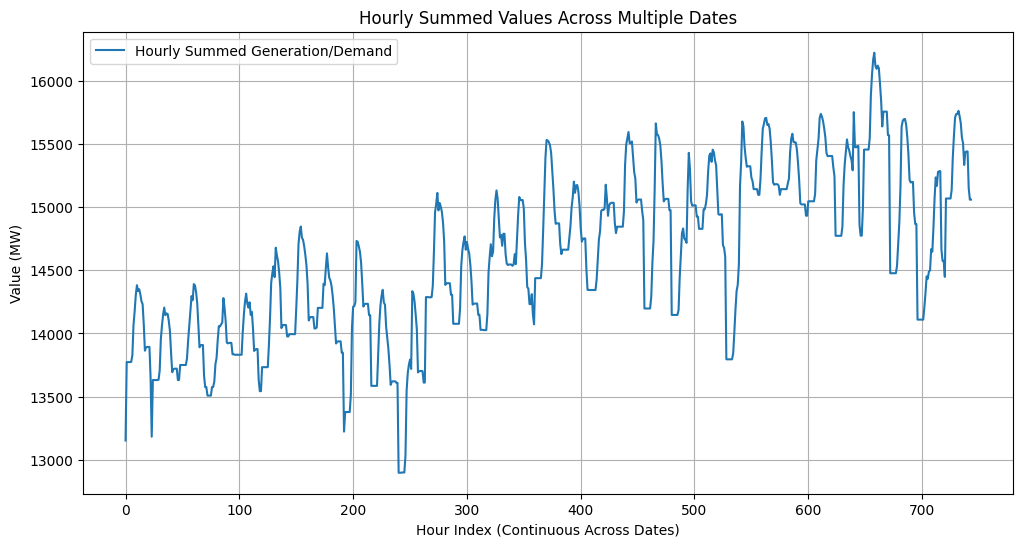

In [32]:
# COmo uso sum, los valores son tan grandes porque es la suma de todos los generadores de cada hora para todo el DIA
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(final_series, label='Hourly Summed Generation/Demand')
plt.xlabel('Hour Index (Continuous Across Dates)')
plt.ylabel('Value (MW)')
plt.title('Hourly Summed Values Across Multiple Dates')
plt.grid(True)
plt.legend()
plt.show()


In [33]:
DEM_SIN_series

0       8326.321609
1       8046.765376
2       7788.435114
3       7620.210814
4       7584.995712
           ...     
739    12042.180205
740    11897.190920
741    11423.613552
742    10739.217881
743    10074.894123
Length: 744, dtype: float64

In [34]:
final_series

0      13153.6
1      13773.6
2      13773.6
3      13773.6
4      13773.6
        ...   
739    15439.6
740    15439.6
741    15147.6
742    15058.6
743    15058.6
Length: 744, dtype: float64

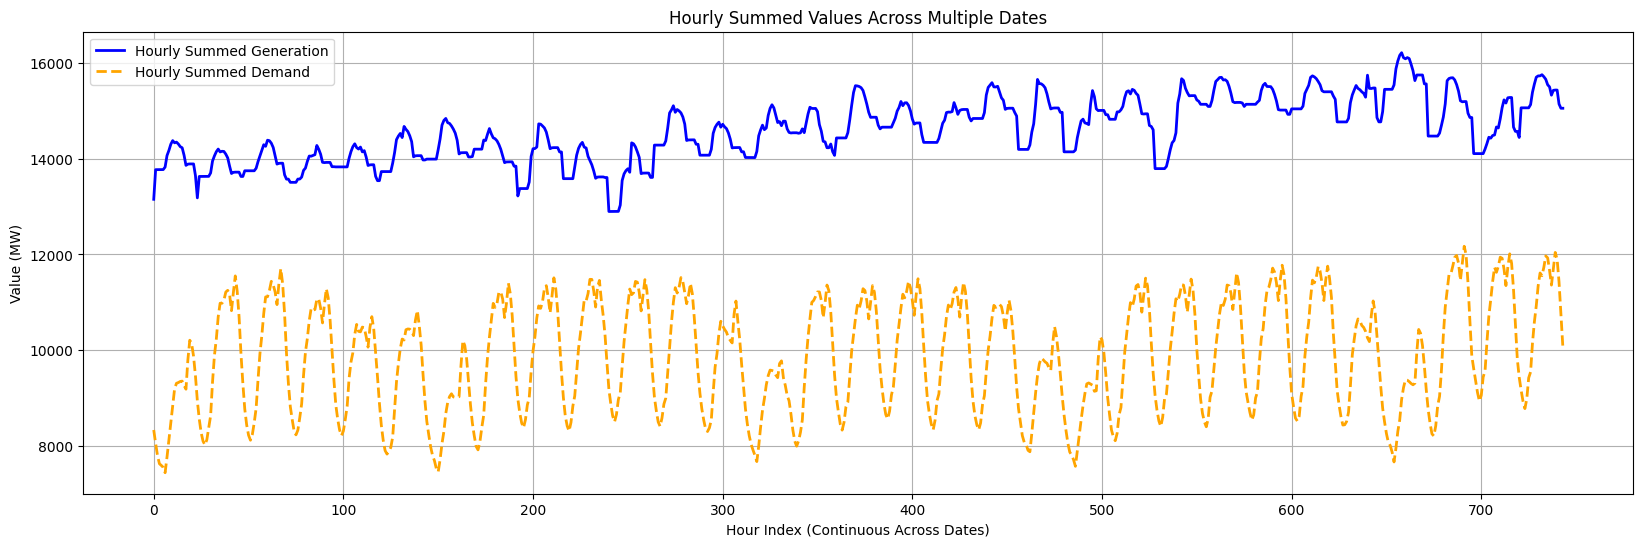

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

# Graficar la serie de generación/demanda
plt.plot(final_series, label='Hourly Summed Generation', color='blue', linewidth=2)

# Graficar la serie de demanda
plt.plot(DEM_SIN_series, label='Hourly Summed Demand', color='orange', linewidth=2, linestyle='--')

# Personalizar etiquetas y título
plt.xlabel('Hour Index (Continuous Across Dates)')
plt.ylabel('Value (MW)')
plt.title('Hourly Summed Values Across Multiple Dates')
plt.grid(True)

# Añadir leyenda para identificar cada línea
plt.legend()

# Mostrar la gráfica
plt.show()


In [36]:
pd.reset_option('display.max_rows')

# Escenarios de hidro. Modelacion de los precios con base en la Resolución 69 2002 Creg

In [37]:
escenario = 'Media'

if escenario == 'Baja':
    perfil_hidro =pd.read_excel('perfil_hidro_baja.xlsx')
elif escenario == 'Media':
    perfil_hidro = pd.read_excel('perfil_hidro_media.xlsx')
else:
    perfil_hidro = pd.read_excel('perfil_hidro_alta.xlsx')    

In [38]:
TERMICAS = df_generacion[df_generacion['Values_Type'] == 'TERMICA']
TERMICAS = TERMICAS[TERMICAS['Values_EnerSource'] != 'JET-A1'] # Demasiado costoso y solo un generador
precio_termicas = precio[precio['Values_code'].isin(TERMICAS['Values_Code'])]

precio_hora_hidros = pd.Series(dtype=float)
for dia in precio_termicas['Date'].unique():
     uno = precio_termicas[precio_termicas['Date'] == dia]
     uno = uno.drop(['Id', 'Values_code', 'Date'], axis=1)

     if escenario == 'Baja':
          uno = uno.max() * 0.9
     elif escenario == 'Media':
          uno = uno.min() * 0.9#(uno.max() - uno.min())/2
     else:
          uno = uno.min() * 0.5
 
     uno = pd.Series(uno).reset_index(drop=True)
     precio_hora_hidros = pd.concat([precio_hora_hidros, uno], ignore_index=True)
precio_hora_hidros = pd.Series(precio_hora_hidros.values, index=horas)
precio_hora_hidros

2024-07-01 00:00:00    78.3
2024-07-01 01:00:00    78.3
2024-07-01 02:00:00    78.3
2024-07-01 03:00:00    78.3
2024-07-01 04:00:00    78.3
                       ... 
2024-07-31 19:00:00    78.3
2024-07-31 20:00:00    78.3
2024-07-31 21:00:00    78.3
2024-07-31 22:00:00    78.3
2024-07-31 23:00:00    78.3
Freq: h, Length: 744, dtype: float64

In [39]:
termicas_tmin = pd.read_excel('termicas_tmin.xlsx')
termicas_tmin

Values_Code         Values_Name Values_Type   Values_RecType  \
0         3ENA            TESORITO     TERMICA           NORMAL   
1         CTG1         CARTAGENA 1     TERMICA           NORMAL   
2         CTG2         CARTAGENA 2     TERMICA           NORMAL   
3         CTG3         CARTAGENA 3     TERMICA           NORMAL   
4         GE32          GECELCA 32     TERMICA           NORMAL   
5         GEC3           GECELCA 3     TERMICA           NORMAL   
6         MRL1      MERILECTRICA 1     TERMICA           NORMAL   
7         PPA1             PAIPA 1     TERMICA           NORMAL   
8         PPA2             PAIPA 2     TERMICA           NORMAL   
9         PPA3             PAIPA 3     TERMICA           NORMAL   
10        PPA4             PAIPA 4     TERMICA           NORMAL   
11        PRG1      PROELECTRICA 1     TERMICA           NORMAL   
12        PRG2      PROELECTRICA 2     TERMICA           NORMAL   
13        TBQ3      BARRANQUILLA 3     TERMICA           NORMAL   
14        TBQ4      BARRANQUILLA 4     TERMICA           NORMAL   
15        TBST           TEBSAB CC     TERMICA  CICLO COMBINADO   
16        TCBE   TERMOCARIBE III 1     TERMICA           NORMAL   
17        TCDT  TERMOCANDELARIA CC     TERMICA  CICLO COMBINADO   
18        TDR1       TERMODORADA 1     TERMICA           NORMAL   
19        TEC1      TERMOEMCALI CC     TERMICA  CICLO COMBINADO   
20        TFL1         FLORES I CC     TERMICA  CICLO COMBINADO   
21        TFL4         FLORES 4 CC     TERMICA  CICLO COMBINADO   
22        TGJ1           GUAJIRA 1     TERMICA           NORMAL   
23        TGJ2           GUAJIRA 2     TERMICA           NORMAL   
24        TRM1      TERMOCENTRO CC     TERMICA  CICLO COMBINADO   
25        TRN1          TERMONORTE     TERMICA           NORMAL   
26        TSJ1          TASAJERO 1     TERMICA           NORMAL   
27        TSJ2          TASAJERO 2     TERMICA           NORMAL   
28        TSR1      TERMOSIERRA CC     TERMICA  CICLO COMBINADO   
29        TVL1       TERMOVALLE CC     TERMICA  CICLO COMBINADO   
30        TYP1        TERMOYOPAL 1     TERMICA           NORMAL   
31        TYP2        TERMOYOPAL 2     TERMICA           NORMAL   
32        TYP3       TERMOYOPAL G3     TERMICA           NORMAL   
33        TYP4       TERMOYOPAL G4     TERMICA           NORMAL   
34        TYP5       TERMOYOPAL G5     TERMICA           NORMAL   
35        ZPA2           ZIPAEMG 2     TERMICA           NORMAL   
36        ZPA3           ZIPAEMG 3     TERMICA           NORMAL   
37        ZPA4           ZIPAEMG 4     TERMICA           NORMAL   
38        ZPA5           ZIPAEMG 5     TERMICA           NORMAL   

   Values_CompanyCode Values_EnerSource Values_OperStartdate  \
0                EPSG               GAS           2022-09-13   
1                NTCG       COMBUSTOLEO           1995-07-20   
2                NTCG       COMBUSTOLEO           1980-01-01   
3                NTCG       COMBUSTOLEO           1980-01-01   
4                GECG            CARBON           2018-09-28   
5                GECG            CARBON           2015-09-17   
6                EPSG               GAS           1998-02-05   
7                HIMG            CARBON           1963-01-01   
8                HIMG            CARBON           1975-01-01   
9                HIMG            CARBON           1982-05-06   
10               SOCG            CARBON           1999-01-08   
11               PRIG               GAS           1993-07-01   
12               PRIG               GAS           1993-07-01   
13               TBSG               GAS           1980-01-01   
14               TBSG               GAS           1980-01-01   
15               TBSG               GAS           1989-10-21   
16               TCBG               GLP           2024-03-21   
17               TCIG               GAS           2023-10-27   
18               EPMG            JET-A1           1997-08-11   
19               TEMG              ACPM   

In [40]:

# Filtrar los códigos únicos de generación solar
solares_hist = df_generacion[df_generacion['Values_EnerSource'] == 'RAD SOLAR']['Values_Code'].unique()

# Filtrar el DataFrame precio para incluir solo las filas cuyos códigos estén en solares_hist
precio_filtrado = precio[precio['Values_code'].isin(solares_hist)]

# Resultado filtrado
# Eliminar la columna 'Id' del DataFrame precio_filtrado
precio_filtrado = precio_filtrado.drop(['Id', 'Values_code', 'Date'], axis=1)
precio_prom_sol = precio_filtrado.mean()
print(precio_prom_sol)
precio_prom_sol = np.tile(precio_prom_sol.values, len(DEMANDA_XM))
precio_sol = pd.Series(precio_prom_sol, index=horas)




Values_Hour01    143.878882
Values_Hour02    143.878882
Values_Hour03    143.878882
Values_Hour04    143.878882
Values_Hour05    143.878882
Values_Hour06    143.878882
Values_Hour07    143.878882
Values_Hour08    143.878882
Values_Hour09    143.878882
Values_Hour10    143.878882
Values_Hour11    143.878882
Values_Hour12    143.878882
Values_Hour13    143.878882
Values_Hour14    143.878882
Values_Hour15    143.878882
Values_Hour16    143.878882
Values_Hour17    143.878882
Values_Hour18    143.878882
Values_Hour19    143.878882
Values_Hour20    143.878882
Values_Hour21    143.878882
Values_Hour22    143.878882
Values_Hour23    143.878882
Values_Hour24    143.878882
dtype: float64


In [41]:
if escenario != 'Baja':
     precio_sol = precio_hora_hidros * 0.77
precio_sol

2024-07-01 00:00:00    60.291
2024-07-01 01:00:00    60.291
2024-07-01 02:00:00    60.291
2024-07-01 03:00:00    60.291
2024-07-01 04:00:00    60.291
                        ...  
2024-07-31 19:00:00    60.291
2024-07-31 20:00:00    60.291
2024-07-31 21:00:00    60.291
2024-07-31 22:00:00    60.291
2024-07-31 23:00:00    60.291
Freq: h, Length: 744, dtype: float64

In [42]:
# Filtrar los códigos únicos de generación solar
GLP_hist = df_generacion[df_generacion['Values_EnerSource'] == 'GLP']['Values_Code'].unique()

# Filtrar el DataFrame precio para incluir solo las filas cuyos códigos estén en solares_hist
precio_filtrado = precio[precio['Values_code'].isin(GLP_hist)]

# Resultado filtrado
# Eliminar la columna 'Id' del DataFrame precio_filtrado
precio_filtrado = precio_filtrado.drop(['Id', 'Values_code', 'Date'], axis=1)
precio_prom_GLP = precio_filtrado.mean()
print(precio_prom_GLP)
precio_prom_GLP = np.tile(precio_prom_GLP.values, len(DEMANDA_XM))
precio_GLP = pd.Series(precio_prom_GLP, index=horas)

Values_Hour01    791.612904
Values_Hour02    791.612904
Values_Hour03    791.612904
Values_Hour04    791.612904
Values_Hour05    791.612904
Values_Hour06    791.612904
Values_Hour07    791.612904
Values_Hour08    791.612904
Values_Hour09    791.612904
Values_Hour10    791.612904
Values_Hour11    791.612904
Values_Hour12    791.612904
Values_Hour13    791.612904
Values_Hour14    791.612904
Values_Hour15    791.612904
Values_Hour16    791.612904
Values_Hour17    791.612904
Values_Hour18    791.612904
Values_Hour19    791.612904
Values_Hour20    791.612904
Values_Hour21    791.612904
Values_Hour22    791.612904
Values_Hour23    791.612904
Values_Hour24    791.612904
dtype: float64


In [43]:
network.remove("Generator", network.generators.index)

In [44]:
df_generacion['Values_EnerSource'].unique()

array(['AGUA', 'RAD SOLAR', 'GAS', 'COMBUSTOLEO', 'CARBON', 'GLP',
       'JET-A1', 'ACPM'], dtype=object)

In [45]:
perfil_hidro_mod = np.tile(perfil_hidro['Promedio'].values, len(DEMANDA_XM))
perfil_hidro_series = pd.Series(perfil_hidro_mod, index=horas)
perfil_hidro_series

2024-07-01 00:00:00    0.777408
2024-07-01 01:00:00    0.777520
2024-07-01 02:00:00    0.777699
2024-07-01 03:00:00    0.777763
2024-07-01 04:00:00    0.777747
                         ...   
2024-07-31 19:00:00    0.801356
2024-07-31 20:00:00    0.801184
2024-07-31 21:00:00    0.790151
2024-07-31 22:00:00    0.782204
2024-07-31 23:00:00    0.780886
Freq: h, Length: 744, dtype: float64

In [46]:
df_generacion

Values_Code          Values_Name Values_Type Values_RecType  \
0         2QEK             SALTO II  HIDRAULICA   FILO DE AGUA   
1         3DDT  LATAM SOLAR LA LOMA       SOLAR         NORMAL   
2         3ENA             TESORITO     TERMICA         NORMAL   
3         3HF5            FUNDACION       SOLAR         NORMAL   
4         3IRX       PORTON DEL SOL       SOLAR         NORMAL   
..         ...                  ...         ...            ...   
72        URA1                 URRA  HIDRAULICA         NORMAL   
73        ZPA2            ZIPAEMG 2     TERMICA         NORMAL   
74        ZPA3            ZIPAEMG 3     TERMICA         NORMAL   
75        ZPA4            ZIPAEMG 4     TERMICA         NORMAL   
76        ZPA5            ZIPAEMG 5     TERMICA         NORMAL   

   Values_CompanyCode Values_EnerSource Values_OperStartdate  \
0                ENDG              AGUA           2014-06-25   
1                ENDG         RAD SOLAR           2024-06-24   
2                EPSG               GAS           2022-09-13   
3                ENDG         RAD SOLAR           2023-02-28   
4                PDSG         RAD SOLAR           2024-03-08   
..                ...               ...                  ...   
72               EMUG              AGUA           2000-02-14   
73               ENDG            CARBON           1964-01-01   
74               ENDG            CARBON           1976-01-01   
75               ENDG            CARBON           1981-04-01   
76               ENDG            CARBON           1985-12-14   

    Values_Capacidad (MW)       Values_Bus  Values_OperStartyear  
0                      35  NUEVA ESPERANZA                  2014  
1                     150          LA LOMA                  2024  
2                     200         TESORITO                  2022  
3                      90        FUNDACION                  2023  
4                     102   PORTON DEL SOL                  2024  
..                    ...              ...                   ...  
72                    338             URRA                  2000  
73                     36           BACATA                  1964  
74                     63           BACATA                  1976  
75                     64           BACATA                  1981  
76                     63           BACATA                  1985  

[77 rows x 10 columns]

In [47]:
# Se agregan los generadores a la red de Pypsa
for _, row in df_generacion.iterrows():

    capacidad = row['Values_Capacidad (MW)']*1000
    codigo = row['Values_Code']
    recurso = row['Values_Type']
    tipo = row['Values_EnerSource']

    dias = pd.date_range(start=FECHAS_XM[0], periods=len(FECHAS_XM), freq="d")    
    precio_gen = precio[precio['Values_code']==codigo]
    precio_gen.set_index('Date', inplace=True)
    precio_gen = precio_gen.drop(['Values_code'], axis=1)
    precio_gen = precio_gen.drop(['Id'], axis=1)
    precio_gen = precio_gen.reindex(dias, fill_value=1000000)
    precio_gen=precio_gen.stack().reset_index(drop=True) 
    precio_gen = precio_gen#*1000 #COP/MWh

    temp_gen = GENE_XM[GENE_XM['Values_code']==codigo]
    
    temp_gen.set_index('Date', inplace=True)
    temp_gen = temp_gen.drop(['Values_code'], axis=1)
    temp_gen = temp_gen.drop(['Id'], axis=1)
    temp_gen = temp_gen.reindex(dias, fill_value=0)
    temp_gen= temp_gen.stack().reset_index(drop=True)
    temp_gen = temp_gen/capacidad#.values


    if recurso == 'HIDRAULICA':
        costo_marg = pd.Series(precio_hora_hidros.values, index=horas)
        temp_gen = perfil_hidro_series
    elif recurso == "SOLAR":
        costo_marg = precio_sol
    else:
        costo_marg = pd.Series(precio_gen.values, index=horas)

    if tipo == 'GLP':
        costo_marg = precio_GLP

    #tipo = row['Values_Type']
    if recurso == "TERMICA":
        t_min = termicas_tmin[termicas_tmin['Values_Code'] == codigo]['TIEMPO MÍNIMO DEGENERACIÓN-TMG[Horas]'].values[0]
    else:
        t_min = 0

    network.add("Generator",
                    name=row['Values_Name'],
                    bus=row['Values_Bus'],
                    p_nom=row['Values_Capacidad (MW)'],
                    type=row['Values_Type'],
                    carrier=row['Values_EnerSource'],
                    #build_year = row['Values_OperStartyear'],
                    p_max_pu = pd.Series(temp_gen.values, index=horas),#(pd.Series(temp_gen.values, index=horas)/pd.Series(temp_gen.values, index=horas).max()),
                    #p_min_pu = pd.Series(temp_gen2.values, index=horas),#0.9*pd.Series(temp_gen.values, index=horas),#0.9*(pd.Series(temp_gen.values, index=horas)/pd.Series(temp_gen.values, index=horas).max()),
                    marginal_cost = costo_marg, #pd.Series(precio_gen.values, index=horas)
                    committable = True,
                    min_up_time = t_min
                    )    

In [48]:
network.generators['min_up_time']

Generator
SALTO II                0
LATAM SOLAR LA LOMA     0
TESORITO                3
FUNDACION               0
PORTON DEL SOL          0
                       ..
URRA                    0
ZIPAEMG 2              72
ZIPAEMG 3              72
ZIPAEMG 4              72
ZIPAEMG 5              72
Name: min_up_time, Length: 77, dtype: int32

In [49]:
# Ensure 'p_nom' is aligned with the columns in 'generators_t.p_max_pu'
p_nom_aligned = network.generators['p_nom'].reindex(network.generators_t.p_max_pu.columns)

potential_generation = network.generators_t.p_max_pu * p_nom_aligned
potential_generation_min = network.generators_t.p_min_pu * p_nom_aligned

total_potential_generation_per_snapshot = potential_generation.sum(axis=1)
total_potential_generation_per_snapshot_min = potential_generation_min.sum(axis=1)


In [50]:
total_demand = network.loads_t.p_set.sum(axis=1)  # Summing demand across all loads for each time step
#total_generation = network.generators_t.p.sum(axis=1)  # Summing generation across all generators for each time step

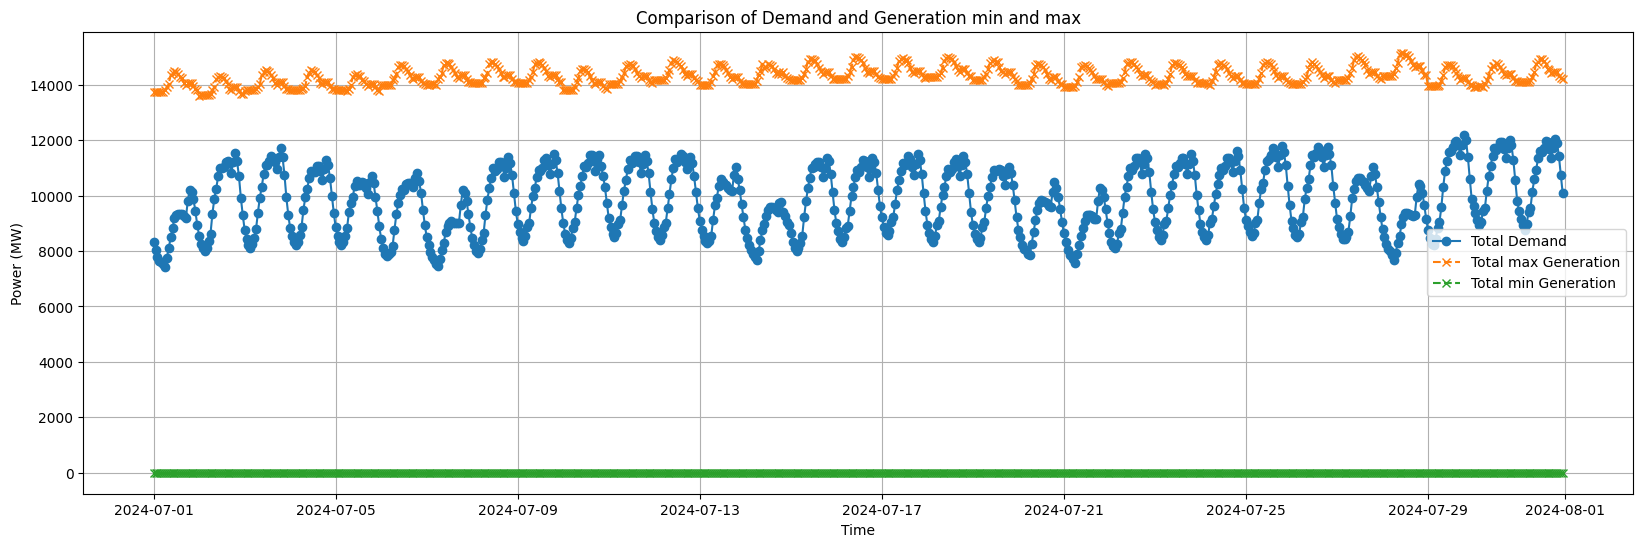

In [51]:
import matplotlib.pyplot as plt
last = 0
# Slice to get the last 100 values
last_100_snapshots = network.snapshots[-last:]
last_100_demand = total_demand[-last:]
last_100_generation = total_potential_generation_per_snapshot[-last:]
last_100_generation_min = total_potential_generation_per_snapshot_min[-last:]

plt.figure(figsize=(20, 6))
plt.plot(last_100_snapshots, last_100_demand, label='Total Demand', linestyle='-', marker='o')
plt.plot(last_100_snapshots, last_100_generation, label='Total max Generation', linestyle='--', marker='x')
plt.plot(last_100_snapshots, last_100_generation_min, label='Total min Generation', linestyle='--', marker='x')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Comparison of Demand and Generation min and max')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
max = network.generators_t['p_max_pu'].sum(axis=1)
mini = network.generators_t['p_min_pu'].sum(axis=1)

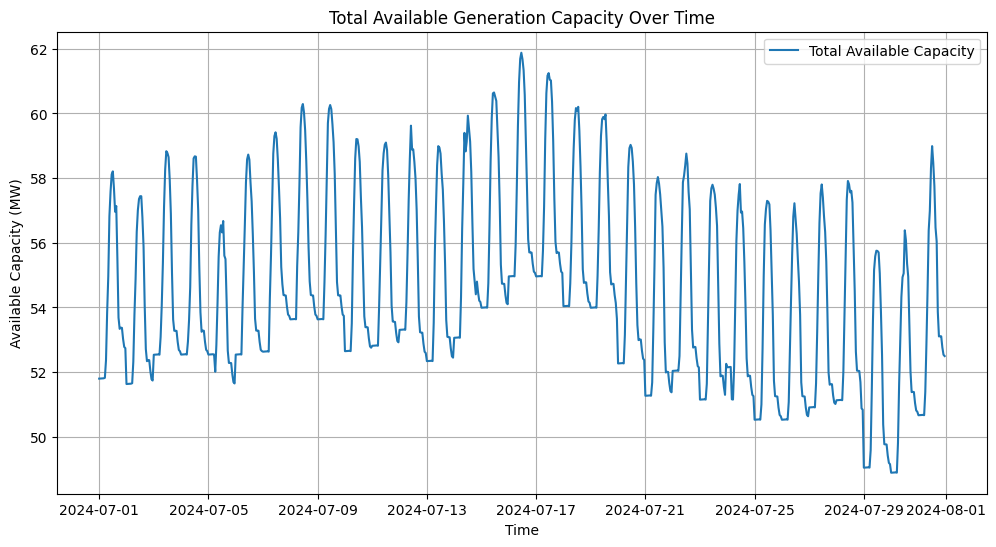

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(network.snapshots, max, label='Total Available Capacity')
plt.xlabel('Time')
plt.ylabel('Available Capacity (MW)')
plt.title('Total Available Generation Capacity Over Time')
plt.grid(True)
plt.legend()
plt.show()


## proyectos de generacion que hacen falta para el escenario base de la UPME

In [54]:
df_generacion[df_generacion['Values_Type'] == 'SOLAR']

Values_Code            Values_Name Values_Type Values_RecType  \
1         3DDT    LATAM SOLAR LA LOMA       SOLAR         NORMAL   
3         3HF5              FUNDACION       SOLAR         NORMAL   
4         3IRX         PORTON DEL SOL       SOLAR         NORMAL   
5         3IZ6  PARQUE SOLAR LA UNION       SOLAR         NORMAL   
16        EPFV                EL PASO       SOLAR         NORMAL   
27        MATA                LA MATA       SOLAR         NORMAL   
60        TPUY     PARQUE SOLAR TEPUY       SOLAR         NORMAL   

   Values_CompanyCode Values_EnerSource Values_OperStartdate  \
1                ENDG         RAD SOLAR           2024-06-24   
3                ENDG         RAD SOLAR           2023-02-28   
4                PDSG         RAD SOLAR           2024-03-08   
5                SLUG         RAD SOLAR           2024-06-19   
16               ENDG         RAD SOLAR           2024-03-23   
27               SLMG         RAD SOLAR           2024-06-27   
60               EPMG         RAD SOLAR           2024-06-12   

    Values_Capacidad (MW)      Values_Bus  Values_OperStartyear  
1                     150         LA LOMA                  2024  
3                      90       FUNDACION                  2023  
4                     102  PORTON DEL SOL                  2024  
5                     100  MONTERIA (ISA)                  2024  
16                     68         LA LOMA                  2024  
27                     80           OCAÑA                  2024  
60                     83          PURNIO                  2024

In [56]:
df_proyectos = pd.read_excel('Gen_CsoBase.xlsx')
df_proyectos

Proyecto     CEN      Fecha Tipo/Fuente  .Bus.  .PotIns  \
0        S_Caracoli    50.0 2024-01-01       Solar    601     50.0   
1        S_Sunnorte    35.0 2024-01-01       Solar    459     35.0   
2         S_Guayepo   370.0 2024-07-11       Solar    536    370.0   
3      S_ParqueUrra    19.9 2024-07-31       Solar    560     19.9   
4      E_ParqueAlph   212.0 2025-11-30      Eolica    496    212.0   
5      E_ParqueBeta   280.0 2025-11-30      Eolica    636    280.0   
6        S_Escobal6    99.0 2026-07-14       Solar    515     99.0   
7   E_Camelia         250.0 2026-07-14      Eolica    572    250.0   
8       E_Windpeshi   200.0 2026-07-14      Eolica    570    200.0   
9      Hidroituango  1200.0 2026-07-14  HIDRAULICA     24   1200.0   
10            E_JK1   180.0 2026-05-18      Eolica    494    180.0   
11      S_Andromeda   100.0 2024-11-29       Solar    575    100.0   
12        E_Ahumado    50.0 2024-12-31      Eolica    586     50.0   

    nodo_proyecto     Nodos_XM  nodo_xm_asociado  
0             601     CARACOLI               137  
1             459        OCAÑA               293  
2             536        CHINU               535  
3             560         URRA               472  
4             496     EL COPEY                 2  
5             636     EL COPEY                 2  
6             515      BETANIA                48  
7             572     EL COPEY                 2  
8             570  CUESTECITAS               148  
9              24    ANTIOQUIA                24  
10            494     EL COPEY                 2  
11            575      BOLIVAR               420  
12            586  CUESTECITAS               148

In [57]:
print(df_generacion[df_generacion['Values_EnerSource'] == "RAD SOLAR"]['Values_Capacidad (MW)'].sum())
df_generacion[df_generacion['Values_EnerSource'] == "RAD SOLAR"]

673


Values_Code            Values_Name Values_Type Values_RecType  \
1         3DDT    LATAM SOLAR LA LOMA       SOLAR         NORMAL   
3         3HF5              FUNDACION       SOLAR         NORMAL   
4         3IRX         PORTON DEL SOL       SOLAR         NORMAL   
5         3IZ6  PARQUE SOLAR LA UNION       SOLAR         NORMAL   
16        EPFV                EL PASO       SOLAR         NORMAL   
27        MATA                LA MATA       SOLAR         NORMAL   
60        TPUY     PARQUE SOLAR TEPUY       SOLAR         NORMAL   

   Values_CompanyCode Values_EnerSource Values_OperStartdate  \
1                ENDG         RAD SOLAR           2024-06-24   
3                ENDG         RAD SOLAR           2023-02-28   
4                PDSG         RAD SOLAR           2024-03-08   
5                SLUG         RAD SOLAR           2024-06-19   
16               ENDG         RAD SOLAR           2024-03-23   
27               SLMG         RAD SOLAR           2024-06-27   
60               EPMG         RAD SOLAR           2024-06-12   

    Values_Capacidad (MW)      Values_Bus  Values_OperStartyear  
1                     150         LA LOMA                  2024  
3                      90       FUNDACION                  2023  
4                     102  PORTON DEL SOL                  2024  
5                     100  MONTERIA (ISA)                  2024  
16                     68         LA LOMA                  2024  
27                     80           OCAÑA                  2024  
60                     83          PURNIO                  2024

## Perfiles nuevos generadores

In [59]:
#perfiles nuevos generadores
perfil_solar = pd.read_excel('perfil_solar_2023_4.xlsx')
perfil_eolico = pd.read_excel('Perfil_Eolicas3.xlsx')

In [61]:
perfil_solar

Unnamed: 0  Perfil pu
0   Values_Hour01   0.000000
1   Values_Hour02   0.000000
2   Values_Hour03   0.000000
3   Values_Hour04   0.000000
4   Values_Hour05   0.000000
5   Values_Hour06   0.002256
6   Values_Hour07   0.114080
7   Values_Hour08   0.338249
8   Values_Hour09   0.539734
9   Values_Hour10   0.647682
10  Values_Hour11   0.702291
11  Values_Hour12   0.721536
12  Values_Hour13   0.719527
13  Values_Hour14   0.696621
14  Values_Hour15   0.644279
15  Values_Hour16   0.537218
16  Values_Hour17   0.331729
17  Values_Hour18   0.099884
18  Values_Hour19   0.001798
19  Values_Hour20   0.000000
20  Values_Hour21   0.000000
21  Values_Hour22   0.000000
22  Values_Hour23   0.000000
23  Values_Hour24   0.000000

In [62]:
perfil_eolico['Perfil pu'].mean()

0.3436509998528153

### Perfil solar

In [63]:
perfil_anual_sol = np.tile(perfil_solar['Perfil pu'].values, len(DEMANDA_XM))  # Repetir el perfil LOS DIAS que estan en demanda xm (61)
perfil_solar_pu = pd.Series(perfil_anual_sol, index=horas)
perfil_solar_pu.mean()

0.2540367880742416

### Perfil eolico

In [64]:
perfil_anual_eol = np.tile(perfil_eolico['Perfil pu'].values, len(DEMANDA_XM))  # Repetir el perfil LOS DIAS que estan en demanda xm (61)
perfil_eolico_pu= pd.Series(perfil_anual_eol, index=horas)
perfil_eolico_pu.mean()

0.34365099985281533

In [65]:
# Verifica si todos los nombres comienzan con E_ o S_
valid_generators = df_proyectos['Proyecto'].str.startswith('E_') | df_proyectos['Proyecto'].str.startswith('S_')

if not valid_generators.all():
    invalid_rows = df_proyectos[~valid_generators]  # Filtra las filas inválidas
    print("Los siguientes generadores no tienen nombres válidos:")
    print(invalid_rows)
    #raise ValueError("Algunos generadores no comienzan con 'E_' o 'S_'. Corrige los nombres antes de continuar.")
else:
    print("Todos los generadores tienen nombres válidos.")


Los siguientes generadores no tienen nombres válidos:
       Proyecto     CEN      Fecha Tipo/Fuente  .Bus.  .PotIns  nodo_proyecto  \
9  Hidroituango  1200.0 2026-07-14  HIDRAULICA     24   1200.0             24   

    Nodos_XM  nodo_xm_asociado  
9  ANTIOQUIA                24  


In [66]:
for _, row in df_proyectos.iterrows():
    # Determina el p_max_pu según el tipo de generador
    if row['Proyecto'].startswith('S_'):  # Generador solar
        p_max_pu = perfil_solar_pu # pd.Series(solar_profile.values, index=horas)  # Define solar_profile previamente
        precio_mar = precio_sol
        recurso = "RAD SOLAR"
        tipo = "SOLAR"
    elif row['Proyecto'].startswith('E_'):  # Generador eólico
        p_max_pu = perfil_eolico_pu #pd.Series(perfil_eolico_pu.values, index=horas)  # Define wind_profile previamente
        precio_mar = precio_sol * 1.2
        recurso = "EOLICA"
        tipo = 'EOLICA'
    else:
        p_max_pu = perfil_hidro_series #pd.Series(perfil_eolico_pu.values, index=horas)  # Define wind_profile previamente
        precio_mar = pd.Series(precio_hora_hidros.values, index=horas)
        recurso = "AGUA"
        tipo = "HIDRAULICA"

    # Añade el generador al network
    network.add(
        "Generator",
        name=row['Proyecto'],
        bus=row['Nodos_XM'],
        p_nom=row['.PotIns'],
        type=tipo,
        carrier=recurso, #row['Tipo/Fuente'],
        p_max_pu=p_max_pu,
        marginal_cost = precio_mar #pd.Series(precio_gen.values, index=horas)
    )


In [67]:
#network.generators['marginal_cost'] = 50
network.optimize()

Index(['HIDROSOGAMOSO', 'ANCON SUR (EPM)', 'PORTON DEL SOL', 'RIO CORDOBA',
       'TOLUVIEJO', 'ALTO ANCHICAYA', 'EL COPEY', 'ALTAMIRA',
       'LA SIERRA (ANTIOQUIA)', 'BALSILLAS',
       ...
       'SAN MATEO (BOGOTA)', 'TERMOCANDELARIA', 'MONTERIA (ISA)', 'COMUNEROS',
       'CASA MAQUINAS SAN CARLOS', 'EL BOSQUE', 'SAN BERNARDINO', 'BANADIA',
       'HELICONIA', 'TOLEDO'],
      dtype='object', name='Bus', length=125)


Index(['Line_0', 'Line_2', 'Line_3', 'Line_4', 'Line_5', 'Line_6', 'Line_7',
       'Line_8', 'Line_10', 'Line_11',
       ...
       'Line_257', 'Line_258', 'Line_259', 'Line_260', 'Line_261', 'Line_262',
       'Line_263', 'Line_265', 'Line_267', 'Line_268'],
      dtype='object', name='Line', length=193)
Index(['SALTO II', 'LATAM SOLAR LA LOMA', 'TESORITO', 'FUNDACION',
       'PORTON DEL SOL', 'PARQUE SOLAR LA UNION', 'ALBAN', 'BETANIA', 'CHIVOR',
       'CARLOS LLERAS', 'CALIMA', 'CARTAGENA 1', 'CARTAGENA 2', 'CARTAGENA 3',
       'CUCUANA', 'DARIO VALENCIA SAMPER', 'EL PASO', 'ESMERALDA',
       'GECELCA 32', 'GECELCA 3', 'GUATAPE', 'GUATRON', 'GUAVIO',
       'ESCUELA DE MINAS', 'MIEL I', 'JAGUAS', 'LA TASAJERA', 'LA MATA',
       'AMOYA LA ESPERANZA', 'MERILECTRICA 1', 'ITUANGO', 'PAGUA', 'PLAYAS',
       'PAIPA 1', 'PAIPA 2', 'PAIPA 3', 'PAIPA 4', 'PORCE II', 'PORCE III',
       'PRADO', 'PROELECTRICA 1', 'PROELECTRICA 2', 'EL QUIMBO', 'RIO PIEDRAS',
       'SALVAJINA', 'SAN M

('ok', 'optimal')

## Pruebas

In [68]:
total_demand = network.loads_t.p_set.sum(axis=1)  # Summing demand across all loads for each time step
total_generation = network.generators_t.p.sum(axis=1)  # Summing generation across all generators for each time step


In [69]:
network.generators['p_nom'].sum()

21842.9

In [70]:
total_demand.max()/network.generators['p_nom'].sum()

0.5572048974718155

In [71]:
imbalance = total_generation - total_demand
imbalance.min()

-6.4956111600622535e-09

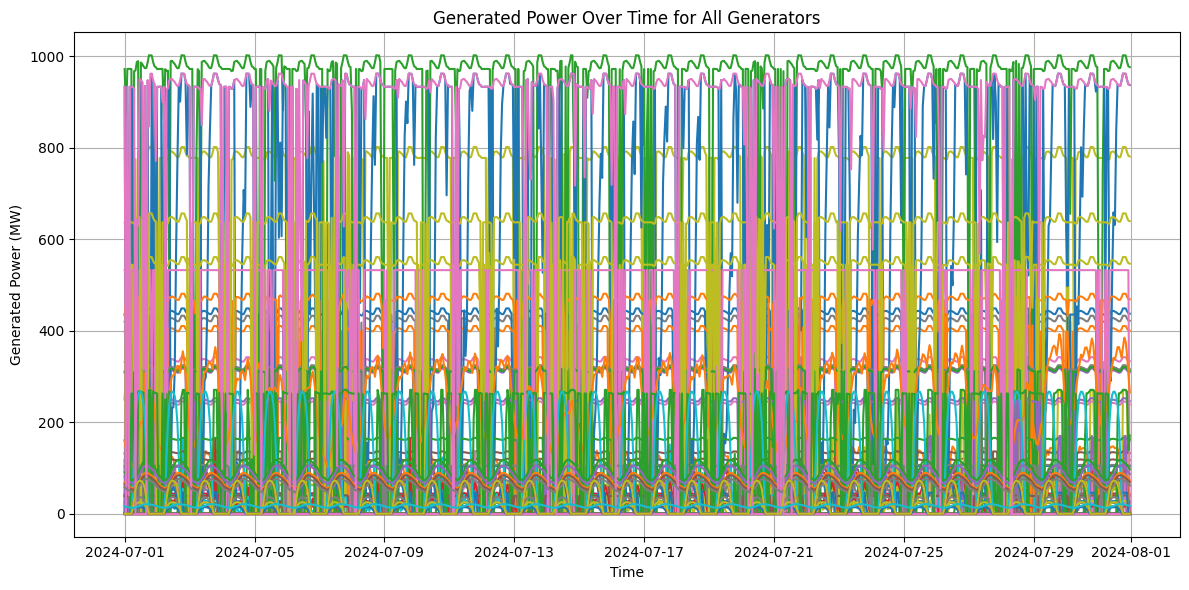

In [72]:
import matplotlib.pyplot as plt

# Assuming 'network' is your PyPSA network object
# Plot the generated power for all generators
plt.figure(figsize=(12, 6))

# Loop through each generator and plot its generated power over time
for generator in network.generators.index:
    plt.plot(network.snapshots, network.generators_t.p[generator], label=generator)

plt.xlabel('Time')
plt.ylabel('Generated Power (MW)')
plt.title('Generated Power Over Time for All Generators')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend position as needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
network.generators_t.p.iloc[0, :]

Generator
SALTO II                27.209287
LATAM SOLAR LA LOMA     -0.000000
TESORITO                -0.000000
FUNDACION               -0.000000
PORTON DEL SOL          -0.000000
                          ...    
E_Windpeshi             64.823505
Hidroituango           932.889825
E_JK1                   58.341155
S_Andromeda             -0.000000
E_Ahumado               16.205876
Name: 2024-07-01 00:00:00, Length: 90, dtype: float64

<Figure size 1200x800 with 0 Axes>

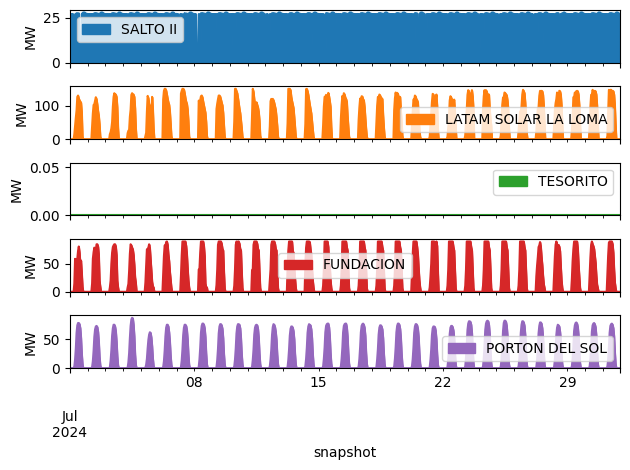

In [74]:
plt.figure(figsize=(12, 8))
network.generators_t.p.iloc[:, 0:5].plot.area(subplots=True, ylabel="MW")
plt.tight_layout()

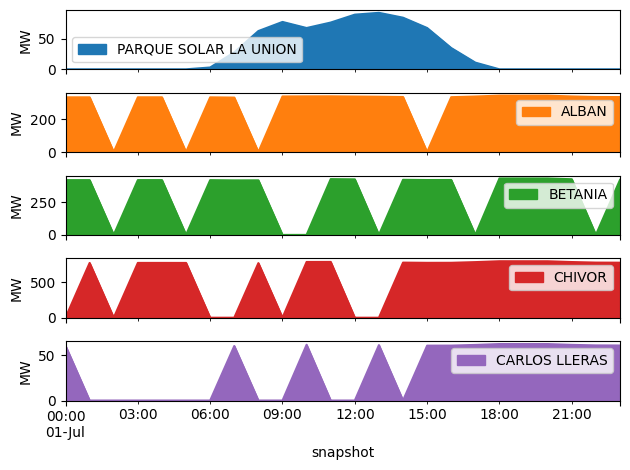

In [75]:
network.generators_t.p.iloc[0:24, 5:10].plot.area(subplots=True, ylabel="MW")
plt.tight_layout()

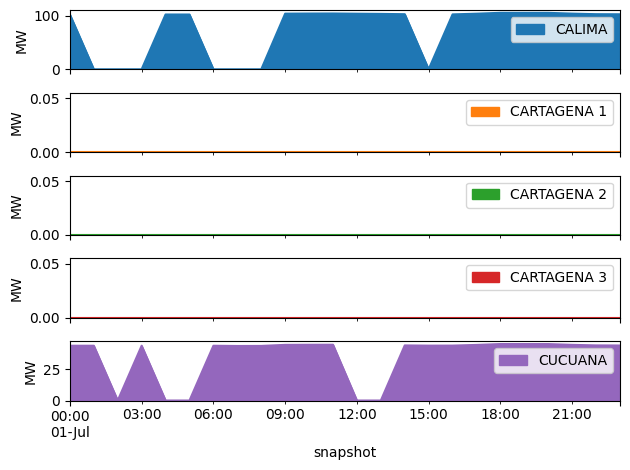

In [76]:
network.generators_t.p.iloc[0:24, 10:15].plot.area(subplots=True, ylabel="MW")
plt.tight_layout()

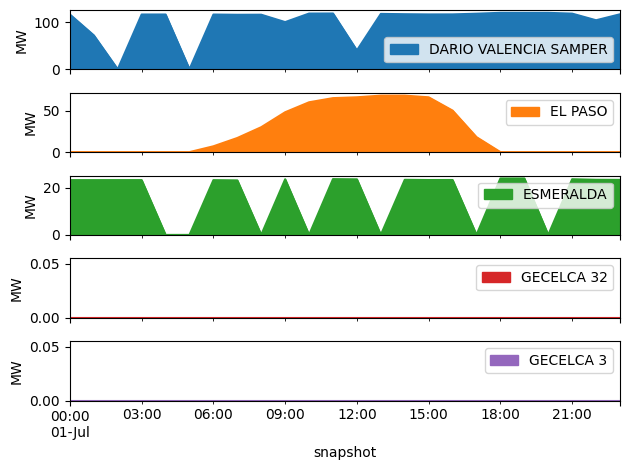

In [77]:
network.generators_t.p.iloc[0:24, 15:20].plot.area(subplots=True, ylabel="MW")
plt.tight_layout()

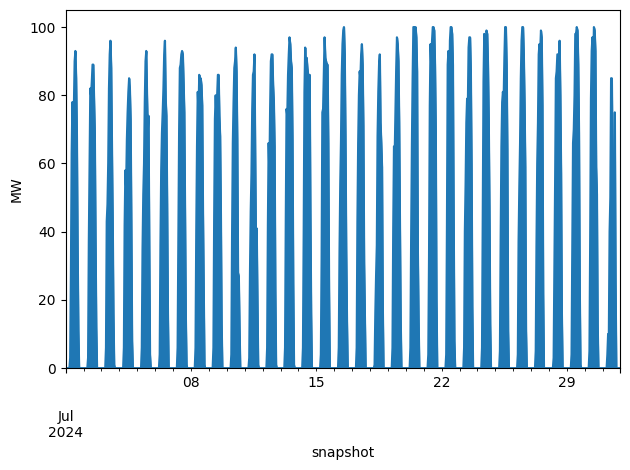

In [78]:
network.generators_t.p.iloc[:,5].plot.area(subplots=True, ylabel="MW")
plt.tight_layout()

# Graficas

## No sirven mucho

In [79]:
import matplotlib.pyplot as plt
loading_percent = network.lines_t.p0.abs() / network.lines.s_nom * 100  # Calcula la cargabilidad como % de capacidad nominal
loading_percent

Line                   Line_0     Line_2     Line_3     Line_4     Line_5  \
snapshot                                                                    
2024-07-01 00:00:00  2.337529  34.076288  13.208269  13.485045   9.216336   
2024-07-01 01:00:00  7.217157  38.806306  23.813734  14.323413   8.906897   
2024-07-01 02:00:00  8.065314  10.815145  19.733503   1.441478   8.620954   
2024-07-01 03:00:00  5.939356  39.975599  25.001572  14.016211   8.434748   
2024-07-01 04:00:00  4.230620  36.297420  19.582432  12.263671   8.395768   
...                       ...        ...        ...        ...        ...   
2024-07-31 19:00:00  0.322807  30.195663   4.392978  21.301950  13.329389   
2024-07-31 20:00:00  0.133711  30.356916   3.610705  20.958945  13.168901   
2024-07-31 21:00:00  0.404599  30.530079   1.501482  20.032247  12.644703   
2024-07-31 22:00:00  1.504774  31.529183   2.645397  18.753108  11.887151   
2024-07-31 23:00:00  2.252316  31.992743   5.825372  17.074496  11.151816   

Line                    Line_6     Line_7     Line_8    Line_10    Line_11  \
snapshot                                                                     
2024-07-01 00:00:00  14.215416  45.702151  44.141867   7.413824  28.779186   
2024-07-01 01:00:00  12.447005  36.258285  54.165647   9.408082  17.672322   
2024-07-01 02:00:00  24.469513   0.341288   0.361765   8.375190  27.222999   
2024-07-01 03:00:00  11.335122  45.056918  44.868051   7.398994  15.252762   
2024-07-01 04:00:00  12.970506  44.529020  45.425725   5.568352  25.159400   
...                        ...        ...        ...        ...        ...   
2024-07-31 19:00:00  18.760632  41.529239  51.417296  13.534285  39.618779   
2024-07-31 20:00:00  18.621279  41.351887  51.584784  13.076878  38.738627   
2024-07-31 21:00:00  17.972454  40.413126  51.265805  12.011670  36.305856   
2024-07-31 22:00:00  16.974708  39.330892  51.466561  10.509777  32.435481   
2024-07-31 23:00:00  16.443212  38.454840  52.238156   5.632905  27.963756   

Line                 ...   Line_257   Line_258   Line_259   Line_260  \
snapshot             ...                                               
2024-07-01 00:00:00  ...  43.715337  37.864868  20.826355  21.321530   
2024-07-01 01:00:00  ...  23.191188  37.199500   3.485472  12.226158   
2024-07-01 02:00:00  ...  77.312750  36.150844  49.907517  17.268410   
2024-07-01 03:00:00  ...  32.858812  35.658996   6.248371   4.101268   
2024-07-01 04:00:00  ...  53.081479  35.818410  15.466467   6.307882   
...                  ...        ...        ...        ...        ...   
2024-07-31 19:00:00  ...  88.134638  40.212872  41.097450  27.804505   
2024-07-31 20:00:00  ...  85.522117  41.266940  39.746390  27.887038   
2024-07-31 21:00:00  ...  78.273174  44.709835  36.037254  26.502953   
2024-07-31 22:00:00  ...  66.256736  49.685373  29.563873  23.734070   
2024-07-31 23:00:00  ...  47.242776  48.773905  24.191678  20.091319   

Line                  Line_261   Line_262  Line_263   Line_265   Line_267  \
snapshot                                                                    
2024-07-01 00:00:00  40.641207  10.213124  1.476156   4.615228  12.234805   
2024-07-01 01:00:00  32.439481  14.606171  1.344176   4.242683  12.021230   
2024-07-01 02:00:00  39.432915   8.571717  1.229958   4.266337  11.823872   
2024-07-01 03:00:00  31.346601  13.397794  1.186496   3.977677  11.695352   
2024-07-01 04:00:00  30.910729  13.537455  1.096157   4.011542  11.668449   
...                        ...        ...       ...        ...        ...   
2024-07-31 19:00:00  38.953442  28.503341  8.242829  10.190571  15.073635   
2024-07-31 20:00:00  39.692302  27.323500  7.598326   9.050950  14.962866   
2024-07-31 21:00:00  51.942119  16.656313  5.276936   5.280608  14.601064   
2024-07-31 22:00:00  48.554531  15.849396  1.949850   0.782316  14.078202   
2024-07-31 23:00:00  44.712480  15.449757  0.997677   6.120918  13.570674   

Line                  Line_268  
snapshot   

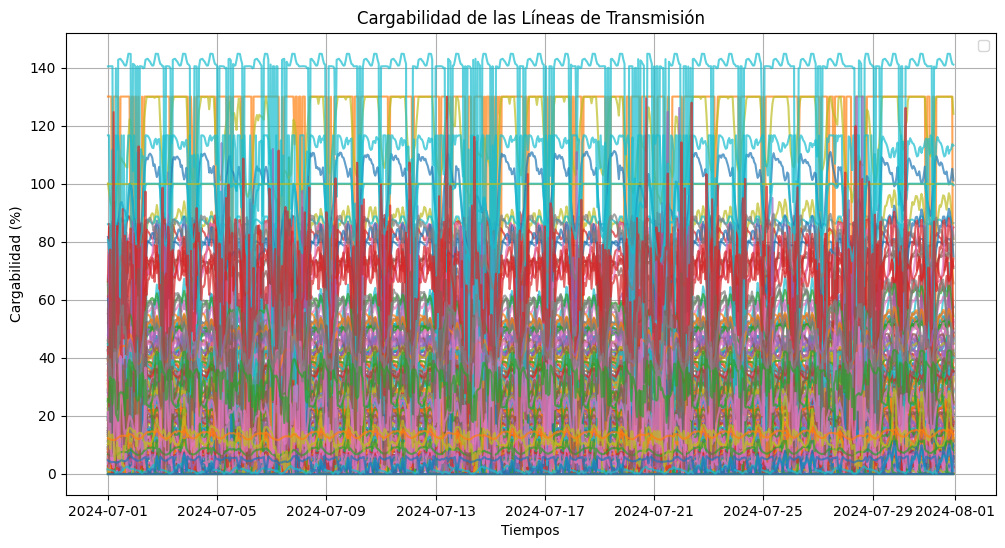

In [80]:
plt.figure(figsize=(12, 6))
for i, line in enumerate(network.lines.index):
    plt.plot(loading_percent[line], alpha=0.7)#label=f'Línea {line}', 
plt.xlabel('Tiempos')
plt.ylabel('Cargabilidad (%)')
plt.title('Cargabilidad de las Líneas de Transmisión')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\1706500715.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



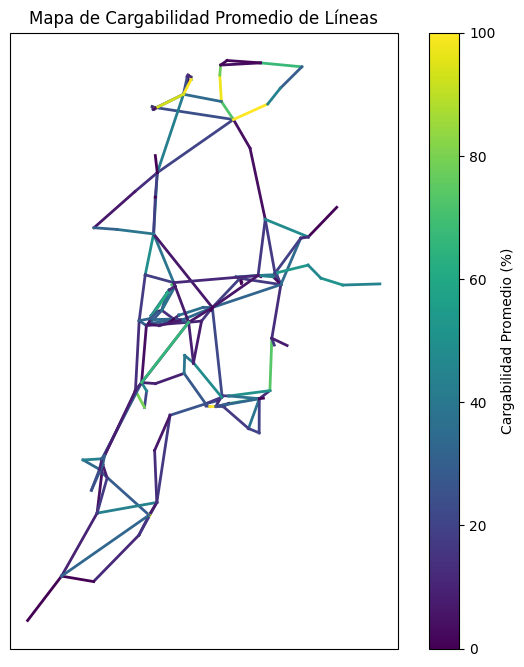

In [81]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
from matplotlib import cm

# Crear la figura y el eje con proyección Mercator
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.Mercator()}, figsize=(8, 8)
)

# Calcular la cargabilidad promedio de las líneas
line_loading_avg = (network.lines_t.p0.abs().mean(axis=0) / network.lines.s_nom * 100).fillna(0)

# Añadir la cargabilidad promedio al DataFrame de líneas
network.lines['loading_percent_avg'] = line_loading_avg

# Crear un colormap para representar el uso de capacidad
norm = Normalize(vmin=0, vmax=100)  # Normalización para cargabilidad en 0-100%
cmap = cm.get_cmap('viridis')  # Puedes cambiar el colormap si lo deseas

# Dibujar las líneas de la red con colores que representan su cargabilidad
for _, line in network.lines.iterrows():
    # Obtener coordenadas de los extremos de la línea
    x_coords = [network.buses.at[line.bus0, 'x'], network.buses.at[line.bus1, 'x']]
    y_coords = [network.buses.at[line.bus0, 'y'], network.buses.at[line.bus1, 'y']]
    
    # Determinar el color según la cargabilidad promedio
    loading_color = cmap(norm(line['loading_percent_avg']))
    
    # Dibujar la línea con el color correspondiente
    ax.plot(x_coords, y_coords, color=loading_color, linewidth=2)

# Agregar una barra de colores para mostrar la escala de cargabilidad
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cargabilidad Promedio (%)')

# Configurar el mapa
ax.set_title('Mapa de Cargabilidad Promedio de Líneas')
plt.show()


c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x24f550ab690>,
 <matplotlib.collections.LineCollection at 0x24f56a3fe50>)

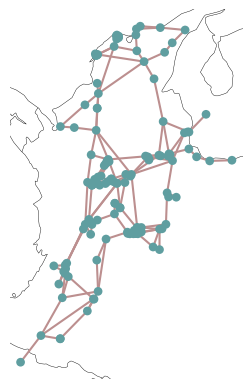

In [82]:
network.plot()

In [83]:
network.explore()

INFO:pypsa.plot:Components rendered on the map: Bus, Line.
INFO:pypsa.plot:Components omitted as they are missing or not selected: Generator, Link, Load, StorageUnit, Transformer.


In [84]:
network.branches

<bound method Network.branches of PyPSA Network
Components:
 - Bus: 125
 - Generator: 90
 - Line: 193
 - Load: 74
 - SubNetwork: 1
Snapshots: 744>

## Flow

In [85]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning

import pypsa

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
plt.rc("figure", figsize=(10, 8))

In [86]:
gen = network.generators.assign(g=network.generators_t.p.mean()).groupby(["bus"]).g.sum()
gen

bus
ALTO ANCHICAYA               288.407670
ANCON SUR (ISA)               13.709446
ANTIOQUIA                   1587.802848
BACATA                         0.047486
BARBOSA (ANTIOQUIA)           52.548092
BETANIA                      393.688303
BOLIVAR                       25.403679
CARACOLI                      12.701839
CARTAGENA                      0.000000
CASA DE MAQUINAS JAGUAS      117.590695
CASA MAQUINAS MIEL I         273.859176
CASA MAQUINAS PORCE III      492.684006
CASA MAQUINAS SAN CARLOS     474.875077
CERROMATOSO                    7.948864
CHINU                         93.993612
CHIVOR                       703.018561
CUESTECITAS                   85.912750
EL COPEY                     316.846222
EL QUIMBO                    274.581749
ESMERALDA                    112.324998
FUNDACION                     30.974462
GUADALUPE IV                 352.314609
GUAJIRA                        9.851885
GUATAPE                      430.809457
GUAVIO                       890.636

In [87]:
cap = network.generators.assign(c=network.generators.p_nom).groupby(["bus"]).c.sum()
cap

bus
ALTO ANCHICAYA               427.0
ANCON SUR (ISA)               20.0
ANTIOQUIA                   2400.0
BACATA                       226.0
BARBOSA (ANTIOQUIA)           78.0
BETANIA                      639.0
BOLIVAR                      152.0
CARACOLI                      50.0
CARTAGENA                    268.0
CASA DE MAQUINAS JAGUAS      170.0
CASA MAQUINAS MIEL I         396.0
CASA MAQUINAS PORCE III      700.0
CASA MAQUINAS SAN CARLOS    1240.0
CERROMATOSO                  434.0
CHINU                        370.0
CHIVOR                      1000.0
CUESTECITAS                  250.0
EL COPEY                     922.0
EL QUIMBO                    400.0
ESMERALDA                    165.0
FUNDACION                     90.0
GUADALUPE IV                 512.0
GUAJIRA                      275.0
GUATAPE                      610.0
GUAVIO                      1250.0
IBAGUE                        56.0
LA GUACA                     201.0
LA LOMA                      218.0
LA SIERRA (ANTIO

In [88]:
# Agrupar las capacidades de los generadores por bus
bus_sizes = network.generators.groupby("bus")["p_nom"].sum()

# Escalar para la visualización (por ejemplo, dividir entre 10)
bus_sizes_scaled = bus_sizes / 10

print(bus_sizes_scaled)  # Verifica los valores resultantes
bus_sizes_scaled = bus_sizes.reindex(network.buses.index, fill_value=0) / 10
bus_sizes_scaled


bus
ALTO ANCHICAYA               42.70
ANCON SUR (ISA)               2.00
ANTIOQUIA                   240.00
BACATA                       22.60
BARBOSA (ANTIOQUIA)           7.80
BETANIA                      63.90
BOLIVAR                      15.20
CARACOLI                      5.00
CARTAGENA                    26.80
CASA DE MAQUINAS JAGUAS      17.00
CASA MAQUINAS MIEL I         39.60
CASA MAQUINAS PORCE III      70.00
CASA MAQUINAS SAN CARLOS    124.00
CERROMATOSO                  43.40
CHINU                        37.00
CHIVOR                      100.00
CUESTECITAS                  25.00
EL COPEY                     92.20
EL QUIMBO                    40.00
ESMERALDA                    16.50
FUNDACION                     9.00
GUADALUPE IV                 51.20
GUAJIRA                      27.50
GUATAPE                      61.00
GUAVIO                      125.00
IBAGUE                        5.60
LA GUACA                     20.10
LA LOMA                      21.80
LA SIERRA (ANTIO

Bus
HIDROSOGAMOSO       0.0
ANCON SUR (EPM)     0.0
PORTON DEL SOL     10.2
RIO CORDOBA         0.0
TOLUVIEJO           0.0
                   ... 
EL BOSQUE           0.0
SAN BERNARDINO      0.0
BANADIA             0.0
HELICONIA           0.0
TOLEDO              0.0
Name: p_nom, Length: 125, dtype: float64

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



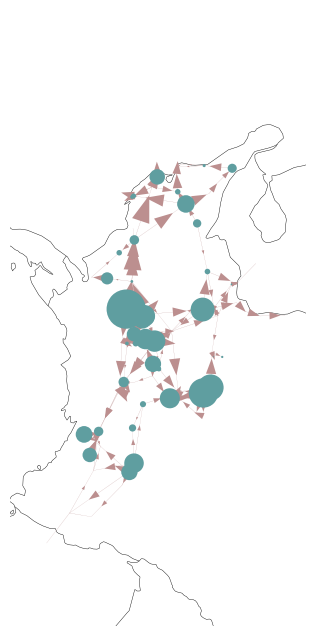

In [89]:
# links are not displayed for prettier output ('link_widths=0')
network.plot(
    bus_sizes=gen / 5e3,
    #bus_colors={"AGUA": "indianred", "Solar": "midnightblue"},
    margin=0.5,
    flow="mean",
    line_widths=0.1,
    link_widths=0,
)
plt.show()

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



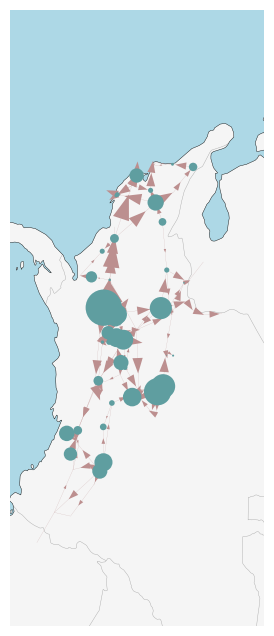

In [90]:
# links are not displayed for prettier output ('link_widths=0')
network.plot(
    bus_sizes=gen / 5e3,
    #bus_colors={"gas": "indianred", "wind": "midnightblue"},
    margin=0.5,
    flow="mean",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.show()

In [91]:
network.statistics().round(1)

Optimal Capacity  Installed Capacity      Supply  \
Generator ACPM                    903.0               903.0         0.0   
          AGUA                  13457.0             13457.0   6559435.6   
          CARBON                 1613.0              1613.0     16414.1   
          COMBUSTOLEO             266.0               266.0         0.0   
          EOLICA                 1172.0              1172.0    299652.7   
          GAS                    2983.0              2983.0    199593.6   
          GLP                      52.0                52.0         0.0   
          JET-A1                   50.0                50.0         0.0   
          RAD SOLAR              1346.9              1346.9    277179.4   
Line      AC                    96892.0             96892.0  16911830.8   
Load      -                         0.0                 0.0         0.0   

                       Withdrawal  Energy Balance  Transmission  \
Generator ACPM                0.0             0.0           0.0   
          AGUA                0.0       6559435.6           0.0   
          CARBON              0.0         16414.1           0.0   
          COMBUSTOLEO         0.0             0.0           0.0   
          EOLICA              0.0        299652.7           0.0   
          GAS                 0.0        199593.6           0.0   
          GLP                 0.0             0.0           0.0   
          JET-A1              0.0             0.0           0.0   
          RAD SOLAR           0.0        277179.4           0.0   
Line      AC           16911830.8             0.0     3697553.6   
Load      -             7352275.3      -7352275.3           0.0   

                       Capacity Factor  Curtailment  Capital Expenditure  \
Generator ACPM                     0.0     450160.0                  0.0   
          AGUA                     0.7    1294143.0                  0.0   
          CARBON                   0.0     858367.9                  0.0   
          COMBUSTOLEO              0.0     131476.0                  0.0   
          EOLICA                   0.3          0.0                  0.0   
          GAS                      0.1    1623868.4                  0.0   
          GLP                      0.0      38688.0                  0.0   
          JET-A1                   0.0      17112.0                  0.0   
          RAD SOLAR                0.3          0.0                  0.0   
Line      AC                       0.2          0.0                  0.0   
Load      -                        NaN          0.0                  0.0   

                       Operational Expenditure  Revenue  Market Value  
Generator ACPM                             0.0      0.0           0.0  
          AGUA                     513603806.6      0.0           NaN  
          CARBON                     6528617.9      0.0           NaN  
          COMBUSTOLEO                      0.0      0.0           0.0  
          EOLICA                    21679631.3      0.0           NaN  
          GAS                      118781599.3      0.0           NaN  
          GLP                              0.0      0.0           0.0  
          JET-A1                           0.0      0.0           0.0  
          RAD SOLAR                 16711421.5      0.0           NaN  
Line      AC                               0.0      0.0           NaN  
Load      -                                0.0      0.0           0.0

In [92]:
day = "2024-7-31"  # Cambia esta fecha según tu simulación
single_day_data = network.generators_t.p.loc[day]


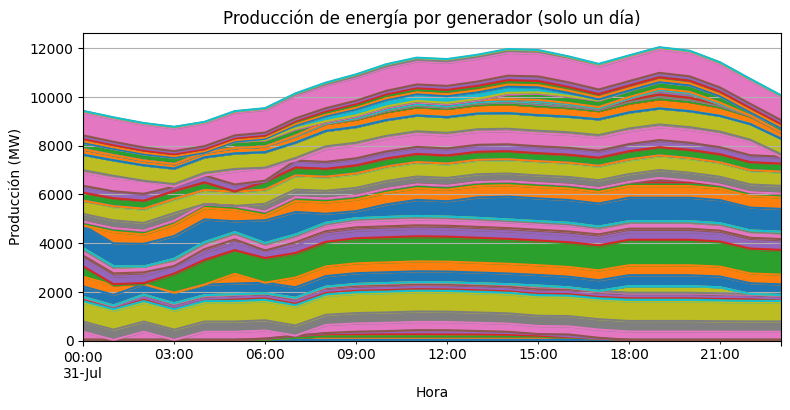

In [93]:
import matplotlib.pyplot as plt

# Graficar solo un día
single_day_data.plot.area(figsize=(9, 4), legend=False)

# Personalizar el gráfico
plt.title("Producción de energía por generador (solo un día)")
plt.xlabel("Hora")
plt.ylabel("Producción (MW)")
#plt.legend(title="Generadores", loc="upper left")
plt.grid()
plt.show()


## Demanda

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



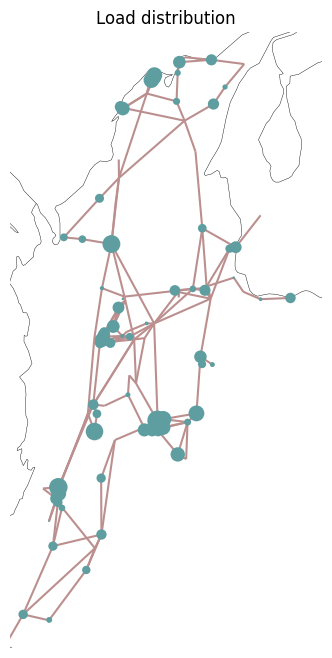

In [94]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8)
)

load_distribution = (
    network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()
)
network.plot(bus_sizes=1e-4 * load_distribution, ax=ax, title="Load distribution");

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



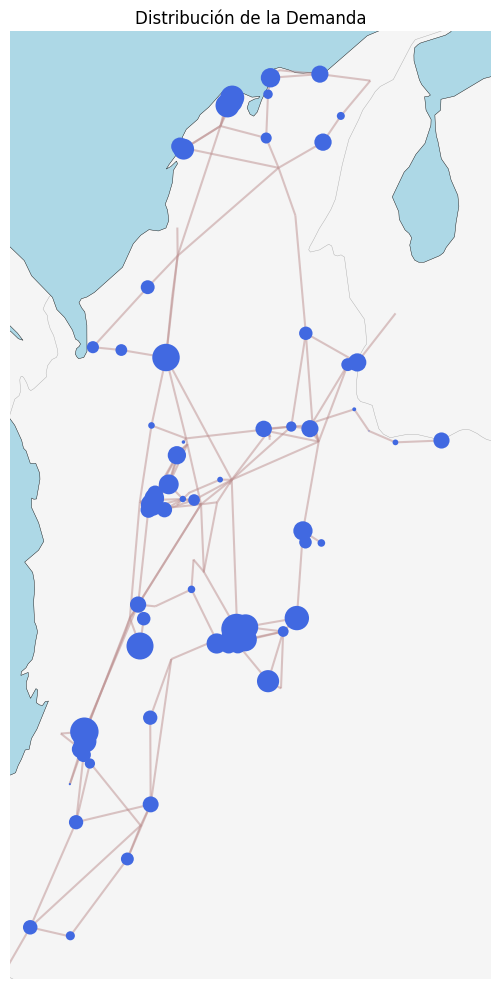

In [95]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Cargar la distribución de la demanda en el snapshot actual
load_distribution = (
    network.loads_t.p.loc[network.snapshots[0]].groupby(network.loads.bus).sum()
)

# Escalar el tamaño de los nodos para representar la demanda
node_sizes = 1e-4 * load_distribution  # Ajustar escala (puedes modificar 1e-3 según sea necesario)

# Crear un gráfico con proyección Equal Earth
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(10, 10)
)

# Graficar la red con los tamaños de nodos ajustados
network.plot(
    bus_sizes=node_sizes,  # Tamaño de nodos basado en la demanda
    ax=ax,
    bus_colors="#4169E1",  # Color para los nodos
    line_alpha=0.5,  # Líneas más claras para resaltar los nodos
    title="Distribución de la Demanda",
    color_geomap=True,  # Usar fondo geomap
)

plt.tight_layout()
plt.show()


## Lineas


### now

In [96]:
now = network.snapshots[4]


In [97]:
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()


count    193.000000
mean       0.040765
std        0.300887
min       -1.116486
25%       -0.129705
50%        0.000000
75%        0.167982
max        1.405152
dtype: float64

In [98]:
loading = abs(loading)
loading.describe()

count    193.000000
mean       0.206144
std        0.222457
min        0.000000
25%        0.040115
50%        0.143807
75%        0.291280
max        1.405152
dtype: float64

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



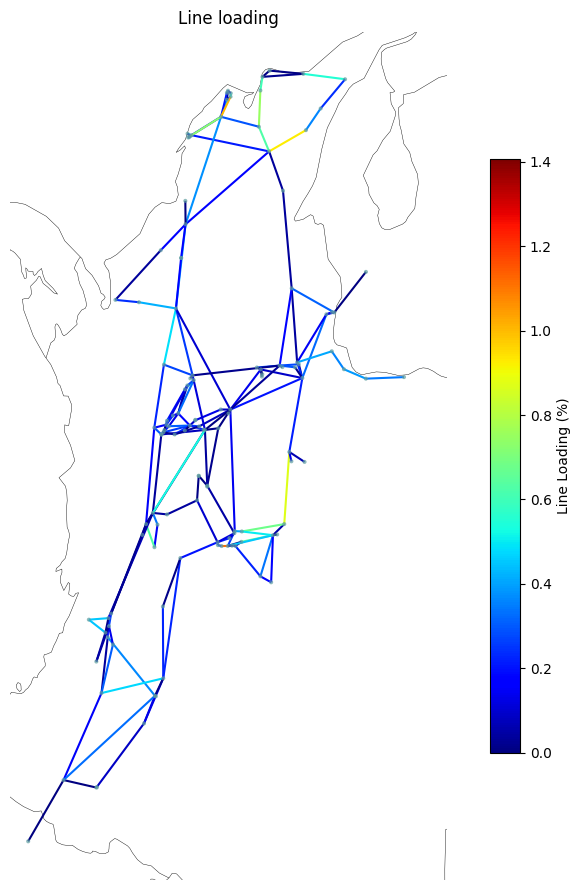

In [99]:
import matplotlib as mpl

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))

# Graficar la red
network.plot(
    ax=ax,
    line_colors=abs(loading),
    line_cmap=plt.cm.jet,  # Usar el colormap
    title="Line loading",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)

# Crear una barra de color (colorbar)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=loading.min(), vmax=loading.max()))
sm._A = []  # Necesario para inicializar la barra de color
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Line Loading (%)")  # Personalizar etiqueta

fig.tight_layout()
plt.show()


In [100]:
network.lines_t.p0.loc[now] / network.lines.s_nom

Line
Line_0     -0.042306
Line_2     -0.362974
Line_3      0.195824
Line_4     -0.122637
Line_5      0.083958
              ...   
Line_262   -0.135375
Line_263   -0.010962
Line_265   -0.040115
Line_267   -0.116684
Line_268   -0.237898
Length: 193, dtype: float64

### Completo

In [101]:
# Calcular la cargabilidad de las líneas para todos los snapshots
loading_all_time = network.lines_t.p0.abs() / network.lines.s_nom

# Encontrar el valor máximo de cargabilidad y el snapshot correspondiente
max_loading_value = loading_all_time.max().max()  # Valor máximo de cargabilidad
max_loading_snapshot = loading_all_time.stack().idxmax()  # Snapshot correspondiente al valor máximo

# Imprimir el resultado
print(f"La mayor cargabilidad fue {max_loading_value:.2f} en el snapshot {max_loading_snapshot}")


La mayor cargabilidad fue 1.45 en el snapshot (Timestamp('2024-07-01 18:00:00'), 'Line_121')


In [102]:
network.lines.loc['Line_121']

bus0                   EL QUIMBO
bus1                     TESALIA
type                            
x                         0.4871
r                         0.0564
g                            0.0
b                         3.4357
s_nom                  221.39865
s_nom_mod                    0.0
s_nom_extendable           False
s_nom_min                    0.0
s_nom_max                    inf
s_max_pu                 1.63722
capital_cost                 0.0
active                      True
build_year                  2015
lifetime                     inf
length                      2.69
carrier                       AC
terrain_factor               1.0
num_parallel                 2.0
v_ang_min                   -inf
v_ang_max                    inf
sub_network                    0
x_pu                    0.000009
r_pu                    0.000001
g_pu                         0.0
b_pu                   181748.53
x_pu_eff                0.000009
r_pu_eff                0.000001
s_nom_opt 

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



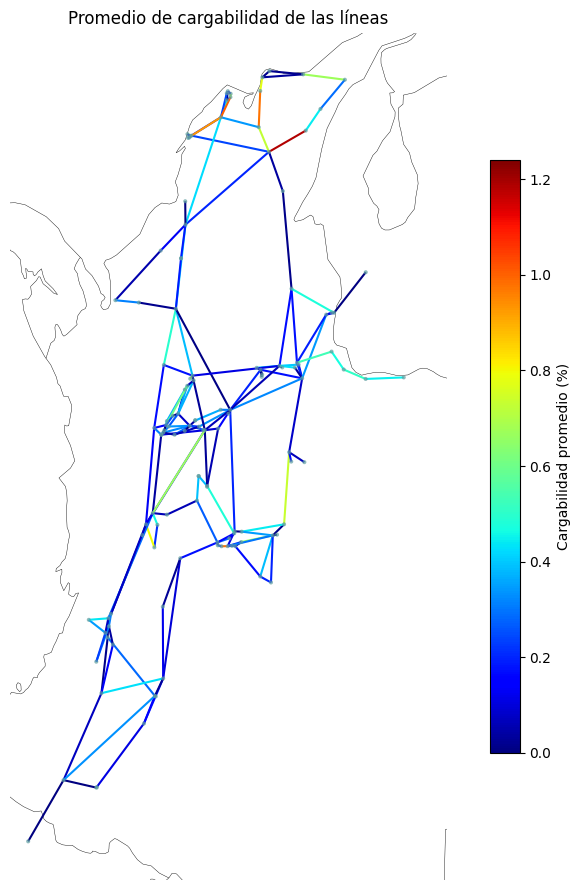

In [103]:
import matplotlib as mpl
import numpy as np

# Calcular la cargabilidad promedio de las líneas a través de todos los snapshots
loading_avg = abs(network.lines_t.p0.mean(axis=0) / network.lines.s_nom)

# Graficar la red
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))

# Graficar las líneas con la cargabilidad promedio
network.plot(
    ax=ax,
    line_colors=abs(loading_avg),
    line_cmap=plt.cm.jet,  # Usar el colormap
    title="Promedio de cargabilidad de las líneas",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)

# Crear la barra de color
sm = mpl.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=loading_avg.min(), vmax=loading_avg.max()))
sm._A = []  # Necesario para inicializar la barra de color
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Cargabilidad promedio (%)")  # Personalizar etiqueta

fig.tight_layout()
plt.show()


In [104]:
loading = loading_avg

In [105]:
np.percentile(abs(loading), 95)

0.7472970442408708

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



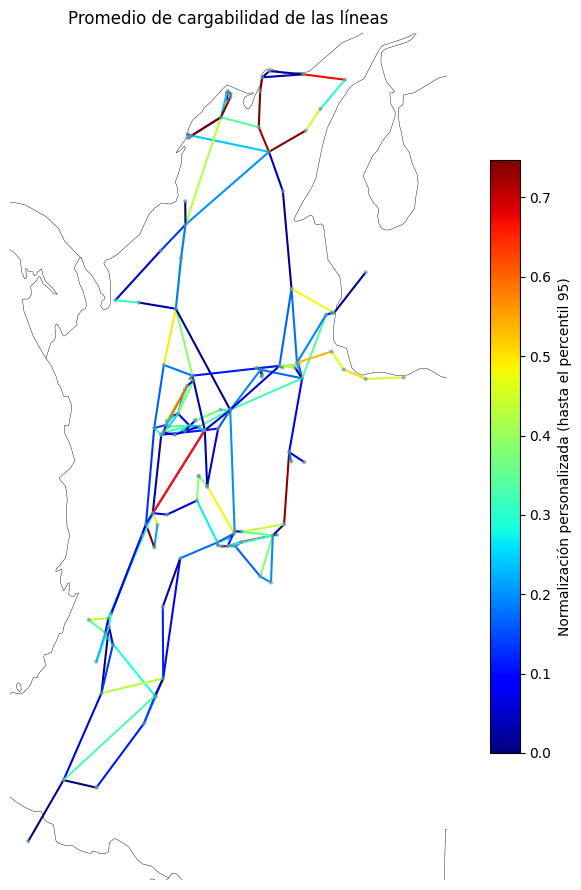

In [106]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs

# Normalización personalizada (hasta el percentil 95)
norm = Normalize(vmin=0, vmax=np.percentile(abs(loading), 95))

# Crear la figura y el eje con proyección geográfica
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))

# Graficar la red con el colormap y normalización
network.plot(
    ax=ax,
    line_colors=abs(loading),  # Valores de carga de las líneas
    line_cmap=plt.cm.jet,      # Colormap
    line_norm=norm,            # Normalización
    title="Promedio de cargabilidad de las líneas",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)

# Crear una barra de color
import matplotlib as mpl
sm = mpl.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)  # Mappable para la barra de color
sm._A = []  # Necesario para inicializar la barra de color

# Agregar la barra de color a la figura
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Normalización personalizada (hasta el percentil 95)")  # Etiqueta de la barra de color

# Ajustar diseño
fig.tight_layout()
plt.show()


In [107]:
np.percentile(abs(loading), 95)

0.7472970442408708

In [108]:
demanda_por_dia = network.loads_t.p_set.resample('D').sum().sum(axis=1)
demanda_por_dia

snapshot
2024-07-01    210881.341361
2024-07-02    239547.251064
2024-07-03    242306.211989
2024-07-04    239419.405433
2024-07-05    231532.105985
2024-07-06    227062.180185
2024-07-07    208929.607938
2024-07-08    238549.634379
2024-07-09    243126.926007
2024-07-10    244226.766048
2024-07-11    246060.716464
2024-07-12    245232.048493
2024-07-13    232998.748605
2024-07-14    213428.654708
2024-07-15    239179.256703
2024-07-16    242322.845727
2024-07-17    245863.007750
2024-07-18    242609.738278
2024-07-19    239012.892394
2024-07-20    220270.149233
2024-07-21    212708.469916
2024-07-22    241487.685038
2024-07-23    244108.084846
2024-07-24    244792.863285
2024-07-25    249092.604504
2024-07-26    249843.034364
2024-07-27    235459.146433
2024-07-28    215680.708021
2024-07-29    251961.674394
2024-07-30    257646.570993
2024-07-31    256934.944326
Freq: D, dtype: float64

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



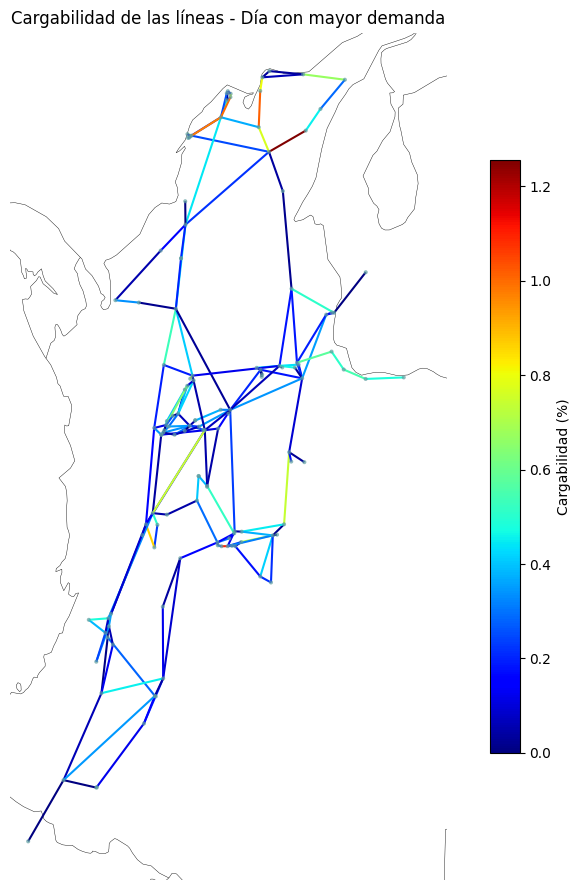

In [109]:
import matplotlib as mpl
import numpy as np

# Calcular la demanda total por día (suponiendo que cada snapshot es una hora)
# Agrupamos por día (suponiendo que los indices de los snapshots son fechas)
demanda_por_dia = network.loads_t.p_set.resample('D').sum().sum(axis=1)

# Identificar el índice del día con la mayor demanda
indice_max_demanda_dia = demanda_por_dia.idxmax()

# Obtener los snapshots del día con mayor demanda
snapshots_max_demanda = network.snapshots[network.snapshots.date == indice_max_demanda_dia.date()]


# Calcular la cargabilidad de las líneas para todos los snapshots del día con mayor demanda
loading_max_dia = network.lines_t.p0.loc[snapshots_max_demanda].mean(axis=0) / network.lines.s_nom
loading_max_dia = abs(loading_max_dia)
# Graficar la red para el día con mayor demanda
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))

# Graficar las líneas con la cargabilidad promedio del día con mayor demanda
network.plot(
    ax=ax,
    line_colors=abs(loading_max_dia),
    line_cmap=plt.cm.jet,  # Usar el colormap
    title="Cargabilidad de las líneas - Día con mayor demanda",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)

# Crear la barra de color
sm = mpl.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=loading_max_dia.min(), vmax=loading_max_dia.max()))
sm._A = []  # Necesario para inicializar la barra de color
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Cargabilidad (%)")  # Personalizar etiqueta

fig.tight_layout()
plt.show()


c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



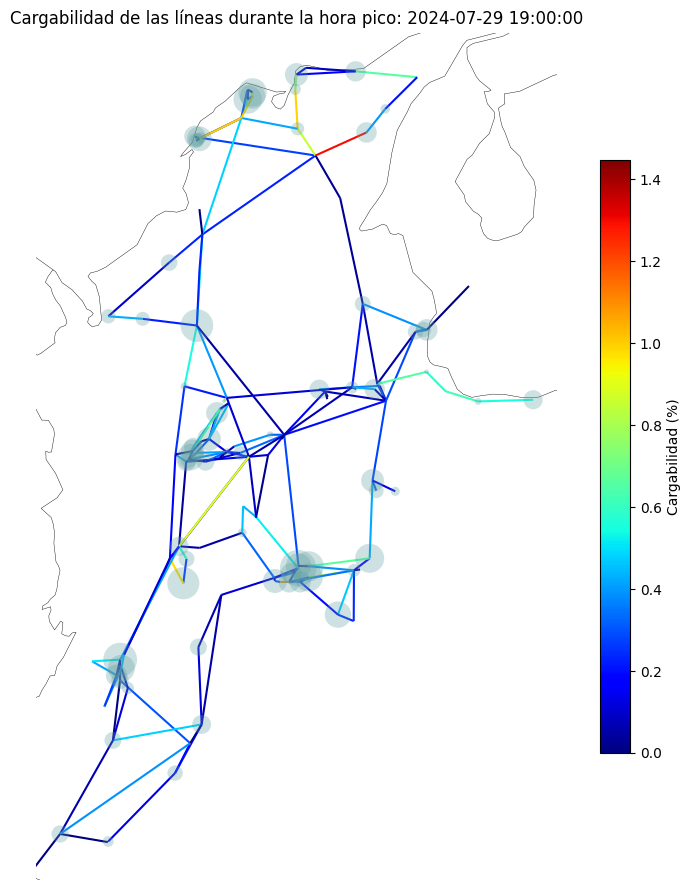

In [110]:
import matplotlib as mpl
import numpy as np

# Identificar la hora de máxima demanda

demanda_por_hora = network.loads_t.p_set.sum(axis=1)

peak_time = demanda_por_hora.idxmax()

# Extraer los flujos de potencia de las líneas en la hora pico
peak_flows = network.lines_t.p0.loc[peak_time]

# Calcular la cargabilidad de las líneas (en relación con su capacidad nominal)
loading_peak_time = peak_flows.abs() / network.lines.s_nom

# Extraer las demandas de los buses en la hora pico
peak_demands = network.loads_t.p_set.loc[peak_time]

# Graficar mapa de la red en la hora de máxima demanda
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(9, 9))

network.plot(
    ax=ax,
    line_colors=loading_peak_time,  # Cargabilidad de las líneas
    line_cmap=plt.cm.jet,  # Usar el colormap
    bus_sizes=peak_demands / 1e4,  # Tamaño de los buses basado en la demanda
    bus_alpha=0.3,
    title=f"Cargabilidad de las líneas durante la hora pico: {peak_time}",
)

# Crear la barra de color
sm = mpl.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=loading_peak_time.min(), vmax=loading_peak_time.max()))
sm._A = []  # Necesario para inicializar la barra de color
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Cargabilidad (%)")  # Personalizar etiqueta

fig.tight_layout()
plt.show()



<Axes: xlabel='snapshot'>

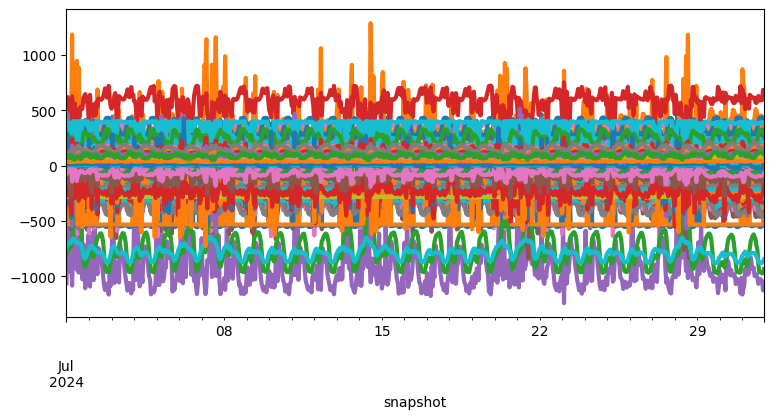

In [111]:
network.lines_t.p1.plot(figsize=(9, 4), lw=3, legend = False)

In [112]:
critical_lines = loading[loading > 0.8]
critical_lines


Line
Line_82     1.159798
Line_119    1.182681
Line_121    1.240214
Line_137    0.975090
Line_224    0.982261
Line_250    1.000000
Line_251    0.927978
dtype: float64

In [113]:
criticas = pd.DataFrame(critical_lines).reset_index()
criticas.rename(columns={0: 'Cargabilidad'}, inplace=True)
criticas
lineas = []
for _, row in criticas.iterrows():
    inicio = network.lines.loc[row['Line']]['bus0']
    final = network.lines.loc[row['Line']]['bus1']
    lineas.append(inicio + ' - ' + final)
criticas['lineas'] = lineas
criticas.to_excel('criticas.xlsx')

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



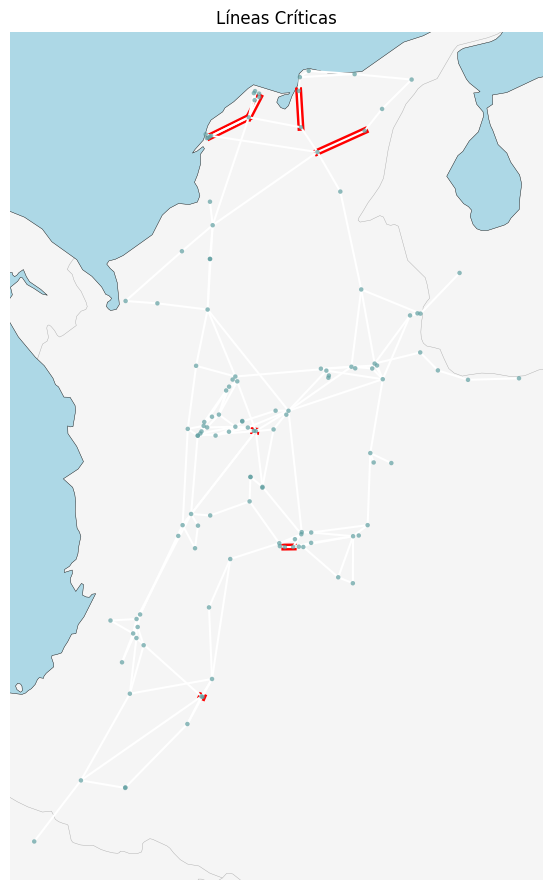

In [114]:
# Filtrar las líneas críticas basadas en sus nombres
critical_line_names = critical_lines.index  # Las líneas críticas

# Filtrar las líneas críticas en la red
critical_lines_df = network.lines.loc[critical_line_names]

# Crear el gráfico
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(9, 9))

# Graficar todas las líneas pero solo aquellas que están en las líneas críticas
network.plot(
    ax=ax,
    line_colors='white',  # Colorear todas las líneas de color gris (no críticas)
    bus_sizes=1e-3,  # Tamaño de los buses (ajústalo según sea necesario)
    bus_alpha=0.7,  # Transparencia de los buses
    color_geomap=True,  # Colorear el mapa geográfico
    title="Líneas Críticas"
)

# Graficar las líneas críticas de color rojo
for line in critical_lines_df.index:
    # Obtener las coordenadas de las líneas
    bus0_coords = network.buses.loc[network.lines.loc[line, 'bus0'], ['x', 'y']].values
    bus1_coords = network.buses.loc[network.lines.loc[line, 'bus1'], ['x', 'y']].values
    
    # Dibujar la línea crítica entre los buses
    ax.plot([bus0_coords[0], bus1_coords[0]], [bus0_coords[1], bus1_coords[1]], color='red', linewidth=5)

# Ajustar diseño
fig.tight_layout()
plt.show()





## Carriers

In [115]:
carrier_colors = {
    #"Solar": "gold",
    "RAD SOLAR": "gold",
    "EOLICA": "skyblue",
    "JET-A1": "black",
    "GLP": "darkorange",
    "GAS": "dimgray",
    "COMBUSTOLEO": "forestgreen",
    "CARBON": "slategray",
    "AGUA": "royalblue",
    "ACPM": "saddlebrown",
}

# Ordenar explícitamente las columnas según un orden definido
cols = [
    "AGUA",
    "CARBON",
    "GAS",
    "EOLICA",
    #"Solar",
    "RAD SOLAR",
    "JET-A1",
    "GLP",
    "COMBUSTOLEO",
    "ACPM",
]

In [116]:
network.generators.type.unique()

array(['HIDRAULICA', 'SOLAR', 'TERMICA', 'EOLICA'], dtype=object)

In [117]:
type_colors = {
    #"Solar": "gold",
    "SOLAR": "gold",
    "EOLICA": "skyblue",
    "HIDRAULICA": "royalblue",
    "TERMICA": "darkorange"
}

# Ordenar explícitamente las columnas según un orden definido
cols_t = [
    "HIDRAULICA",
    "TERMICA",
    "SOLAR",
    "EOLICA",
]

C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\3862640337.py:6: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



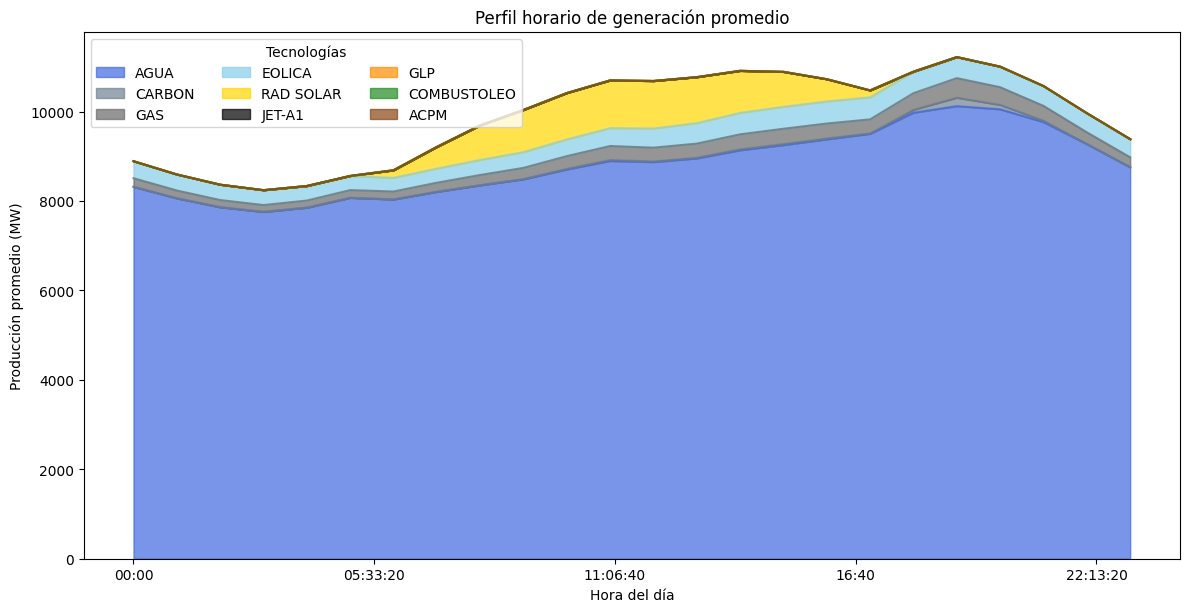

In [118]:
import matplotlib.pyplot as plt

# Agrupar generación por carrier
grouped_data = (
    network.generators_t.p  # Toda la serie temporal de generación
    .groupby(network.generators["carrier"], axis=1)  # Agrupar por carrier
    .sum()  # Sumar la generación de cada tecnología
)

# Calcular el promedio horario (agregando por hora del día)
average_hourly_data = grouped_data.groupby(grouped_data.index.time).mean()

# Filtrar y reordenar las columnas presentes en los datos
present_cols = [col for col in cols if col in average_hourly_data.columns]
average_hourly_data = average_hourly_data[present_cols]

# Asignar colores en el mismo orden que las columnas
c = [carrier_colors[col] for col in average_hourly_data.columns]

# Graficar el promedio horario con los colores correctos
fig, ax = plt.subplots(figsize=(12, 6))
average_hourly_data.plot.area(ax=ax, color=c, alpha=0.7)

# Personalizar la leyenda
ax.legend(title="Tecnologías", ncol=3, loc="upper left")
ax.set_ylabel("Producción promedio (MW)")
ax.set_xlabel("Hora del día")

# Ajustar diseño y mostrar
fig.tight_layout()
plt.title("Perfil horario de generación promedio")
plt.show()


In [119]:
generation_total = (
    network.generators_t.p.sum(axis=0)  # Suma la generación en todos los snapshots
    .groupby(network.generators.type)  # Agrupa por tecnología (carrier)
    .sum()  # Suma la generación para cada tecnología
)


In [120]:
import pandas as pd

# Obtener la capacidad instalada por carrier
capacity_by_carrier = network.generators.groupby('carrier').p_nom.sum()

# Mostrar la capacidad instalada por carrier
print(capacity_by_carrier)


carrier
ACPM             903.0
AGUA           13457.0
CARBON          1613.0
COMBUSTOLEO      266.0
EOLICA          1172.0
GAS             2983.0
GLP               52.0
JET-A1            50.0
RAD SOLAR       1346.9
Name: p_nom, dtype: float64


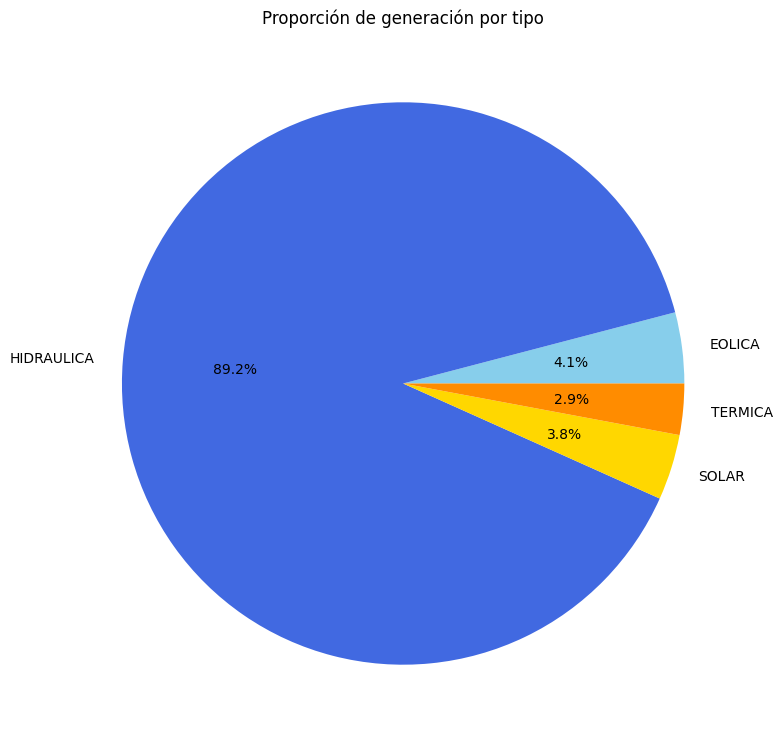

In [121]:
# Calcular proporciones relativas de la generación por tecnología
generation_relative = generation_total / generation_total.sum()

# Graficar distribución relativa como un gráfico de pastel
generation_relative.plot(
    kind="pie",
    figsize=(8, 8),
    autopct="%.1f%%",
    colors=[type_colors[carrier] for carrier in generation_relative.index],
)
plt.title("Proporción de generación por tipo")
plt.ylabel("")  # Quitar etiqueta del eje Y
plt.tight_layout()
plt.show()

### Perfil Horario; promedio de los dias POR CARRIER
Toca cambiar el RAD SOLAR o el Solar y el Eolico

In [122]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Calcular la generación media por bus y carrier
gen_car = (
    network.generators.assign(g=network.generators_t.p.mean())  # Generación promedio
    .groupby(["bus", "carrier"]).g.sum()  # Agrupar por bus y carrier
)

cap_car = (
    network.generators.assign(c=network.generators.p_nom)  # Generación promedio
    .groupby(["bus", "carrier"]).c.sum()  # Agrupar por bus y carrier
)

# Definir colores personalizados para los carriers


In [123]:
cap_car

bus                  carrier  
ALTO ANCHICAYA       AGUA          427.0
ANCON SUR (ISA)      AGUA           20.0
ANTIOQUIA            AGUA         2400.0
BACATA               CARBON        226.0
BARBOSA (ANTIOQUIA)  AGUA           78.0
                                   ...  
TERMOFLORES          GAS           605.0
TESORITO             GAS           200.0
TULUNI               AGUA           80.0
URRA                 AGUA          338.0
                     RAD SOLAR      19.9
Name: c, Length: 61, dtype: float64

In [124]:
gen

bus
ALTO ANCHICAYA               288.407670
ANCON SUR (ISA)               13.709446
ANTIOQUIA                   1587.802848
BACATA                         0.047486
BARBOSA (ANTIOQUIA)           52.548092
BETANIA                      393.688303
BOLIVAR                       25.403679
CARACOLI                      12.701839
CARTAGENA                      0.000000
CASA DE MAQUINAS JAGUAS      117.590695
CASA MAQUINAS MIEL I         273.859176
CASA MAQUINAS PORCE III      492.684006
CASA MAQUINAS SAN CARLOS     474.875077
CERROMATOSO                    7.948864
CHINU                         93.993612
CHIVOR                       703.018561
CUESTECITAS                   85.912750
EL COPEY                     316.846222
EL QUIMBO                    274.581749
ESMERALDA                    112.324998
FUNDACION                     30.974462
GUADALUPE IV                 352.314609
GUAJIRA                        9.851885
GUATAPE                      430.809457
GUAVIO                       890.636

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



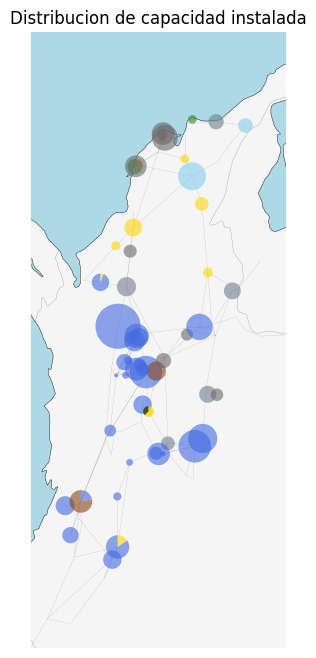

In [125]:
high_flow_lines = network.lines_t.p0.mean().abs() > 1000
network.plot(
    line_colors=high_flow_lines * network.lines_t.p0.mean().abs(),
    bus_sizes=cap_car / 1e4,
    bus_colors=carrier_colors,
    bus_alpha=0.6,  # Agrega transparencia a los nodos
    margin=0.2,
    #flow="mean",
    line_widths=0.1,
    line_alpha=0.5,  # Transparencia para las líneas
    link_widths=0,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.title("Distribucion de capacidad instalada")
plt.show()


c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



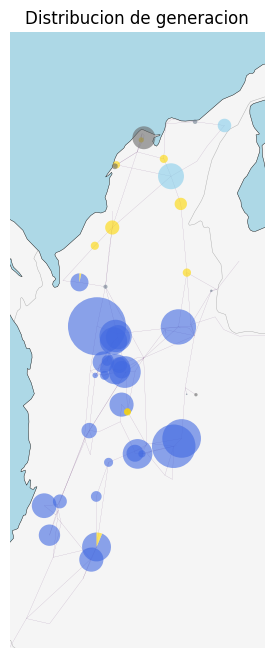

In [126]:
high_flow_lines = network.lines_t.p0.mean().abs() > 1000
network.plot(
    line_colors=high_flow_lines * network.lines_t.p0.mean().abs(),
    bus_sizes=gen_car / 4e3,
    bus_colors=carrier_colors,
    bus_alpha=0.6,  # Agrega transparencia a los nodos
    margin=0.2,
    #flow="mean",
    line_widths=0.1,
    line_alpha=0.5,  # Transparencia para las líneas
    link_widths=0,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.title("Distribucion de generacion")
plt.show()



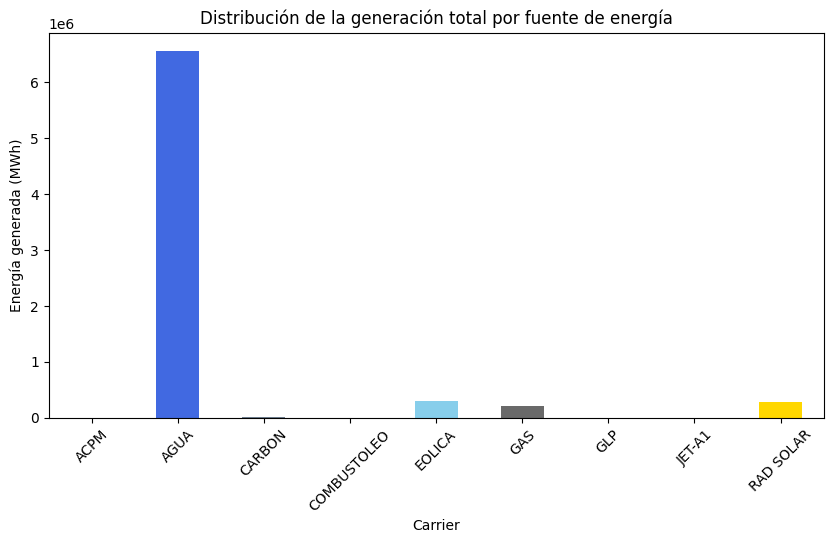

In [127]:
# Calcular la generación total por carrier
gen_total = (
    network.generators_t.p.sum(axis=0)
    .groupby(network.generators.carrier)
    .sum()
)

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [carrier_colors[carrier] for carrier in gen_total.index]

# Graficar con colores corregidos
gen_total.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Distribución de la generación total por fuente de energía")
plt.ylabel("Energía generada (MWh)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()



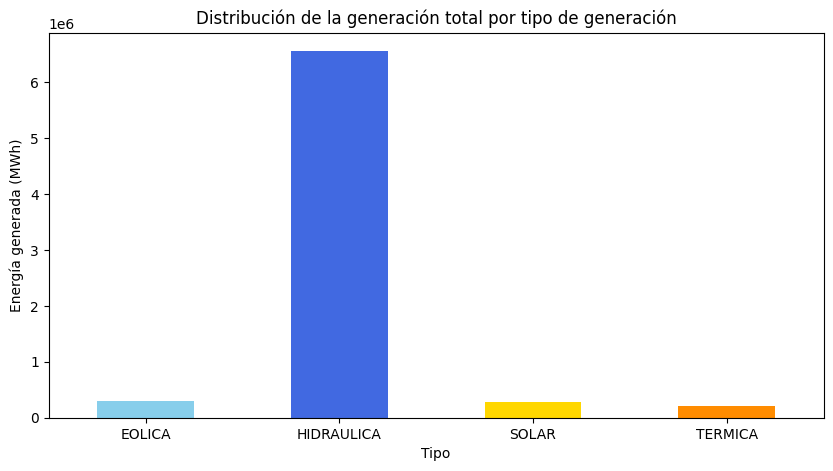

In [128]:
# Calcular la generación total por carrier
gen_total = (
    network.generators_t.p.sum(axis=0)
    .groupby(network.generators.type)
    .sum()
)

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [type_colors[carrier] for carrier in gen_total.index]

# Graficar con colores corregidos
gen_total.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Distribución de la generación total por tipo de generación")
plt.ylabel("Energía generada (MWh)")
plt.xlabel("Tipo")
plt.xticks(rotation=0)
plt.show()

In [129]:
network.generators.type.unique()

array(['HIDRAULICA', 'SOLAR', 'TERMICA', 'EOLICA'], dtype=object)

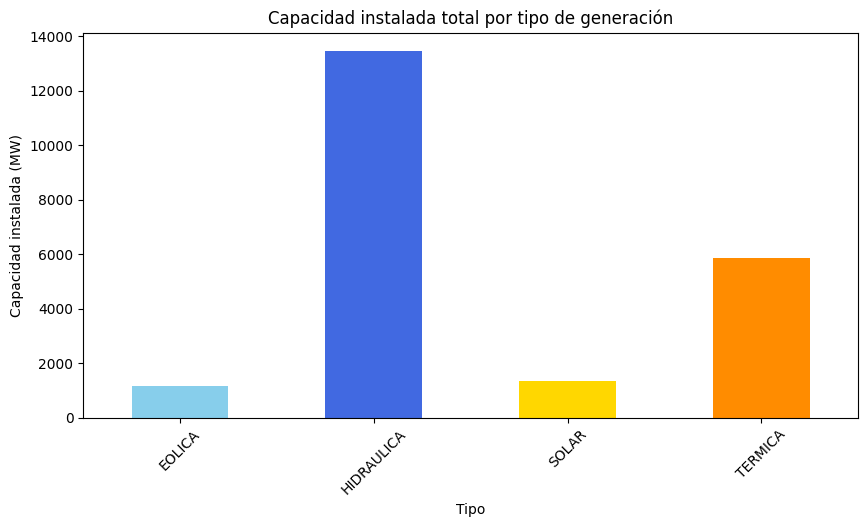

In [130]:
# Asegúrate de que carrier_colors tenga colores válidos asignados a cada carrier

# Calcular la capacidad instalada total por carrier
capacity_total = network.generators.groupby("type")["p_nom"].sum()

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [type_colors[tipo] for tipo in capacity_total.index]

# Graficar capacidad instalada por carrier
capacity_total.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Capacidad instalada total por tipo de generación")
plt.ylabel("Capacidad instalada (MW)")
plt.xlabel("Tipo")
plt.xticks(rotation=45)
plt.show()

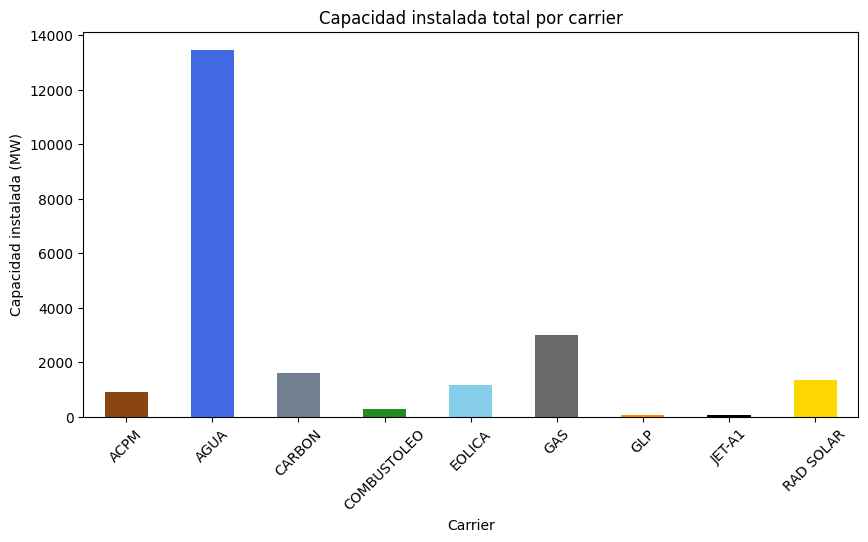

In [131]:
# Asegúrate de que carrier_colors tenga colores válidos asignados a cada carrier

# Calcular la capacidad instalada total por carrier
capacity_total = network.generators.groupby("carrier")["p_nom"].sum()

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [carrier_colors[carrier] for carrier in capacity_total.index]

# Graficar capacidad instalada por carrier
capacity_total.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Capacidad instalada total por carrier")
plt.ylabel("Capacidad instalada (MW)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()


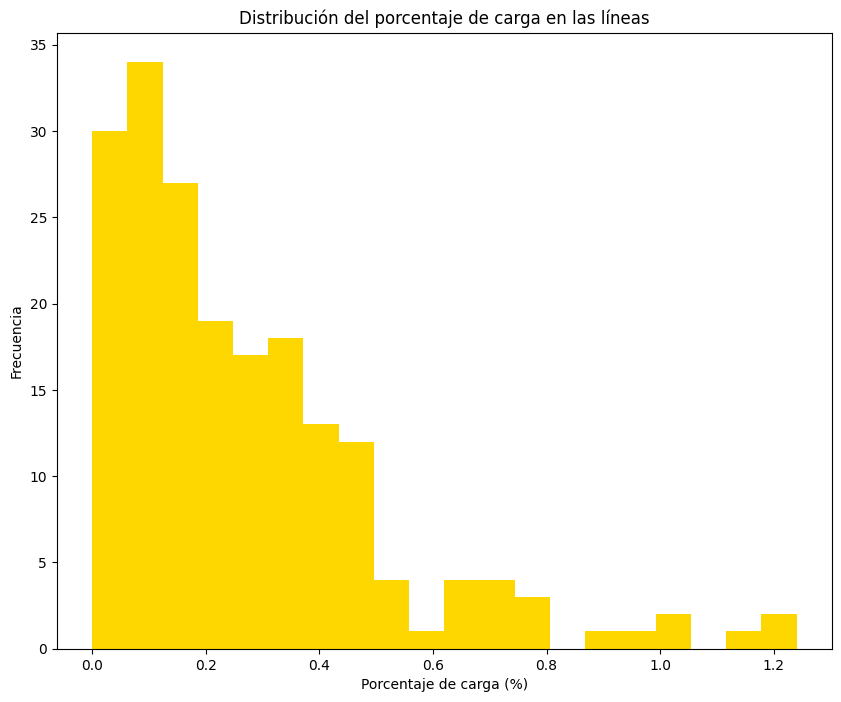

In [132]:

loading = (network.lines_t.p0 / network.lines.s_nom).abs().mean(axis=0)
loading.hist(bins=20, color='#FFD700')  # Color morado claro
plt.title("Distribución del porcentaje de carga en las líneas")
plt.xlabel("Porcentaje de carga (%)")
plt.ylabel("Frecuencia")
plt.grid(False)  # Elimina el grid
plt.show()



C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\2548742060.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



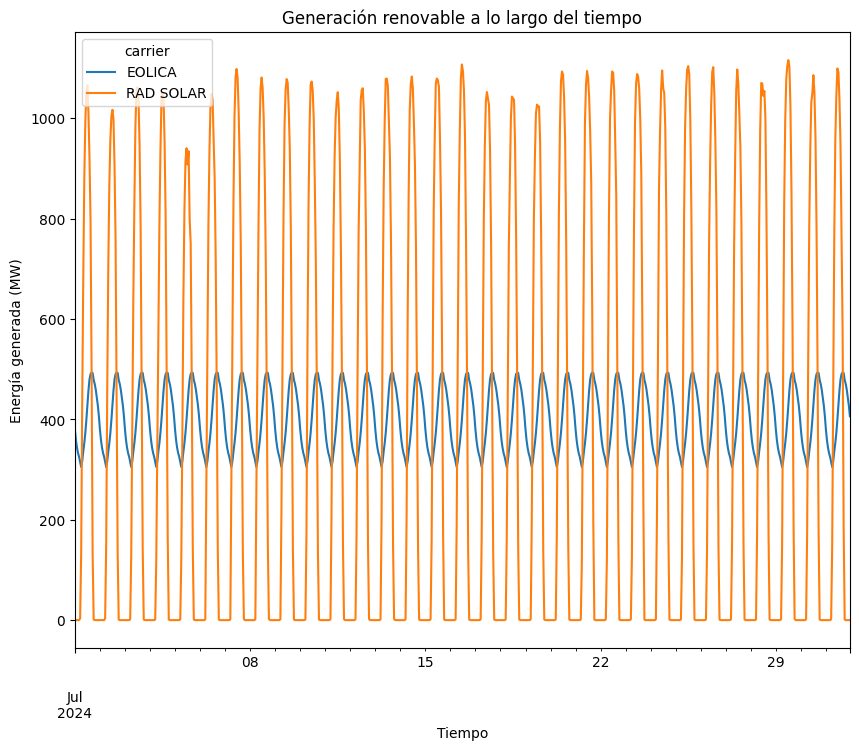

In [133]:
renewables = network.generators[network.generators.carrier.isin(["RAD SOLAR", "EOLICA"])]
renewables_t = network.generators_t.p[renewables.index]
renewables_t.groupby(renewables.carrier, axis=1).sum().plot()
plt.title("Generación renovable a lo largo del tiempo")
plt.ylabel("Energía generada (MW)")
plt.xlabel("Tiempo")
plt.show()


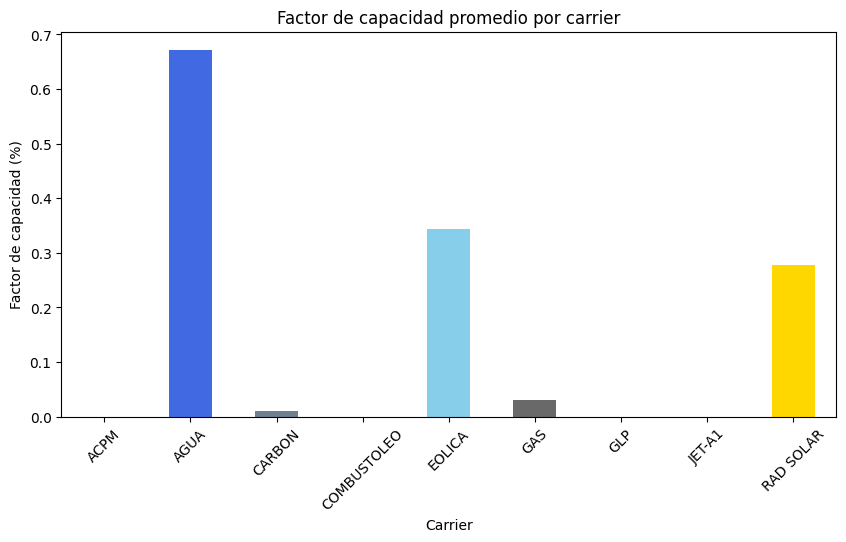

In [134]:
# Calcular el factor de capacidad por hora para cada generador
capacity_factor_hourly = network.generators_t.p.divide(network.generators.p_nom, axis=1)

# Promedio del factor de capacidad por carrier
capacity_factor_mean = capacity_factor_hourly.mean(axis=0).groupby(network.generators.carrier).mean()

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [carrier_colors[carrier] for carrier in capacity_factor_mean.index]

# Graficar el factor de capacidad promedio por carrier
capacity_factor_mean.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Factor de capacidad promedio por carrier")
plt.ylabel("Factor de capacidad (%)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()




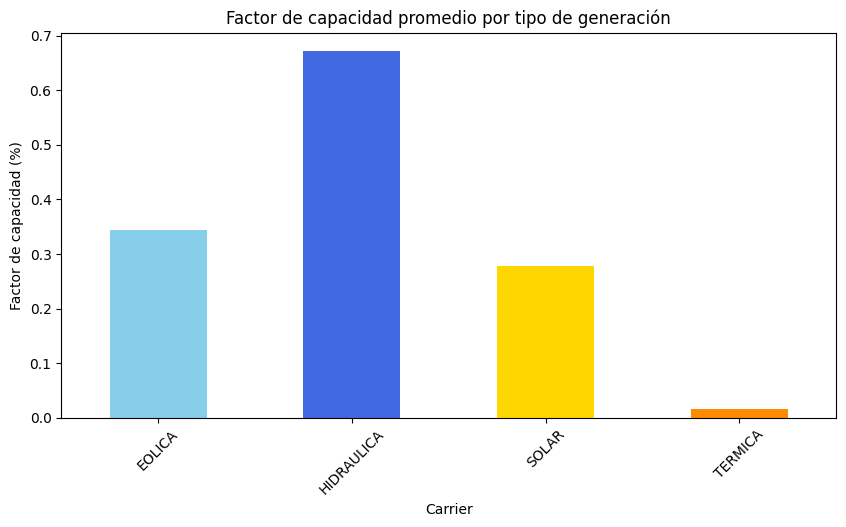

In [135]:
# Calcular el factor de capacidad por hora para cada generador
capacity_factor_hourly = network.generators_t.p.divide(network.generators.p_nom, axis=1)

# Promedio del factor de capacidad por carrier
capacity_factor_mean = capacity_factor_hourly.mean(axis=0).groupby(network.generators.type).mean()

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [type_colors[carrier] for carrier in capacity_factor_mean.index]

# Graficar el factor de capacidad promedio por carrier
capacity_factor_mean.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Factor de capacidad promedio por tipo de generación")
plt.ylabel("Factor de capacidad (%)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()


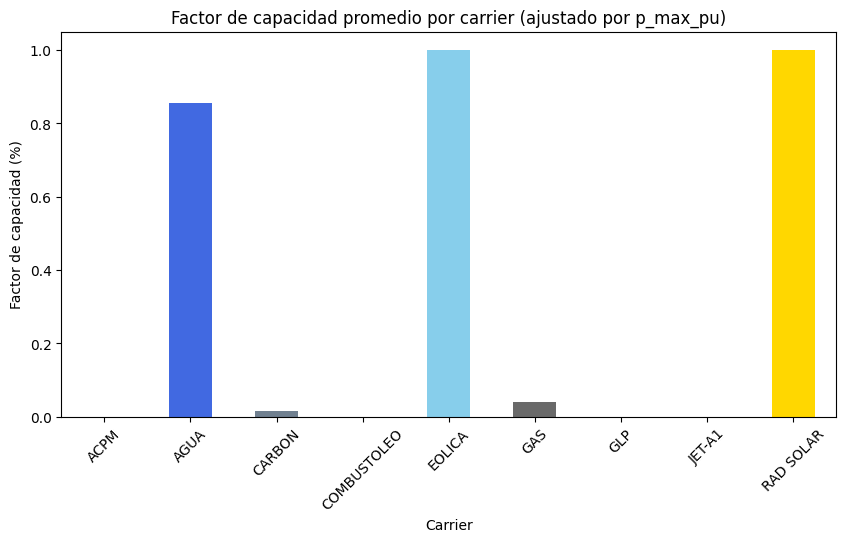

In [136]:
# Capacidad disponible en cada hora
available_capacity = network.generators.p_nom * network.generators_t.p_max_pu

# Factor de capacidad por hora (generación real / capacidad disponible)
capacity_factor_hourly = network.generators_t.p.divide(available_capacity, axis=1)

# Promedio del factor de capacidad por carrier
capacity_factor_mean = capacity_factor_hourly.mean(axis=0).groupby(network.generators.carrier).mean()

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [carrier_colors[carrier] for carrier in capacity_factor_mean.index]

# Graficar el factor de capacidad promedio por carrier
capacity_factor_mean.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Factor de capacidad promedio por carrier (ajustado por p_max_pu)")
plt.ylabel("Factor de capacidad (%)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()


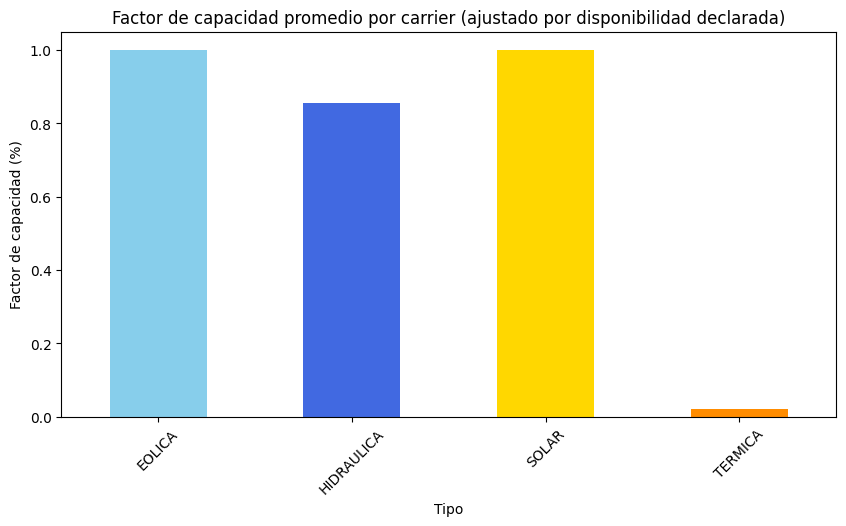

In [137]:
# Capacidad disponible en cada hora
available_capacity = network.generators.p_nom * network.generators_t.p_max_pu

# Factor de capacidad por hora (generación real / capacidad disponible)
capacity_factor_hourly = network.generators_t.p.divide(available_capacity, axis=1)

# Promedio del factor de capacidad por carrier
capacity_factor_mean = capacity_factor_hourly.mean(axis=0).groupby(network.generators.type).mean()

# Filtrar colores solo para los carriers presentes en los datos
filtered_colors = [type_colors[carrier] for carrier in capacity_factor_mean.index]

# Graficar el factor de capacidad promedio por carrier
capacity_factor_mean.plot(kind="bar", color=filtered_colors, figsize=(10, 5))
plt.title("Factor de capacidad promedio por carrier (ajustado por disponibilidad declarada)")
plt.ylabel("Factor de capacidad (%)")
plt.xlabel("Tipo")
plt.xticks(rotation=45)
plt.show()

## Demanda

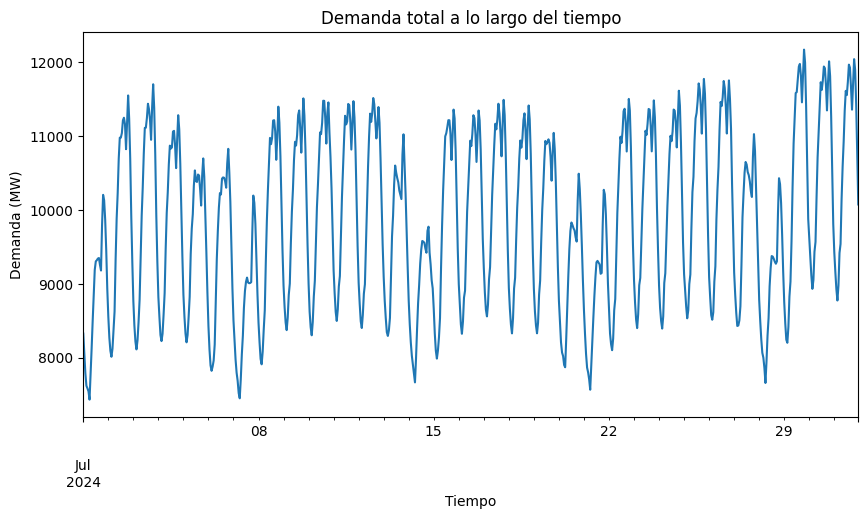

In [138]:
# Demanda total por hora
total_demand = network.loads_t.p.sum(axis=1)

# Graficar series temporales de demanda
total_demand.plot(figsize=(10, 5))
plt.title("Demanda total a lo largo del tiempo")
plt.ylabel("Demanda (MW)")
plt.xlabel("Tiempo")
plt.show()


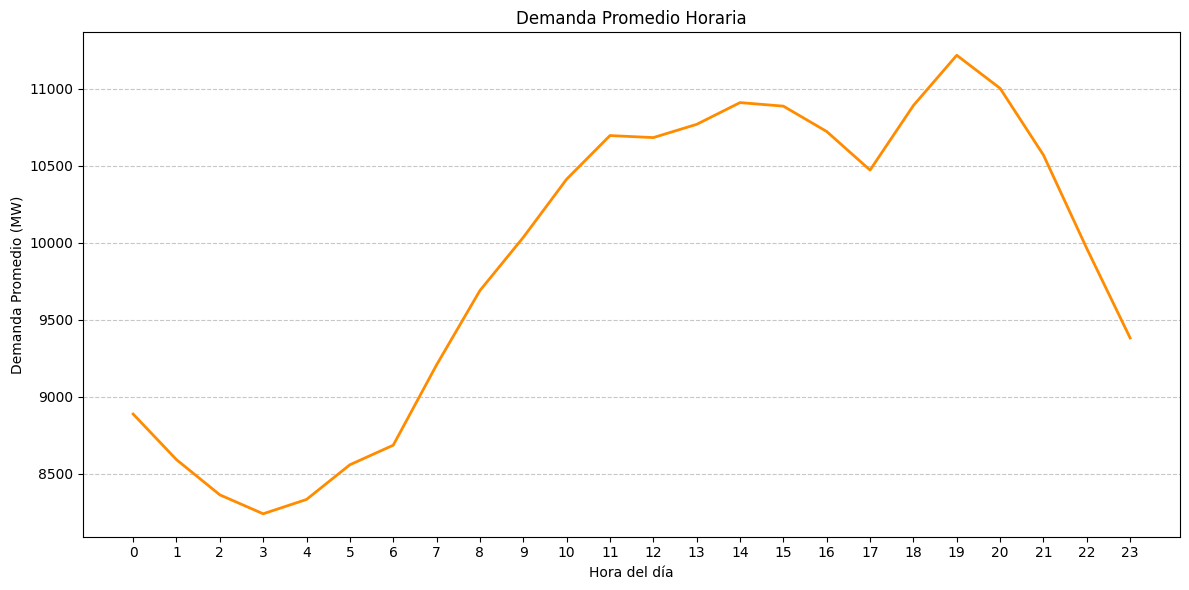

In [139]:
import matplotlib.pyplot as plt
import pandas as pd

# Calcular la demanda total por hora (sumando todos los buses)
demand_hourly = network.loads_t.p.sum(axis=1)

# Crear una columna que represente las horas del día usando los snapshots
demand_hourly.index = pd.to_datetime(network.snapshots)

# Agrupar por hora del día y calcular el promedio
demand_avg_hourly = demand_hourly.groupby(demand_hourly.index.hour).mean()

# Graficar demanda promedio horaria
plt.figure(figsize=(12, 6))
plt.plot(demand_avg_hourly.index, demand_avg_hourly.values, color="darkorange", linewidth=2)

# Personalizar el gráfico
plt.title("Demanda Promedio Horaria")
plt.xlabel("Hora del día")
plt.ylabel("Demanda Promedio (MW)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Etiquetas del eje X: horas del día (0 a 23)
plt.xticks(ticks=range(0, 24), labels=[f"{hour}" for hour in range(0, 24)])

plt.tight_layout()
plt.show()





c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



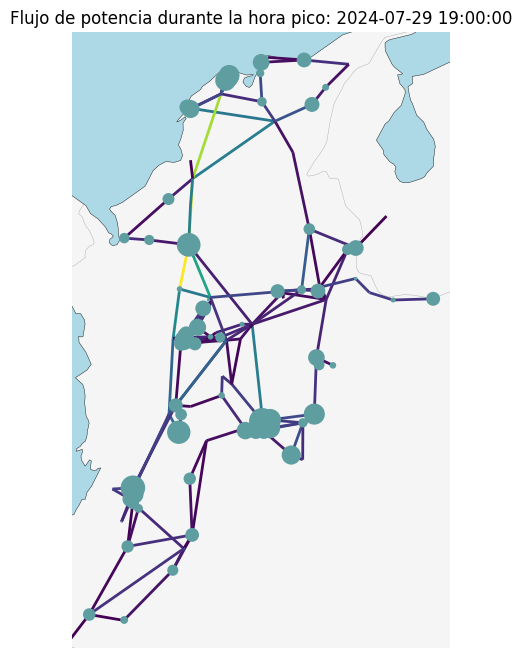

In [140]:
# Identificar la hora de máxima demanda
peak_time = total_demand.idxmax()

# Extraer datos de la red en la hora pico
peak_flows = network.lines_t.p0.loc[peak_time]
peak_demands = network.loads_t.p.loc[peak_time]

# Graficar mapa de la red en la hora pico
network.plot(
    line_colors=peak_flows.abs(),
    line_widths=2,
    bus_sizes=peak_demands / 1e4,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    title=f"Flujo de potencia durante la hora pico: {peak_time}"
)
plt.show()

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



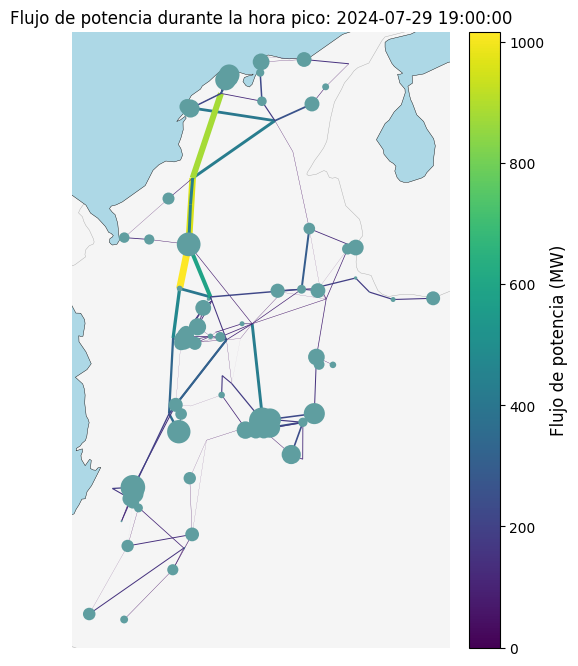

In [141]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

# Identificar la hora de máxima demanda
peak_time = total_demand.idxmax()

# Extraer datos de la red en la hora pico
peak_flows = network.lines_t.p0.loc[peak_time]
peak_demands = network.loads_t.p.loc[peak_time]

# Normalizar los flujos para el colormap
norm = Normalize(vmin=peak_flows.abs().min(), vmax=peak_flows.abs().max())

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
network.plot(
    ax=ax,
    line_colors=peak_flows.abs(),
    line_cmap=plt.cm.viridis,  # Cambia a plt.cm.coolwarm si prefieres otro estilo
    line_norm=norm,
    line_widths=peak_flows.abs()/ peak_flows.abs().max() * 5,  # Escalar líneas
    bus_sizes=peak_demands / 1e4,  # Tamaño de buses proporcional a la demanda
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    title=f"Flujo de potencia durante la hora pico: {peak_time}"
)

# Crear una barra de colores manualmente
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.02, fraction=0.05)
cbar.set_label("Flujo de potencia (MW)", fontsize=12)

plt.show()



## Dia y Noche

In [142]:
# Filtrar intervalos de tiempo directamente comparando las horas
day_hours = network.snapshots[network.snapshots.time >= pd.to_datetime("06:00").time()]
day_hours = day_hours[day_hours.time <= pd.to_datetime("18:00").time()]

# Identificar las horas restantes como noche
night_hours = network.snapshots.difference(day_hours)



In [143]:
network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\23933578.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



carrier              ACPM          AGUA      CARBON  COMBUSTOLEO      EOLICA  \
snapshot                                                                       
2024-07-01 00:00:00   0.0   7787.864117    0.000000          0.0  379.865740   
2024-07-01 01:00:00   0.0   7546.518765    0.000000          0.0  358.678500   
2024-07-01 02:00:00   0.0   7319.082483    0.000000          0.0  343.515599   
2024-07-01 03:00:00   0.0   7171.834810    0.000000          0.0  332.783030   
2024-07-01 04:00:00   0.0   7146.103657    0.000000          0.0  325.443512   
...                   ...           ...         ...          ...         ...   
2024-07-31 19:00:00   0.0  10322.595663  694.389638          0.0  470.670401   
2024-07-31 20:00:00   0.0  10320.492197  578.353857          0.0  459.136326   
2024-07-31 21:00:00   0.0  10185.693848  305.276822          0.0  443.829249   
2024-07-31 22:00:00   0.0   9962.548854   11.890645          0.0  427.507973   
2024-07-31 23:00:00   0.0   9403.560291    0.000000          0.0  406.262359   

carrier                     GAS  GLP  JET-A1  RAD SOLAR  
snapshot                                                 
2024-07-01 00:00:00  158.591752  0.0     0.0        0.0  
2024-07-01 01:00:00  141.568112  0.0     0.0        0.0  
2024-07-01 02:00:00  125.837032  0.0     0.0        0.0  
2024-07-01 03:00:00  115.592975  0.0     0.0        0.0  
2024-07-01 04:00:00  113.448543  0.0     0.0        0.0  
...                         ...  ...     ...        ...  
2024-07-31 19:00:00  554.524503  0.0     0.0        0.0  
2024-07-31 20:00:00  539.208541  0.0     0.0        0.0  
2024-07-31 21:00:00  488.813633  0.0     0.0        0.0  
2024-07-31 22:00:00  337.270409  0.0     0.0        0.0  
2024-07-31 23:00:00  265.071473  0.0     0.0        0.0  

[744 rows x 9 columns]

C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\3795411542.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\3795411542.py:5: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



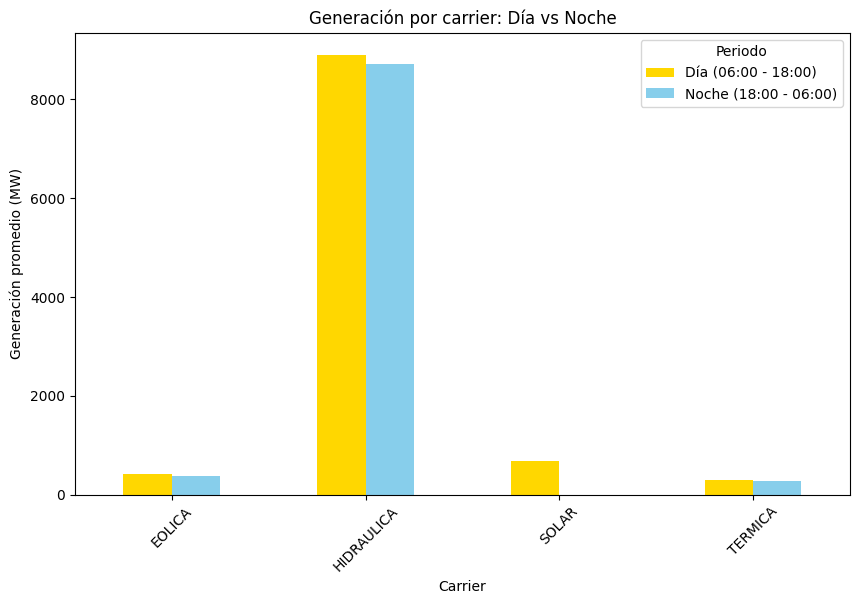

In [144]:
# Generación promedio en el día
gen_day = network.generators_t.p.loc[day_hours].groupby(network.generators.type, axis=1).sum()

# Generación promedio en la noche
gen_night = network.generators_t.p.loc[night_hours].groupby(network.generators.type, axis=1).sum()

# Crear un DataFrame combinado para comparación
gen_comparison = pd.DataFrame({
    "Día (06:00 - 18:00)": gen_day.mean(axis=0),
    "Noche (18:00 - 06:00)": gen_night.mean(axis=0)
})

# Graficar generación comparativa
gen_comparison.plot(kind="bar", figsize=(10, 6), color=["gold", "skyblue"])
plt.title("Generación por carrier: Día vs Noche")
plt.ylabel("Generación promedio (MW)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.legend(title="Periodo")
plt.show()


In [145]:
# Demanda total promedio en el día y la noche
demand_day = network.loads_t.p.loc[day_hours].sum(axis=1).mean()
demand_night = network.loads_t.p.loc[night_hours].sum(axis=1).mean()

# Mostrar resultados
print("Demanda promedio (MW):")
print(f"Día (06:00 - 18:00): {demand_day:.2f} MW")
print(f"Noche (18:00 - 06:00): {demand_night:.2f} MW")


Demanda promedio (MW):
Día (06:00 - 18:00): 10312.12 MW
Noche (18:00 - 06:00): 9373.88 MW


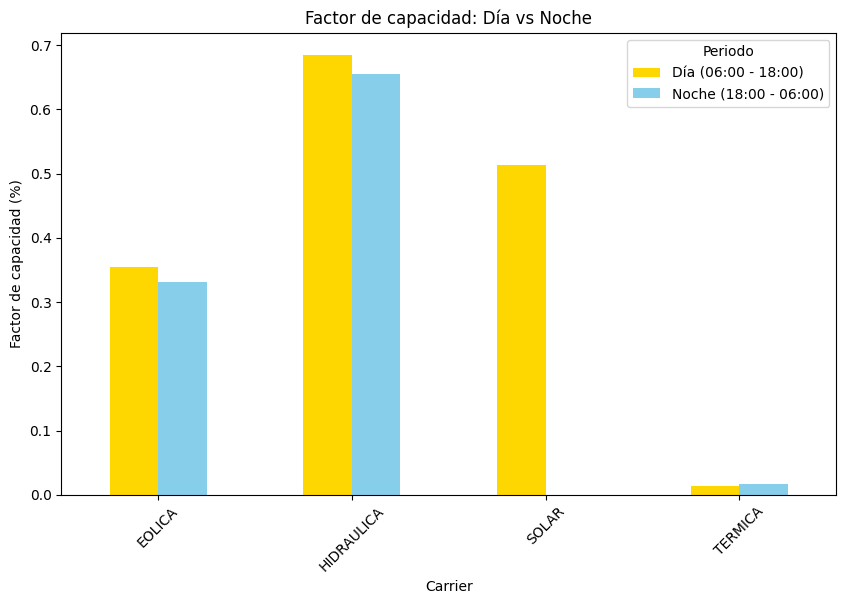

In [146]:
# Calcular el factor de capacidad para el día y la noche
capacity_factor_day = network.generators_t.p.loc[day_hours].divide(
    network.generators.p_nom, axis=1
).mean(axis=0).groupby(network.generators.type).mean()

capacity_factor_night = network.generators_t.p.loc[night_hours].divide(
    network.generators.p_nom, axis=1
).mean(axis=0).groupby(network.generators.type).mean()

# Comparar factores de capacidad
capacity_comparison = pd.DataFrame({
    "Día (06:00 - 18:00)": capacity_factor_day,
    "Noche (18:00 - 06:00)": capacity_factor_night
})

# Graficar comparación del factor de capacidad
capacity_comparison.plot(kind="bar", figsize=(10, 6), color=["gold", "skyblue"])
plt.title("Factor de capacidad: Día vs Noche")
plt.ylabel("Factor de capacidad (%)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.legend(title="Periodo")
plt.show()

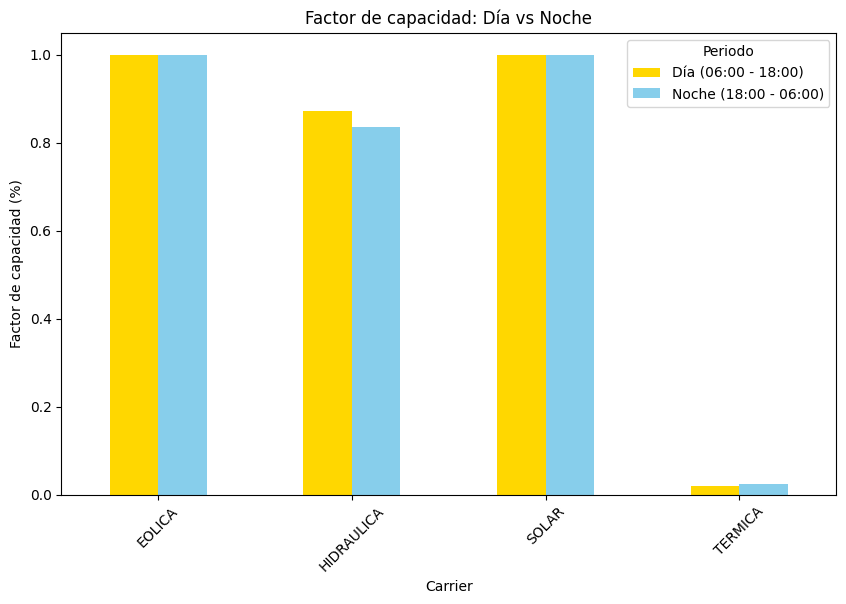

In [147]:
# Calcular el factor de capacidad para el día y la noche
capacity_factor_day = network.generators_t.p.loc[day_hours].divide(
    network.generators.p_nom * network.generators_t.p_max_pu.loc[day_hours], axis=1
).mean(axis=0).groupby(network.generators.type).mean()

capacity_factor_night = network.generators_t.p.loc[night_hours].divide(
    network.generators.p_nom * network.generators_t.p_max_pu.loc[night_hours], axis=1
).mean(axis=0).groupby(network.generators.type).mean()

# Comparar factores de capacidad
capacity_comparison = pd.DataFrame({
    "Día (06:00 - 18:00)": capacity_factor_day,
    "Noche (18:00 - 06:00)": capacity_factor_night
})

# Graficar comparación del factor de capacidad
capacity_comparison.plot(kind="bar", figsize=(10, 6), color=["gold", "skyblue"])
plt.title("Factor de capacidad: Día vs Noche")
plt.ylabel("Factor de capacidad (%)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.legend(title="Periodo")
plt.show()


In [148]:
# Identificar tecnología dominante en cada periodo
dominant_day = gen_day.idxmax(axis=1).value_counts()
dominant_night = gen_night.idxmax(axis=1).value_counts()

print("Tecnología dominante por periodo:")
print("Día:", dominant_day)
print("Noche:", dominant_night)


Tecnología dominante por periodo:
Día: HIDRAULICA    403
Name: count, dtype: int64
Noche: HIDRAULICA    341
Name: count, dtype: int64


c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



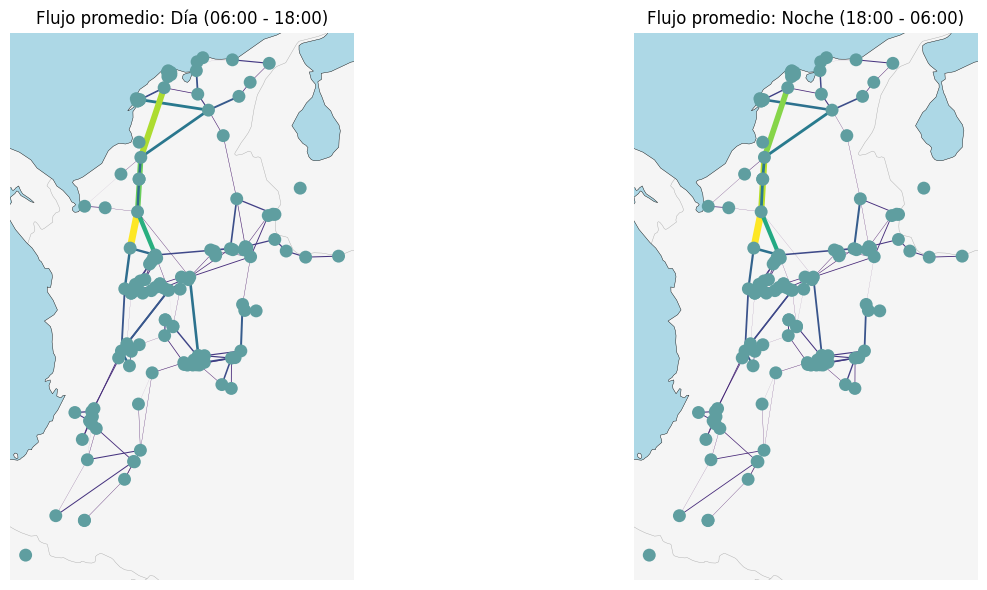

In [149]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Flujo promedio por periodo
flow_day = network.lines_t.p0.loc[day_hours].mean(axis=0)  # Flujo promedio en el día
flow_night = network.lines_t.p0.loc[night_hours].mean(axis=0)  # Flujo promedio en la noche

# Crear subplots con proyección geográfica
fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Graficar flujo promedio durante el día
network.plot(
    ax=axes[0],
    line_colors=flow_day.abs(),  # Valor absoluto del flujo
    line_widths=flow_day.abs() / flow_day.abs().max() * 5,  # Escalar el ancho de las líneas
    title="Flujo promedio: Día (06:00 - 18:00)",
    color_geomap=True,
)

# Graficar flujo promedio durante la noche
network.plot(
    ax=axes[1],
    line_colors=flow_night.abs(),
    line_widths=flow_night.abs() / flow_night.abs().max() * 5,
    title="Flujo promedio: Noche (18:00 - 06:00)",
    color_geomap=True,
)

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [150]:
# Crear un MultiIndex para el flujo del día
flow_day_multi = pd.Series(
    data=flow_day.values,
    index=pd.MultiIndex.from_tuples(
        [("Line", line) for line in flow_day.index],
        names=["branch_component", "name"],
    ),
)

# Crear un MultiIndex para el flujo de la noche
flow_night_multi = pd.Series(
    data=flow_night.values,
    index=pd.MultiIndex.from_tuples(
        [("Line", line) for line in flow_night.index],
        names=["branch_component", "name"],
    ),
)


c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



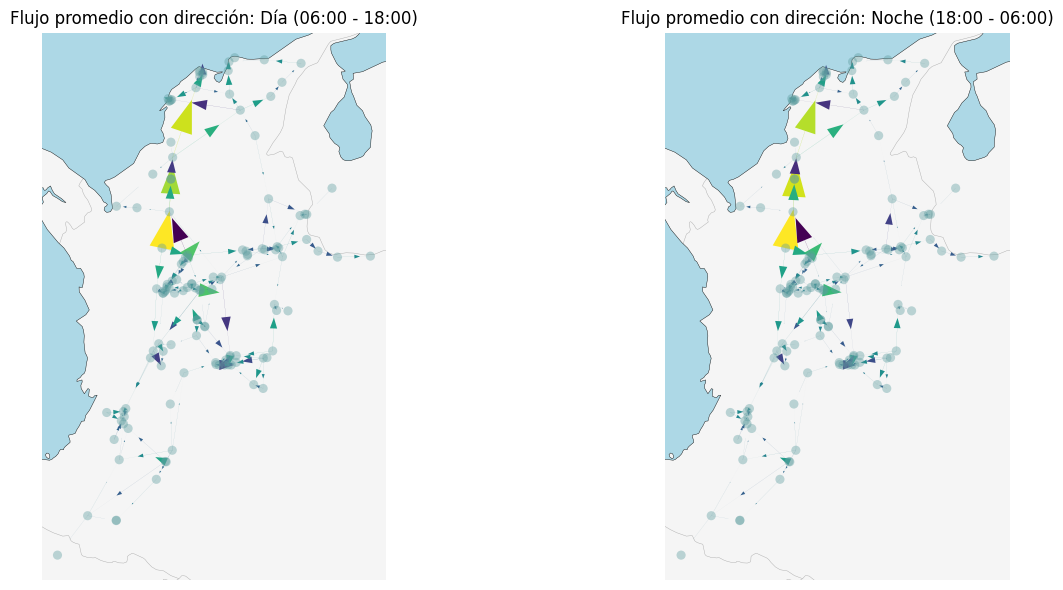

In [151]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Crear subplots con proyección geográfica
fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Día: Visualizar dirección del flujo
network.plot(
    ax=axes[0],
    line_colors=flow_day,  # Colores según flujo (positivo/negativo)
    line_widths=flow_day / flow_day.max() * 0.1,  # Escalar anchos directamente, sin abs()
    flow=flow_day_multi,  # Flujo con MultiIndex
    bus_sizes=1e-2,  # Tamaño mínimo para los buses
    bus_alpha=0.4,  # Transparencia para los buses
    title="Flujo promedio con dirección: Día (06:00 - 18:00)",
    color_geomap=True,
)

# Noche: Visualizar dirección del flujo
network.plot(
    ax=axes[1],
    line_colors=flow_night,  # Colores según flujo (positivo/negativo)
    line_widths=flow_night / flow_night.max() * 0.1,  # Escalar anchos directamente, sin abs()
    flow=flow_night_multi,  # Flujo con MultiIndex
    bus_sizes=1e-2,  # Tamaño mínimo para los buses
    bus_alpha=0.4,  # Transparencia para los buses
    title="Flujo promedio con dirección: Noche (18:00 - 06:00)",
    color_geomap=True,
)

# Mostrar los gráficos
plt.tight_layout()
plt.show()



c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



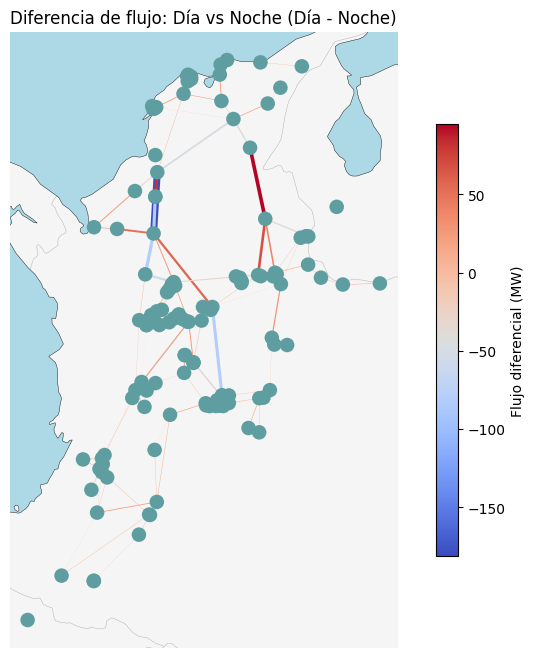

In [152]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Diferencia en el flujo entre el día y la noche
flow_difference = flow_day - flow_night  # Positivo = Más flujo durante el día

# Crear un mapa para visualizar la diferencia
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Graficar la red
network.plot(
    ax=ax,
    line_colors=flow_difference,  # Diferencia de flujo
    line_cmap=plt.cm.coolwarm,  # Escala de colores divergente (rojo para día, azul para noche)
    line_widths=flow_difference.abs() / flow_difference.abs().max() * 5,  # Escalar por magnitud
    title="Diferencia de flujo: Día vs Noche (Día - Noche)",
    color_geomap=True,
)

# Crear un ScalarMappable para la barra de color
sm = mpl.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=flow_difference.min(), vmax=flow_difference.max()))
sm._A = []  # Necesario para inicializar el ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Flujo diferencial (MW)")  # Etiqueta de la barra de color

plt.show()


In [153]:
import pandas as pd

# Crear un DataFrame con las diferencias
flow_comparison = pd.DataFrame({
    "Flujo Día (MW)": flow_day,
    "Flujo Noche (MW)": flow_night,
    "Diferencia (MW)": flow_day - flow_night
})

# Ordenar por la diferencia absoluta más grande
flow_comparison["Diferencia Absoluta"] = flow_comparison["Diferencia (MW)"].abs()
flow_comparison_sorted = flow_comparison.sort_values(by="Diferencia Absoluta", ascending=False)

# Mostrar las 10 líneas con mayor diferencia en flujo directamente
print(flow_comparison_sorted.head(10))

# Mostrar las 10 líneas con mayor diferencia
#import ace_tools as tools; tools.display_dataframe_to_user(name="Líneas con Mayor Diferencia de Flujo", dataframe=flow_comparison_sorted.head(10))


          Flujo Día (MW)  Flujo Noche (MW)  Diferencia (MW)  \
Line                                                          
Line_84       686.077248        866.951508      -180.874260   
Line_196       59.443599        -35.194444        94.638043   
Line_20       889.101318        971.774527       -82.673209   
Line_87       308.042753        389.253732       -81.210979   
Line_94      -308.042753       -389.253732        81.210979   
Line_28      -334.776058       -254.785066       -79.990992   
Line_227     -215.162094       -283.640407        68.478313   
Line_86        44.365788        -13.429529        57.795317   
Line_22       303.807088        359.660337       -55.853249   
Line_89        28.814484        -22.129454        50.943939   

          Diferencia Absoluta  
Line                           
Line_84            180.874260  
Line_196            94.638043  
Line_20             82.673209  
Line_87             81.210979  
Line_94             81.210979  
Line_28            

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



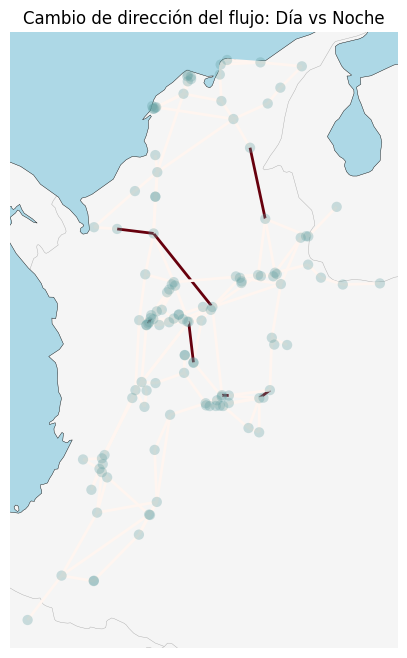

In [154]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Identificar las líneas con cambio de dirección
flow_direction_change = (flow_day * flow_night) < 0  # Verdadero si hay cambio de signo

# Crear un gráfico que destaque las líneas con cambio de dirección
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
network.plot(
    ax=ax,
    line_colors=flow_direction_change.astype(int),  # 1 si cambió de dirección, 0 si no
    line_cmap=plt.cm.Reds,  # Rojo para líneas con cambio de dirección
    line_widths=2,  # Ancho constante para resaltar
    bus_sizes=1e-2,  # Tamaño mínimo de los buses
    bus_alpha=0.3,  # Transparencia en los buses
    title="Cambio de dirección del flujo: Día vs Noche",
    color_geomap=True,
)

plt.show()


In [155]:
import pandas as pd

# Crear un DataFrame con los datos de flujo
flow_comparison = pd.DataFrame({
    "Flujo Día (MW)": flow_day,
    "Flujo Noche (MW)": flow_night,
    "Cambio de Dirección": flow_direction_change
})

# Filtrar líneas con cambio de dirección
lines_with_direction_change = flow_comparison[flow_comparison["Cambio de Dirección"]]

# Mostrar las 10 principales líneas con cambio de dirección
print(lines_with_direction_change.head(10))



          Flujo Día (MW)  Flujo Noche (MW)  Cambio de Dirección
Line                                                           
Line_30        24.585207        -14.495797                 True
Line_86        44.365788        -13.429529                 True
Line_89        28.814484        -22.129454                 True
Line_97        -0.549461         10.233978                 True
Line_126        0.143016         -0.131150                 True
Line_196       59.443599        -35.194444                 True
Line_245        2.570976        -22.564270                 True


## Precios

In [156]:
# Estadísticas descriptivas
network.generators_t.marginal_cost.describe()

Generator         ALBAN  AMOYA LA ESPERANZA  BARRANQUILLA 3  BARRANQUILLA 4  \
count      7.440000e+02        7.440000e+02      744.000000      744.000000   
mean       7.830000e+01        7.830000e+01     1089.008355     1107.988613   
std        9.812086e-13        9.812086e-13       25.736495       28.906477   
min        7.830000e+01        7.830000e+01     1048.384000     1062.381000   
25%        7.830000e+01        7.830000e+01     1054.915000     1069.840000   
50%        7.830000e+01        7.830000e+01     1093.123000     1112.507000   
75%        7.830000e+01        7.830000e+01     1114.011000     1135.904000   
max        7.830000e+01        7.830000e+01     1120.697000     1143.867000   

Generator       BETANIA        CALIMA  CARLOS LLERAS   CARTAGENA 1  \
count      7.440000e+02  7.440000e+02   7.440000e+02  7.440000e+02   
mean       7.830000e+01  7.830000e+01   7.830000e+01  1.726146e+03   
std        9.812086e-13  9.812086e-13   9.812086e-13  2.775825e-11   
min        7.830000e+01  7.830000e+01   7.830000e+01  1.726146e+03   
25%        7.830000e+01  7.830000e+01   7.830000e+01  1.726146e+03   
50%        7.830000e+01  7.830000e+01   7.830000e+01  1.726146e+03   
75%        7.830000e+01  7.830000e+01   7.830000e+01  1.726146e+03   
max        7.830000e+01  7.830000e+01   7.830000e+01  1.726146e+03   

Generator   CARTAGENA 2   CARTAGENA 3  ...  TERMOYOPAL 2  TERMOYOPAL G3  \
count      7.440000e+02  7.440000e+02  ...    744.000000     744.000000   
mean       1.726145e+03  1.463352e+03  ...     87.000008      87.000009   
std        1.387912e-11  1.842966e-11  ...      0.000008       0.000008   
min        1.726145e+03  1.463352e+03  ...     87.000000      87.000000   
25%        1.726145e+03  1.463352e+03  ...     87.000000      87.000000   
50%        1.726145e+03  1.463352e+03  ...     87.000010      87.000010   
75%        1.726145e+03  1.463352e+03  ...     87.000020      87.000010   
max        1.726145e+03  1.463352e+03  ...     87.000020      87.000020   

Generator  TERMOYOPAL G4  TERMOYOPAL G5    TESORITO          URRA   ZIPAEMG 2  \
count         744.000000     744.000000  744.000000  7.440000e+02  744.000000   
mean           87.000013     100.000004  903.690005  7.830000e+01  394.225806   
std             0.000008       0.000005    0.000005  9.812086e-13    0.418394   
min            87.000000     100.000000  903.690000  7.830000e+01  394.000000   
25%            87.000010     100.000000  903.690000  7.830000e+01  394.000000   
50%            87.000020     100.000000  903.690000  7.830000e+01  394.000000   
75%            87.000020     100.000010  903.690010  7.830000e+01  394.000000   
max            87.000020     100.000010  903.690010  7.830000e+01  395.000000   

Generator   ZIPAEMG 3   ZIPAEMG 4   ZIPAEMG 5  
count      744.000000  744.000000  744.000000  
mean       371.354839  368.354839  353.935484  
std          5.848965    8.007595    1.217251  
min        364.000000  362.000000  353.000000  
25%        364.000000  362.000000  353.000000  
50%        376.000000  362.000000  353.000000  
75%        376.000000  378.000000  355.000000  
max        376.000000  379.000010  356.000000  

[8 rows x 90 columns]

C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\1290777626.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



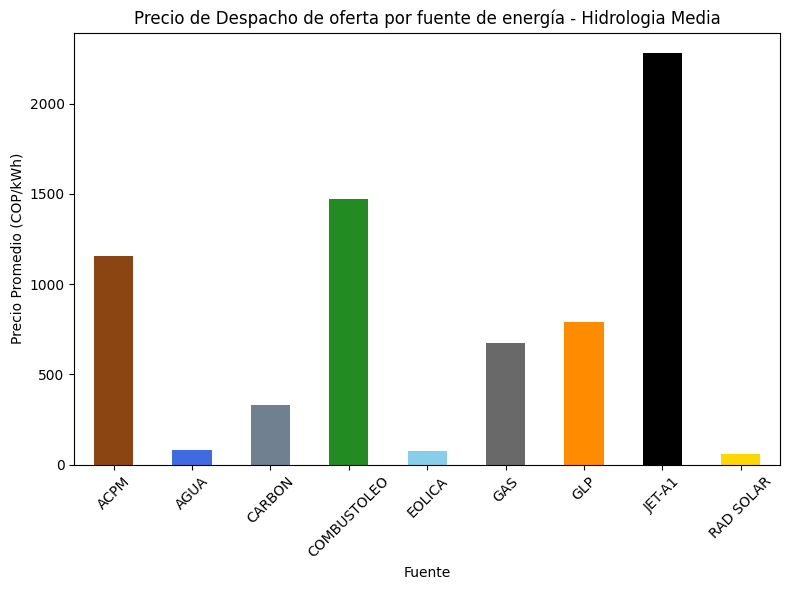

In [157]:
# Agrupar costos marginales por tecnología
marginal_costs_by_carrier = network.generators_t.marginal_cost.groupby(network.generators.carrier, axis=1).mean()

# Graficar promedio de costos marginales por tecnología
marginal_costs_by_carrier.mean().plot(
    kind="bar", 
    figsize=(8, 6), 
    color=[carrier_colors[carrier] for carrier in marginal_costs_by_carrier.columns]
)
plt.title(f"Precio de Despacho de oferta por fuente de energía - Hidrologia {escenario}")
plt.ylabel("Precio Promedio (COP/kWh)")
plt.xlabel("Fuente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\949370736.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



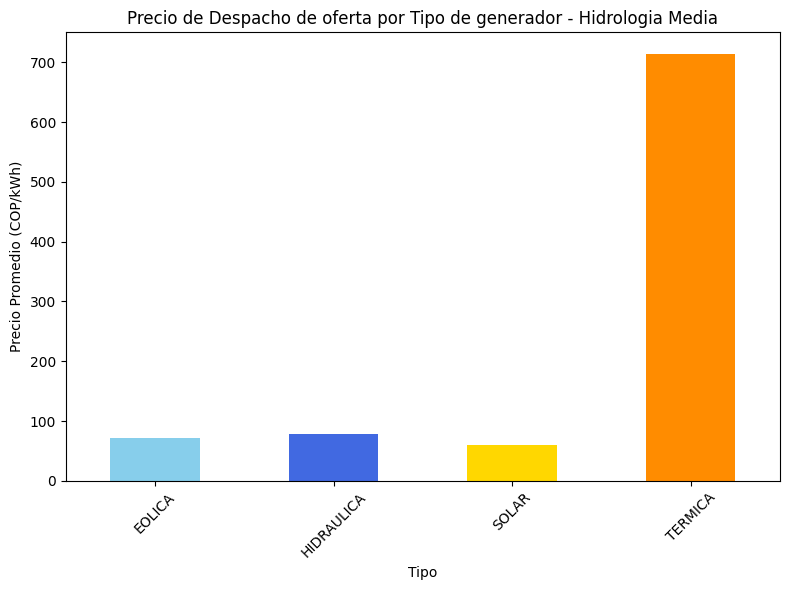

In [158]:
# Agrupar costos marginales por tecnología
marginal_costs_by_type= network.generators_t.marginal_cost.groupby(network.generators.type, axis=1).mean()

# Graficar promedio de costos marginales por tecnología
marginal_costs_by_type.mean().plot(
    kind="bar", 
    figsize=(8, 6), 
    color=[type_colors[carrier] for carrier in marginal_costs_by_type.columns]
)
plt.title(f"Precio de Despacho de oferta por Tipo de generador - Hidrologia {escenario}")
plt.ylabel("Precio Promedio (COP/kWh)")
plt.xlabel("Tipo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\261395737.py:5: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



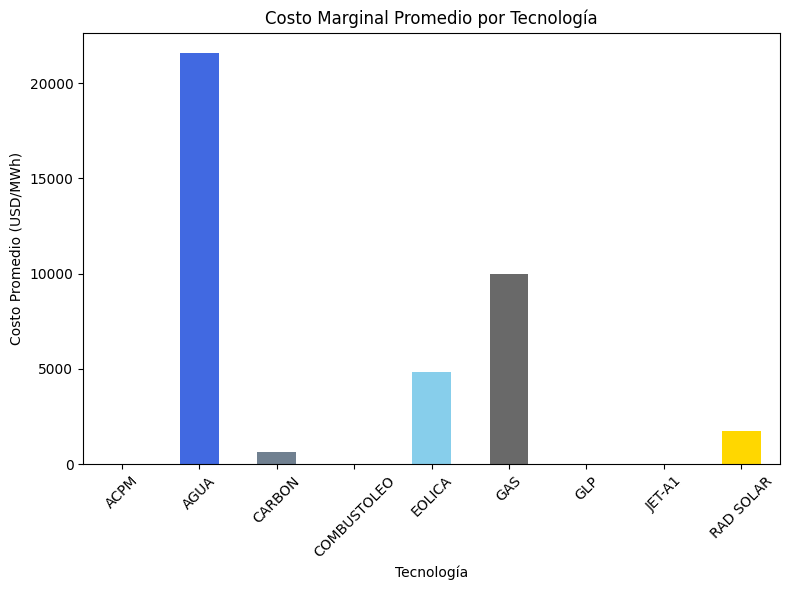

In [159]:
# Agrupar por tecnología (carrier)
marginal_costs_temporal = network.generators_t.p * network.generators_t.marginal_cost

avg_marginal_cost_by_carrier = (
    marginal_costs_temporal.groupby(network.generators.carrier, axis=1).mean()
)

# Graficar promedio de costos marginales por tecnología
avg_marginal_cost_by_carrier.mean().plot(kind="bar", figsize=(8, 6), color=[carrier_colors[carrier] for carrier in avg_marginal_cost_by_carrier.columns])
plt.title("Costo Marginal Promedio por Tecnología")
plt.ylabel("Costo Promedio (USD/MWh)")
plt.xlabel("Tecnología")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [160]:
# Sumar costos marginales por generador
total_cost_per_generator = marginal_costs_temporal.sum(axis=0)

# Ordenar generadores por costo total marginal
top_expensive_generators = total_cost_per_generator.sort_values(ascending=False).head(10)

# Mostrar generadores más costosos
print("Generadores con mayor costo marginal total:")
print(top_expensive_generators)


Generadores con mayor costo marginal total:
Generator
TEBSAB CC       1.087471e+08
GUAVIO          5.188419e+07
Hidroituango    5.161522e+07
CHIVOR          4.095449e+07
ITUANGO         4.088255e+07
SOGAMOSO        3.426645e+07
PORCE III       2.870141e+07
SAN CARLOS      2.766394e+07
PAGUA           2.415518e+07
GUATAPE         2.301027e+07
dtype: float64


C:\Users\juanm\AppData\Local\Temp\ipykernel_3088\1641847020.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



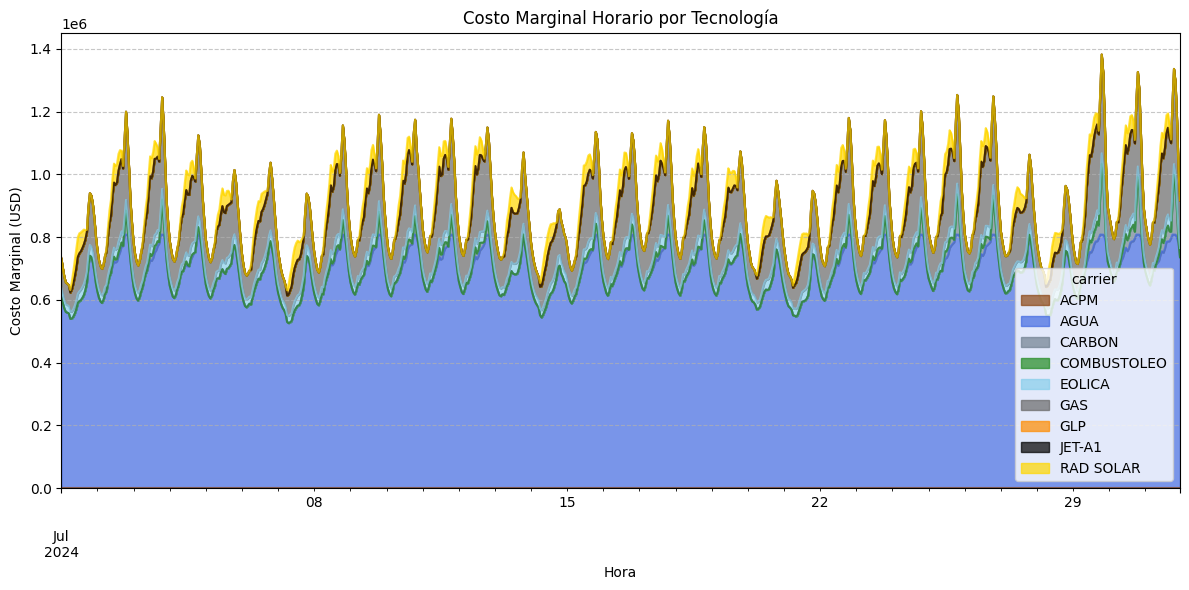

In [161]:
# Costo marginal por hora y tecnología
hourly_marginal_cost_by_carrier = (
    marginal_costs_temporal.groupby(network.generators.carrier, axis=1).sum()
)

# Graficar costos marginales por tecnología a lo largo del tiempo
hourly_marginal_cost_by_carrier.plot.area(
    figsize=(12, 6), alpha=0.7, color=[carrier_colors[carrier] for carrier in hourly_marginal_cost_by_carrier.columns]
)
plt.title("Costo Marginal Horario por Tecnología")
plt.ylabel("Costo Marginal (USD)")
plt.xlabel("Hora")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [162]:
import pandas as pd

# Obtener la capacidad instalada por carrier
capacity_by_carrier = network.generators.groupby('carrier').p_nom.sum()

# Mostrar la capacidad instalada por carrier
print(capacity_by_carrier)


carrier
ACPM             903.0
AGUA           13457.0
CARBON          1613.0
COMBUSTOLEO      266.0
EOLICA          1172.0
GAS             2983.0
GLP               52.0
JET-A1            50.0
RAD SOLAR       1346.9
Name: p_nom, dtype: float64


In [163]:
escenario

'Media'

## Vertimiento

In [164]:
import pandas as pd

# Obtener datos de generación máxima y generada
s_max_pu = network.generators_t.p_max_pu  # Disponibilidad relativa (en pu)
p_nom = network.generators.p_nom  # Capacidad nominal de cada generador
p_generated = network.generators_t.p  # Generación real en cada snapshot

# Calcular la capacidad máxima en MW
s_max_mw = s_max_pu.multiply(p_nom, axis=1)

# Calcular el vertimiento
vertimiento = s_max_mw - p_generated

# Asegurarse de que no haya valores negativos (por si hay overgeneration)
vertimiento[vertimiento < 0] = 0

# Mostrar los primeros resultados
vertimiento


Generator                   ALBAN  AMOYA LA ESPERANZA  BARRANQUILLA 3  \
snapshot                                                                
2024-07-01 00:00:00  0.000000e+00        6.219266e+01            60.0   
2024-07-01 01:00:00  7.275958e-12        3.414868e-11            60.0   
2024-07-01 02:00:00  3.320775e+02        6.221593e+01            60.0   
2024-07-01 03:00:00  0.000000e+00        3.623768e-13            60.0   
2024-07-01 04:00:00  4.159801e-10        6.221975e+01            60.0   
...                           ...                 ...             ...   
2024-07-31 19:00:00  0.000000e+00        6.806999e-12            60.0   
2024-07-31 20:00:00  1.705303e-10        0.000000e+00            60.0   
2024-07-31 21:00:00  3.047944e-10        3.626610e-11            60.0   
2024-07-31 22:00:00  0.000000e+00        3.418421e-11            60.0   
2024-07-31 23:00:00  4.385470e-10        2.104628e-11            60.0   

Generator            BARRANQUILLA 4       BETANIA        CALIMA  \
snapshot                                                          
2024-07-01 00:00:00            60.0  0.000000e+00  0.000000e+00   
2024-07-01 01:00:00            60.0  0.000000e+00  1.026326e+02   
2024-07-01 02:00:00            60.0  4.199575e+02  1.026563e+02   
2024-07-01 03:00:00            60.0  0.000000e+00  1.026647e+02   
2024-07-01 04:00:00            60.0  0.000000e+00  0.000000e+00   
...                             ...           ...           ...   
2024-07-31 19:00:00            60.0  0.000000e+00  4.312284e-10   
2024-07-31 20:00:00            60.0  2.343654e-10  0.000000e+00   
2024-07-31 21:00:00            60.0  4.698109e-10  0.000000e+00   
2024-07-31 22:00:00            60.0  0.000000e+00  0.000000e+00   
2024-07-31 23:00:00            60.0  0.000000e+00  0.000000e+00   

Generator            CARLOS LLERAS  CARTAGENA 1  CARTAGENA 2  CARTAGENA 3  \
snapshot                                                                    
2024-07-01 00:00:00   8.789414e-12         52.0         57.0          0.0   
2024-07-01 01:00:00   6.064654e+01         52.0         57.0          0.0   
2024-07-01 02:00:00   6.066053e+01         52.0         57.0          0.0   
2024-07-01 03:00:00   6.066550e+01         52.0         57.0          0.0   
2024-07-01 04:00:00   6.066426e+01         52.0         57.0          0.0   
...                            ...          ...          ...          ...   
2024-07-31 19:00:00   3.663558e-11         52.0         57.0          0.0   
2024-07-31 20:00:00   4.496314e-11         52.0         57.0          0.0   
2024-07-31 21:00:00   0.000000e+00         52.0         57.0          0.0   
2024-07-31 22:00:00   2.832934e-11         52.0         57.0          0.0   
2024-07-31 23:00:00   0.000000e+00         52.0         57.0          0.0   

Generator            ...  TERMOYOPAL 2  TERMOYOPAL G3  TERMOYOPAL G4  \
snapshot             ...                                               
2024-07-01 00:00:00  ...          28.0            0.0           47.0   
2024-07-01 01:00:00  ...          28.0            0.0           47.0   
2024-07-01 02:00:00  ...          28.0            0.0           47.0   
2024-07-01 03:00:00  ...          28.0            0.0           47.0   
2024-07-01 04:00:00  ...          28.0            0.0           47.0   
...                  ...           ...            ...            ...   
2024-07-31 19:00:00  ...           0.0            0.0            0.0   
2024-07-31 20:00:00  ...           0.0            0.0            0.0   
2024-07-31 21:00:00  ...           0.0            0.0            0.0   
2024-07-31 22:00:00  ...          28.0            0.0           47.0   
2024-07-31 23:00:00  ...          28.0            0.0           47.0   

Generator            TERMOYOPAL G5  TESORITO          URRA  ZIPAEMG 2  \
snapshot                                                                
2024-07-01 00:00:00            0.0       0.0  2.627640e+02        0.0   
2024-07-01 01:00:00 

In [165]:
vertimiento_total = vertimiento.sum(axis=1)  # Suma por filas (snapshots)
print(vertimiento_total)


snapshot
2024-07-01 00:00:00    6734.126112
2024-07-01 01:00:00    6993.995854
2024-07-01 02:00:00    7239.577353
2024-07-01 03:00:00    7397.926655
2024-07-01 04:00:00    7425.587846
                          ...     
2024-07-31 19:00:00    3856.344115
2024-07-31 20:00:00    3987.482361
2024-07-31 21:00:00    4297.272552
2024-07-31 22:00:00    4859.409052
2024-07-31 23:00:00    5484.745098
Freq: h, Length: 744, dtype: float64


In [166]:
vertimiento_por_generador = vertimiento.sum(axis=0)  # Suma por columnas (generadores)
print(vertimiento_por_generador)

Generator
ALBAN                 34624.221096
AMOYA LA ESPERANZA     6431.978635
BARRANQUILLA 3        44640.000000
BARRANQUILLA 4        44640.000000
BETANIA               40954.179643
                          ...     
URRA                  87204.128641
ZIPAEMG 2             14358.000000
ZIPAEMG 3             24436.000000
ZIPAEMG 4             46092.670419
ZIPAEMG 5             28560.000000
Length: 90, dtype: float64


In [167]:
import matplotlib.pyplot as plt

# Filtrar generadores solares
solar_generators = network.generators[network.generators.carrier == 'EOLICA'].index

# Calcular el vertimiento solo para los generadores solares
s_max_pu = network.generators_t.p_max_pu[solar_generators]
p_nom = network.generators.loc[solar_generators, 'p_nom']
p_generated = network.generators_t.p[solar_generators]

# Calcular la capacidad máxima en MW
s_max_mw = s_max_pu.multiply(p_nom, axis=1)
vertimiento = s_max_mw - p_generated
vertimiento[vertimiento < 0] = 0  # Eliminar valores negativos
vertimiento.sum(axis=0).mean()

2.176573351183227e-08

In [168]:
FECHAS_XM.min()

Timestamp('2024-07-01 00:00:00')

In [169]:
snap_mod = pd.date_range(start='2030-10-01', periods=len(DEM_SIN_series), freq="h")
#horas = pd.date_range(start=FECHAS_XM.min(), periods=len(DEM_SIN_series), freq="h")
snap_mod

DatetimeIndex(['2030-10-01 00:00:00', '2030-10-01 01:00:00',
               '2030-10-01 02:00:00', '2030-10-01 03:00:00',
               '2030-10-01 04:00:00', '2030-10-01 05:00:00',
               '2030-10-01 06:00:00', '2030-10-01 07:00:00',
               '2030-10-01 08:00:00', '2030-10-01 09:00:00',
               ...
               '2030-10-31 14:00:00', '2030-10-31 15:00:00',
               '2030-10-31 16:00:00', '2030-10-31 17:00:00',
               '2030-10-31 18:00:00', '2030-10-31 19:00:00',
               '2030-10-31 20:00:00', '2030-10-31 21:00:00',
               '2030-10-31 22:00:00', '2030-10-31 23:00:00'],
              dtype='datetime64[ns]', length=744, freq='h')

In [170]:
año_arriba

Period('2030-10', 'M')

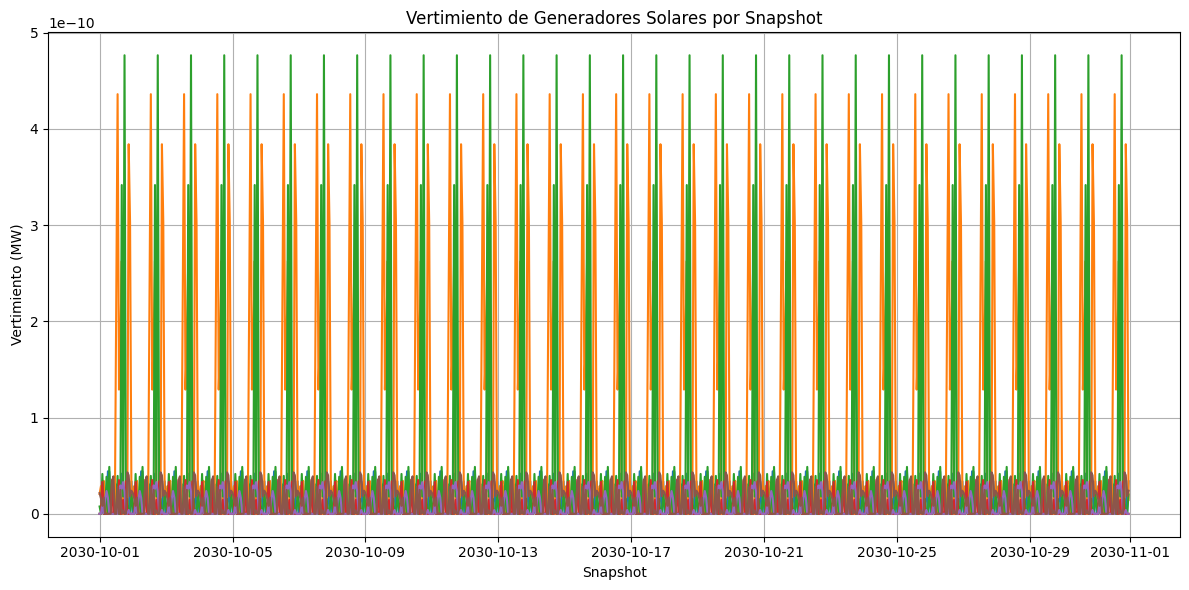

In [171]:

# Crear el gráfico
plt.figure(figsize=(12, 6))
for generator in vertimiento.columns:
    plt.plot(snap_mod, vertimiento[generator], label=f'Generador Solar {generator}')

# Personalizar el gráfico
plt.title('Vertimiento de Generadores Solares por Snapshot')
plt.xlabel('Snapshot')
plt.ylabel('Vertimiento (MW)')
#plt.legend(title="Generadores Solares", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Ajustar márgenes
plt.show()


In [172]:
# Encontrar los generadores con vertimiento mayor a 50 en algún snapshot
generadores_mayor_50 = vertimiento.columns[(vertimiento > 50).any()]

# Mostrar los generadores identificados
print("Generadores con vertimiento mayor a 50 MW:")
print(generadores_mayor_50.tolist())


Generadores con vertimiento mayor a 50 MW:
[]


In [173]:
vertimiento_mayor_50 = vertimiento.loc[:, (vertimiento > 50).any()]
vertimiento_mayor_50.sum()

Series([], dtype: float64)

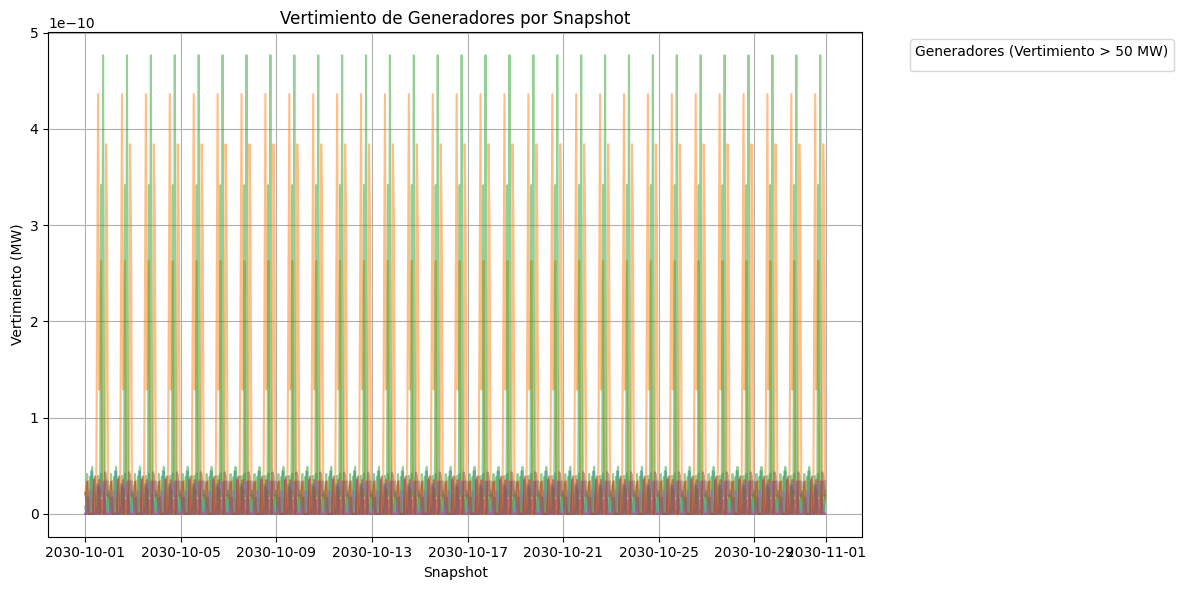

In [174]:
import matplotlib.pyplot as plt

# Identificar generadores con vertimiento mayor a 50
generadores_mayor_50 = vertimiento.columns[(vertimiento > 50).any()]

# Crear el gráfico
plt.figure(figsize=(12, 6))
for generator in vertimiento.columns:
    if generator in generadores_mayor_50:
        plt.plot(snap_mod, vertimiento[generator], label=f'Generador {generator}')  # Con leyenda
    else:
        plt.plot(snap_mod, vertimiento[generator], alpha=0.5)  # Sin leyenda y con opacidad reducida

# Personalizar el gráfico
plt.title('Vertimiento de Generadores por Snapshot')
plt.xlabel('Snapshot')
plt.ylabel('Vertimiento (MW)')
plt.legend(title="Generadores (Vertimiento > 50 MW)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Ajustar márgenes
plt.show()


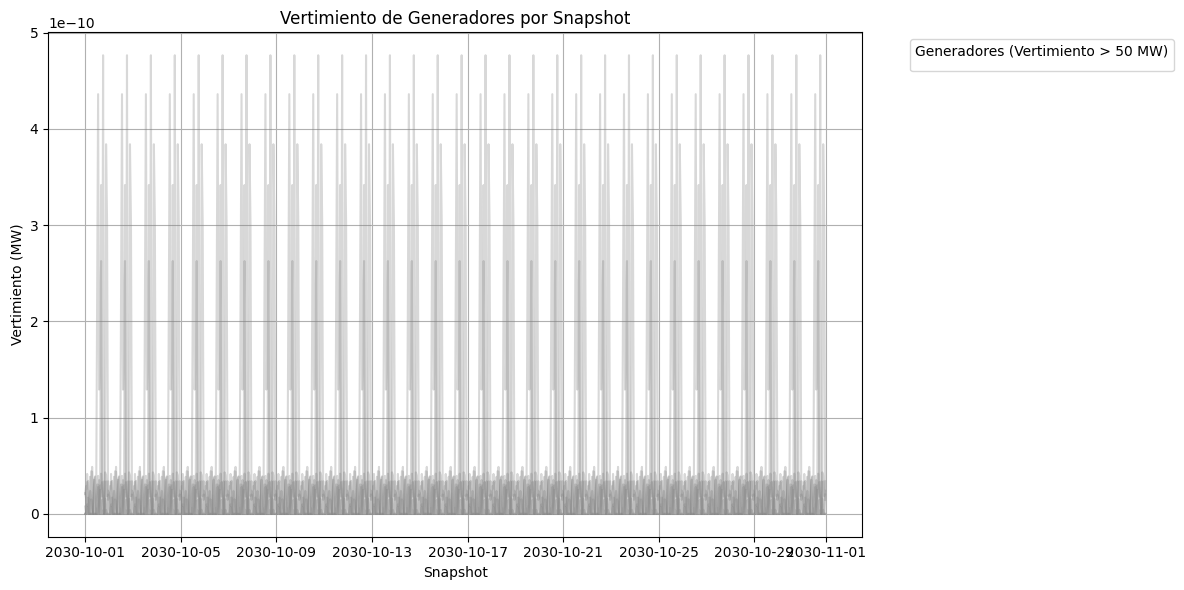

In [175]:
import matplotlib.pyplot as plt
from itertools import cycle

# Identificar generadores con vertimiento mayor a 50
generadores_mayor_50 = vertimiento.columns[(vertimiento > 50).any()]

# Crear un ciclo de colores contrastantes
color_palette = plt.cm.tab10.colors  # Paleta contrastante (tab10)
color_cycle = cycle(color_palette)  # Iterar sobre los colores

# Crear el gráfico
plt.figure(figsize=(12, 6))
for generator in vertimiento.columns:
    color = next(color_cycle) if generator in generadores_mayor_50 else 'gray'
    plt.plot(snap_mod, vertimiento[generator], label=f'Generador {generator}' if generator in generadores_mayor_50 else None, color=color, alpha=0.8 if generator in generadores_mayor_50 else 0.3)

# Personalizar el gráfico
plt.title('Vertimiento de Generadores por Snapshot')
plt.xlabel('Snapshot')
plt.ylabel('Vertimiento (MW)')
plt.legend(title="Generadores (Vertimiento > 50 MW)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Ajustar márgenes
plt.show()


In [176]:
network.generators.loc['PARQUE SOLAR LA UNION']

bus                        MONTERIA (ISA)
control                                PQ
type                                SOLAR
p_nom                               100.0
p_nom_mod                             0.0
p_nom_extendable                    False
p_nom_min                             0.0
p_nom_max                             inf
p_min_pu                              0.0
p_max_pu                              1.0
p_set                                 0.0
e_sum_min                            -inf
e_sum_max                             inf
q_set                                 0.0
sign                                  1.0
carrier                         RAD SOLAR
marginal_cost                         0.0
marginal_cost_quadratic               0.0
active                               True
build_year                              0
lifetime                              inf
capital_cost                          0.0
efficiency                            1.0
committable                       

In [177]:
network.generators_t.p["PARQUE SOLAR LA UNION"]

snapshot
2024-07-01 00:00:00   -0.0
2024-07-01 01:00:00   -0.0
2024-07-01 02:00:00   -0.0
2024-07-01 03:00:00   -0.0
2024-07-01 04:00:00   -0.0
                      ... 
2024-07-31 19:00:00   -0.0
2024-07-31 20:00:00   -0.0
2024-07-31 21:00:00   -0.0
2024-07-31 22:00:00   -0.0
2024-07-31 23:00:00   -0.0
Freq: h, Name: PARQUE SOLAR LA UNION, Length: 744, dtype: float64

In [178]:
escenario

'Media'